# Emotion Analysis Using ECG and GSR Signals

## Background
This study used the YAAD, which consists of Electrocardiogram (ECG) and Galvanic Skin Response (GSR) measurements designed explicitly for emotion recognition in young adults (Dar et al., 2022). The data was gathered from 25 participants using wearable Shimmer3 ECG and GSR sensors. It consists of three main components: raw physiological data, extracted ECG and GSR features, and self-annotation labels provided by the participants. 
Features will be extracted using 
- Statistical method
- Autoencoder
- Wavelet transform
- Fourier transform

In [ ]:
#!pip install scikit-learn

In [1]:
!pip install imbalanced-learn

## Import the libraries 

In [3]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
# from scipy.integrate import trapz
import warnings

In [15]:
# Load the stimulus description directly from Excel
stimulus_desc = pd.read_excel("C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Stress\\ECG_GSR_Emotions\\Stimulus_Description.xlsx")
stimulus_desc.head()

Session ID  Video ID Target Emotion  \
0           1         1          happy   
1           1         2            sad   
2           1         3        neutral   
3           1         4       surprise   
4           1         5        disgust   

                             Title of Video Clip  Time Duration (secs)  \
0         Best Babies Laughing Video Compilation                    39   
1                                   Barely There                    39   
2                    Denali National Park Alaska                    39   
3  World's Highest Commercially Rafted Waterfall                    39   
4                   Disgusting video compilation                    39   

                                Active Link of Video  
0  https://drive.google.com/file/d/1ZWD1zyWkHcBI0...  
1  https://drive.google.com/file/d/13ysQgSsBwy3d8...  
2  https://drive.google.com/file/d/1En_ARj18JlBLP...  
3  https://drive.google.com/file/d/1kCIHXEklgpWds...  
4  https://drive.google.com/file/d/1mclmT0EAA-oZ6...

In [16]:
# Load self-annotation multimodal
self_annotation_multimodal = pd.read_excel("C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Stress\\ECG_GSR_Emotions\\Self-Annotation Labels\\Self-annotation Multimodal_Use.xlsx")
self_annotation_multimodal['Annotation'] = 'M'
self_annotation_multimodal.rename(columns={'V_Label': 'Valence', 'A_Label': 'Arousal', 'Four_Labels': 'Four_Label'}, inplace=True)
self_annotation_multimodal.head()

Participant Id  Session ID  Video ID Name  Age  Gender  Valence level  \
0               1           1         1  M_M   13  Female              8   
1               1           1         2  M_M   13  Female              4   
2               1           1         2  M_M   13  Female              4   
3               1           1         4  M_M   13  Female              9   
4               1           1         5  M_M   13  Female              0   

   Arousal level  Dominance level     Happy  ...    Anger  Neutral   Disgust  \
0              0                0      High  ...  VeryLow  VeryLow   VeryLow   
1              0                0   VeryLow  ...  VeryLow  VeryLow   VeryLow   
2              0                0   VeryLow  ...  VeryLow  VeryLow   VeryLow   
3              0                0  VeryHigh  ...  VeryLow  VeryLow   VeryLow   
4              9                0   VeryLow  ...  VeryLow  VeryLow  VeryHigh   

  Surprised Familiarity Score   Emotion Valence Arousal Four_Label Annotation  
0   VeryLow     Never watched     Happy      HV      LA       HVLA          M  
1   VeryLow               NaN       Sad      LV      LA       LVLA          M  
2       Low               NaN  Surprise      LV      LA       LVLA          M  
3   VeryLow               NaN     Happy      HV      LA       HVLA          M  
4   VeryLow               NaN   Disgust      LV      HA       LVHA          M  

[5 rows x 22 columns]

In [17]:
self_annotation_multimodal['Emotion'].unique()

array(['Happy', 'Sad', 'Surprise', 'Disgust', 'Fear', 'Mixed', 'Anger',
       'Neutral'], dtype=object)

In [18]:
# Column order for the resulting dataframe
cols_ecg = ['Raw Data'] + list(self_annotation_multimodal.columns)
print(cols_ecg)

['Raw Data', 'Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score', 'Emotion', 'Valence', 'Arousal', 'Four_Label', 'Annotation']


In [19]:
arr_shape = 1000
raw_data_arr = []

def form_data_ecg(data_array = [], annotation = '', data_path = ''):
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('ECGdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p');
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = self_annotation_multimodal.loc[(self_annotation_multimodal['Session ID'] == int(s)) & 
                             (self_annotation_multimodal['Participant Id'] == int(p)) & 
                             (self_annotation_multimodal['Video ID'] == int(v)) &
                             (self_annotation_multimodal['Annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              data_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['Annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return data_array

In [20]:
raw_data_arr =  form_data_ecg(data_array = raw_data_arr, annotation = 'M', data_path = "C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Stress\\ECG_GSR_Emotions\\Raw Data\\Multimodal\\ECG")

cols_ecg.append('Target Emotion')
raw_dataframe_ecg = pd.DataFrame(raw_data_arr, columns = cols_ecg)
raw_dataframe_ecg.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe_ecg['Familiarity Score'] = raw_dataframe_ecg['Familiarity Score'].fillna('Never watched')
raw_dataframe_ecg = raw_dataframe_ecg.replace(np.nan, '', regex=True)
raw_dataframe_ecg.head()

Raw Data  Participant ID  \
0  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   
1  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   
2  [-18.619, -18.624, -18.615, -18.604, -18.616, ...              10   
3  [-18.705, -18.669, -18.642, -18.586, -18.552, ...              10   
4  [-18.561, -18.561, -18.557, -18.557, -18.545, ...              10   

   Session ID  Video ID Name  Age Gender  Valence level  Arousal level  \
0           1         1  S_D    8   Male              8              3   
1           1         1  S_D    8   Male              9              7   
2           1         2  S_D    8   Male              5              4   
3           1         3  S_D    8   Male              4              0   
4           1         4  S_D    8   Male              7              6   

   Dominance level  ...   Neutral  Disgust Surprised Familiarity Score  \
0                0  ...   VeryLow  VeryLow   VeryLow     Never watched   
1                0  ...   VeryLow  VeryLow   VeryLow     Never watched   
2                2  ...       Low  VeryLow       Low     Never watched   
3                0  ...  VeryHigh  VeryLow   VeryLow     Never watched   
4                0  ...   VeryLow  VeryLow  VeryHigh     Never watched   

    Emotion Valence Arousal Four label Annotation Target Emotion  
0     Happy      HV      LA       HVLA          M          happy  
1     Happy      HV      HA       HVHA          M          happy  
2     Mixed      LV      LA       LVLA          M            sad  
3   Neutral      LV      LA       LVLA          M        neutral  
4  Surprise      HV      HA       HVHA          M       surprise  

[5 rows x 24 columns]

In [21]:
ecg_dataframe = raw_dataframe_ecg.copy()
ecg_dataframe.head(2)

Raw Data  Participant ID  \
0  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   
1  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   

   Session ID  Video ID Name  Age Gender  Valence level  Arousal level  \
0           1         1  S_D    8   Male              8              3   
1           1         1  S_D    8   Male              9              7   

   Dominance level  ...  Neutral  Disgust Surprised Familiarity Score Emotion  \
0                0  ...  VeryLow  VeryLow   VeryLow     Never watched   Happy   
1                0  ...  VeryLow  VeryLow   VeryLow     Never watched   Happy   

  Valence Arousal Four label Annotation Target Emotion  
0      HV      LA       HVLA          M          happy  
1      HV      HA       HVHA          M          happy  

[2 rows x 24 columns]

In [22]:
ecg_dataframe['Raw Data']

0      [-18.702, -18.694, -18.692, -18.678, -18.665, ...
1      [-18.702, -18.694, -18.692, -18.678, -18.665, ...
2      [-18.619, -18.624, -18.615, -18.604, -18.616, ...
3      [-18.705, -18.669, -18.642, -18.586, -18.552, ...
4      [-18.561, -18.561, -18.557, -18.557, -18.545, ...
                             ...                        
247    [3.1705, 3.1762, 3.1759, 3.1687, 3.1793, 3.169...
248    [-18.561, -18.561, -18.557, -18.557, -18.545, ...
249    [3.6369, 3.6316, 3.6195, 3.6102, 3.6257, 3.612...
250    [3.8977, 3.9059, 3.8881, 3.8857, 3.8735, 3.865...
251    [-20.438, -20.445, -20.428, -20.428, -20.417, ...
Name: Raw Data, Length: 252, dtype: object

### Visualised ECG and GSR signals were used to check for anomalies or patterns corresponding to the participant's emotional state

In [23]:
def plot_ecg_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        try:
            plt.plot(y, label='Session {}'.format(row['Session ID']))
            plt.legend()
        except:
            plt.plot(y)
        
    plt.tight_layout()
    plt.title(title)
    plt.show()

In [24]:
def PlotECG(df, participant_id=10, target_emotion='sad'):
    return df[(df['Participant ID']==participant_id)&(df['Target Emotion']==target_emotion)]

<Figure size 640x480 with 0 Axes>

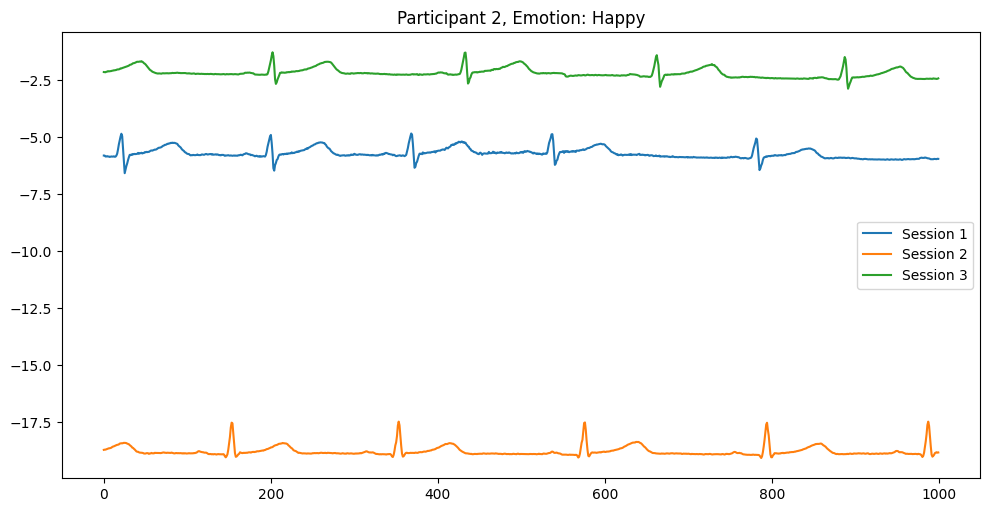

In [25]:
plot_ecg_signals(PlotECG(ecg_dataframe, 2, 'happy'), title='Participant 2, Emotion: Happy')

<Figure size 640x480 with 0 Axes>

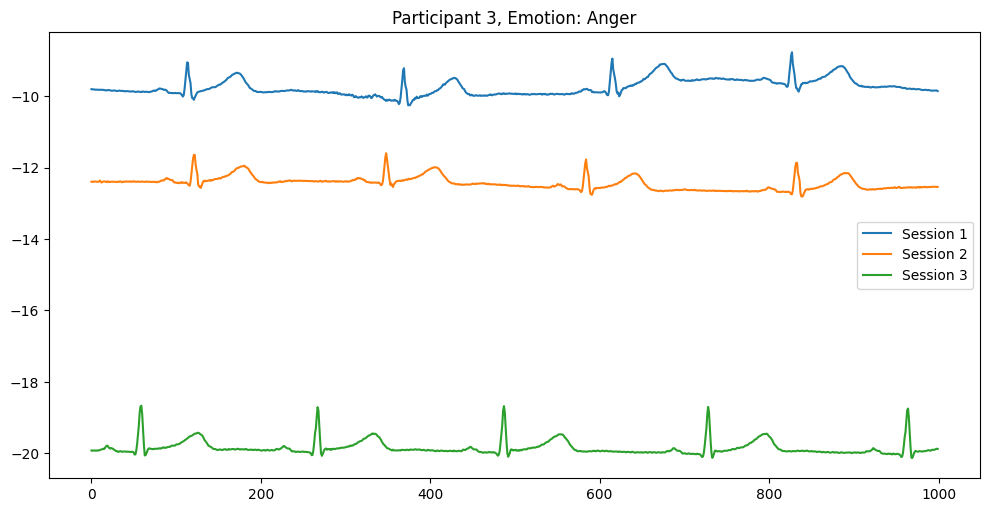

In [26]:
plot_ecg_signals(PlotECG(ecg_dataframe, 3, 'anger'), title='Participant 3, Emotion: Anger')

In [27]:
ecg_dataframe.drop(['Video ID', 'Happy', 'Sad', 'Fear','Anger', 'Neutral', 'Disgust', 'Surprised', 
                                    'Four label', 'Session ID', 'Familiarity Score', 'Age', 
                                    'Gender', 'Name'], axis = 1).head()

Raw Data  Participant ID  \
0  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   
1  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   
2  [-18.619, -18.624, -18.615, -18.604, -18.616, ...              10   
3  [-18.705, -18.669, -18.642, -18.586, -18.552, ...              10   
4  [-18.561, -18.561, -18.557, -18.557, -18.545, ...              10   

   Valence level  Arousal level  Dominance level   Emotion Valence Arousal  \
0              8              3                0     Happy      HV      LA   
1              9              7                0     Happy      HV      HA   
2              5              4                2     Mixed      LV      LA   
3              4              0                0   Neutral      LV      LA   
4              7              6                0  Surprise      HV      HA   

  Annotation Target Emotion  
0          M          happy  
1          M          happy  
2          M            sad  
3          M        neutral  
4          M       surprise

In [28]:
ecg_dataframe.rename(columns = {'Raw Data':'feature_ecg', 'Emotion':'emotion_ecg'}, inplace = True)
ecg_dataframe.head(3)

feature_ecg  Participant ID  \
0  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   
1  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   
2  [-18.619, -18.624, -18.615, -18.604, -18.616, ...              10   

   Session ID  Video ID Name  Age Gender  Valence level  Arousal level  \
0           1         1  S_D    8   Male              8              3   
1           1         1  S_D    8   Male              9              7   
2           1         2  S_D    8   Male              5              4   

   Dominance level  ...  Neutral  Disgust Surprised Familiarity Score  \
0                0  ...  VeryLow  VeryLow   VeryLow     Never watched   
1                0  ...  VeryLow  VeryLow   VeryLow     Never watched   
2                2  ...      Low  VeryLow       Low     Never watched   

  emotion_ecg Valence Arousal Four label Annotation Target Emotion  
0       Happy      HV      LA       HVLA          M          happy  
1       Happy      HV      HA       HVHA          M          happy  
2       Mixed      LV      LA       LVLA          M            sad  

[3 rows x 24 columns]

In [29]:
ecg_signals = ecg_dataframe.copy()

### Using Statistical Measures 

Brief explanation of each column:

* emotion: The emotional state of the participant when the signal was recorded.
* meanrr: Mean of RR intervals. RR intervals are the time gaps between successive R-peaks in the ECG signal. The R-peak is the highest point of the QRS complex, representing ventricular depolarization.
* medianrr: Median of RR intervals.
* sdrr: Standard deviation of RR intervals. It gives a measure of the variability in the intervals.
* rmssd: Root mean square of successive RR interval differences. It's a measure of the short-term variability in the heart rate.
* sdrr_rmssd: Ratio of sdrr to rmssd. It can give insights into the balance between short-term and long-term HRV.
* hr: Heart rate, typically in beats per minute (bpm).
* NNx: The number of pairs of successive NN intervals that differ by more than x ms. NN intervals are essentially RR intervals but account for only "normal" heartbeats.
* pNNx: The proportion of NN intervals that differ by more than x ms. It's often expressed as a percentage and can be used to understand the percentage of intervals that have significant variability.
* sd1: Represents the standard deviation of the instantaneous beat-to-beat variability. Often used in Poincaré plot analysis.
* sd2: Represents the standard deviation of the continuous long-term RR interval variability. Also used in Poincaré plot analysis.
* skew: Skewness of the RR interval distribution. It's a measure of the asymmetry of the distribution.
* kurt: Kurtosis of the RR interval distribution. It measures the "tailedness" of the distribution, i.e., whether data are heavy-tailed or light-tailed compared to a normal distribution.

### STATISTICAL FEATURES - ECG

In [30]:
# Import the necessary libararies
from __future__ import division
from matplotlib import pyplot as plt
import scipy.io as spio
import numpy as np
import statistics
from scipy.stats import kurtosis
from scipy.stats import skew
import sys
import cProfile
from functools import partial

In [31]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = sci_label(np.diff(p) < threshold)
 
    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
    #for i in np.unique(peak_groups):    
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

"""TIME DOMAIN"""
#independent function to calculate RMSSD
def calc_rmssd(list):
    diff_nni = np.diff(list)#successive differences
    return np.sqrt(np.mean(diff_nni ** 2))

#independent function to calculate AVRR   
def calc_avrr(list):
    return sum(list)/len(list)

#independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

#independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

 #independent function to calculate SKEW   
def calc_skew(list):
    return skew(list)

 #independent function to calculate KURT   
def calc_kurt(list):
    return kurtosis(list)

def calc_NNx(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
    #return sum(np.abs(diff_nni) > 50)
    return nnxx

def calc_pNNx(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    pnnxx = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    #return sum(np.abs(diff_nni) > 50)
    return pnnxx

"""NON LINEAR DOMAIN"""
 #independent function to calculate SD1
def calc_SD1(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
 #independent function to calculate SD2
def calc_SD2(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                   diff_nn_intervals, ddof=1) ** 2)

#independent function to calculate SD1/SD2
def calc_SD1overSD2(list):
      diff_nn_intervals = np.diff(list)
      sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
      sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                    diff_nn_intervals, ddof=1) ** 2)
      ratio_sd2_sd1 = sd2 / sd1
      return ratio_sd2_sd1

#independent function to calculate CSI
def calc_CSI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L/T

#independent function to calculate CVI
def calc_CVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return np.log10(L * T)

#independent function to calculate modified CVI
def calc_modifiedCVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L ** 2 / T

def calc_meanrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.mean(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

def calc_hr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat 
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    hr = 60000/rr
    return np.mean(hr)

In [32]:
medianrr = []
meanrr = []
rmssd = []
sdrr_rmssd = []
hr = []
avrr = []
sdrr = []
skew_ = []
kurt = []
NNx = []
pNNx = []
SD1 = []
SD2 = []
CSI = []
CVI = []
modifiedCVI = []
SD1overSD2 = []

for index, row in ecg_signals.iterrows():
    rmssd.append(calc_rmssd(row['feature_ecg']))
    avrr.append(calc_avrr(row['feature_ecg']))
    sdrr.append(calc_sdrr(row['feature_ecg']))
    skew_.append(calc_skew(row['feature_ecg']))
    kurt.append(calc_kurt(row['feature_ecg']))
    NNx.append(calc_NNx(pd.Series(row['feature_ecg'])))
    pNNx.append(calc_pNNx(pd.Series(row['feature_ecg'])))
    SD1.append(calc_SD1(row['feature_ecg']))
    SD2.append(calc_SD2(row['feature_ecg']))
    CSI.append(calc_CSI(row['feature_ecg']))
    CVI.append(calc_CVI(row['feature_ecg']))
    modifiedCVI.append(calc_modifiedCVI(row['feature_ecg']))
    SD1overSD2.append(calc_SD1overSD2(row['feature_ecg']))
    meanrr.append(calc_meanrr(pd.Series(row['feature_ecg'])))
    medianrr.append(calc_medianrr(pd.Series(row['feature_ecg'])))
    hr.append(calc_hr(pd.Series(row['feature_ecg'])))
    sdrrrmssd = calc_sdrr(row['feature_ecg']) / calc_rmssd(row['feature_ecg'])
    sdrr_rmssd.append(sdrrrmssd)

In [33]:
ecg_signals['meanrr_ecg'] = meanrr
ecg_signals['medianrr_ecg'] = medianrr
ecg_signals['sdrr_ecg'] = sdrr
ecg_signals['rmssd_ecg'] = rmssd
ecg_signals['sdrr_rmssd_ecg'] = sdrr_rmssd
ecg_signals['hr_ecg'] = hr
ecg_signals['NNx_ecg'] = NNx
ecg_signals['pNNx_ecg'] = pNNx
ecg_signals['sd1_ecg'] = SD1
ecg_signals['sd2_ecg'] = SD2
ecg_signals['avrr_ecg'] = avrr
ecg_signals['skew_ecg'] = skew_
ecg_signals['kurt_ecg'] = kurt
ecg_signals['avrr_ecg'] = avrr
ecg_signals['csi_ecg'] = CSI
ecg_signals['modifiedcvi_ecg'] = modifiedCVI

### Filter emotion by 'Emotion' and 'Participant ID'

In [34]:
def filter_by_emotion_and_id(emotion, participant_id):
    """Filter the DataFrame based on the emotion and Participant ID."""
    filtered_emotion = ecg_signals[(ecg_signals['emotion_ecg'] == emotion) & (ecg_signals['Participant ID'] == participant_id)]
    return filtered_emotion

In [35]:
surprise_1 = filter_by_emotion_and_id('Surprise', 1)
surprise_1

feature_ecg  Participant ID  \
23   [8.4698, 8.0088, 7.2009, 6.9477, 6.9243, 6.905...               1   
106  [-18.619, -18.624, -18.615, -18.604, -18.616, ...               1   

     Session ID  Video ID Name  Age  Gender  Valence level  Arousal level  \
23            1         2  M_M   13  Female              4              0   
106           2         2  M_M   13  Female              0              0   

     Dominance level  ...      hr_ecg NNx_ecg pNNx_ecg   sd1_ecg   sd2_ecg  \
23                 0  ...  328.141952       0      0.0  0.063467  0.320342   
106                0  ...  294.650732       1     25.0  0.051486  0.308310   

      avrr_ecg  skew_ecg   kurt_ecg   csi_ecg modifiedcvi_ecg  
23    6.871741  3.092340  14.083283  0.198123        0.050297  
106 -18.537975  3.158817  12.848869  0.166994        0.034392  

[2 rows x 39 columns]

In [36]:
ecg_signals.columns

Index(['feature_ecg', 'Participant ID', 'Session ID', 'Video ID', 'Name',
       'Age', 'Gender', 'Valence level', 'Arousal level', 'Dominance level',
       'Happy', 'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised',
       'Familiarity Score', 'emotion_ecg', 'Valence', 'Arousal', 'Four label',
       'Annotation', 'Target Emotion', 'meanrr_ecg', 'medianrr_ecg',
       'sdrr_ecg', 'rmssd_ecg', 'sdrr_rmssd_ecg', 'hr_ecg', 'NNx_ecg',
       'pNNx_ecg', 'sd1_ecg', 'sd2_ecg', 'avrr_ecg', 'skew_ecg', 'kurt_ecg',
       'csi_ecg', 'modifiedcvi_ecg'],
      dtype='object')

In [37]:
signals_ecg = ecg_signals.drop(['feature_ecg', 'Participant ID', 'Session ID', 'Video ID', 'Name', 'Age',
       'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Target Emotion',
       'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Annotation',
       'Familiarity Score', 'Valence', 'Arousal', 'Four label'], axis=1)

In [38]:
signals_ecg.columns

Index(['emotion_ecg', 'meanrr_ecg', 'medianrr_ecg', 'sdrr_ecg', 'rmssd_ecg',
       'sdrr_rmssd_ecg', 'hr_ecg', 'NNx_ecg', 'pNNx_ecg', 'sd1_ecg', 'sd2_ecg',
       'avrr_ecg', 'skew_ecg', 'kurt_ecg', 'csi_ecg', 'modifiedcvi_ecg'],
      dtype='object')

## EXTRACT THE FEATURES FROM THE ECG SIGNALS

### STATISTICAL FEATURES 

In [39]:
X = signals_ecg.drop(['emotion_ecg'], axis=1)
y = signals_ecg['emotion_ecg']

In [40]:
X.head()

meanrr_ecg  medianrr_ecg  sdrr_ecg  rmssd_ecg  sdrr_rmssd_ecg      hr_ecg  \
0     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
1     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
2     209.625        194.25  0.221027   0.072777        3.037027  294.650732   
3     189.000        186.50  0.205307   0.064151        3.200358  317.593251   
4     219.500        221.50  0.197991   0.062261        3.180001  273.960919   

   NNx_ecg  pNNx_ecg   sd1_ecg   sd2_ecg   avrr_ecg  skew_ecg   kurt_ecg  \
0        0       0.0  0.050926  0.302952 -18.766022  3.058683  12.166933   
1        0       0.0  0.050926  0.302952 -18.766022  3.058683  12.166933   
2        1      25.0  0.051486  0.308310 -18.537975  3.158817  12.848869   
3        0       0.0  0.045385  0.286779 -18.559574  2.862825  11.344312   
4        0       0.0  0.044048  0.276516 -18.488177  2.842292  11.033996   

    csi_ecg  modifiedcvi_ecg  
0  0.168100         0.034243  
1  0.168100         0.034243  
2  0.166994         0.034392  
3  0.158256         0.028730  
4  0.159295         0.028066

In [41]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

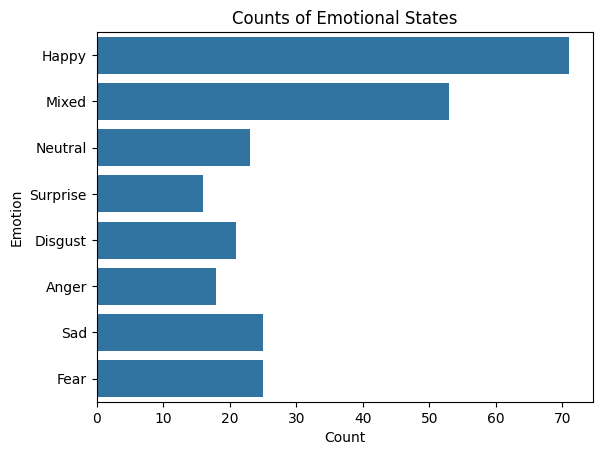

In [42]:
sns.countplot(y='emotion_ecg', data=signals_ecg)
plt.title('Counts of Emotional States')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

In [43]:
labelencoder = LabelEncoder()
y_le = to_categorical(labelencoder.fit_transform(y))

print(type(y_le))
print(y_le.shape)

<class 'numpy.ndarray'>
(252, 8)


In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_le, test_size = 0.3, random_state = 0)

In [46]:
y_le

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [47]:
arr_shape

1000

### Apply SMOTE to the training data

In [48]:
from imblearn.over_sampling import SMOTE

In [49]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [50]:
# Convert the one-hot encoded y_smote back to categorical
y_smote_count = np.argmax(y_smote, axis=1)

# Convert to pandas Series to use value_counts
y_smote_count = pd.Series(y_smote_count)

In [51]:
len(y_smote)

432

In [52]:
from tensorflow.keras.utils import to_categorical

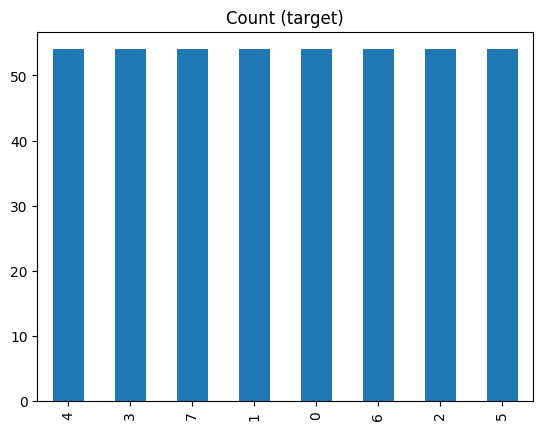

In [53]:
# Now you can use value_counts and plot
y_smote_count.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

### AUTOENCODER FOR FEATURE EXTRACTION

In [54]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [55]:
# Get the number of features (columns) in X_smote
num_features = X_smote.shape[1]

# Define the input layer with the correct shape
input_layer = Input(shape=(num_features,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)

# Encoder model for feature extraction
encoder = Model(inputs=input_layer, outputs=encoded)

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(num_features, activation='sigmoid')(decoded)

# Full Autoencoder
autoencoder_smote = Model(inputs=input_layer, outputs=decoded)

In [56]:
autoencoder_smote.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,951 (77.93 KB)

 Trainable params: 19,247 (75.18 KB)

 Non-trainable params: 704 (2.75 KB)

In [57]:
# Compile the autoencoder
adam = Adam(learning_rate=0.0001)
autoencoder_smote.compile(optimizer='adam', loss='mse')

In [58]:
# Train the autoencoder
history = autoencoder_smote.fit(X_smote, X_smote,  # autoencoder is trained to reconstruct the input data
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

# Encoder model for feature extraction
encoder_smote_model = Model(inputs = input_layer, outputs = encoded)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.9693 - val_loss: 1.1610
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7055 - val_loss: 1.0994
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6102 - val_loss: 1.0312
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6060 - val_loss: 0.9658
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5286 - val_loss: 0.9013
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4732 - val_loss: 0.8438
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5377 - val_loss: 0.7912
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5124 - val_loss: 0.7471
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5128 - val_loss: 0.7118
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4979 - val_loss: 0.6843
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4195 - val_loss: 0.6595
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [59]:
def plot_training_history(history, title='Model Training History'):
    """
    Plots the training history of a Keras model.

    Parameters:
    - history: return value from model.fit() method
    - title: string, title of the plot
    """
    
    # Plot training & validation accuracy values
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(title + ' - Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ' - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

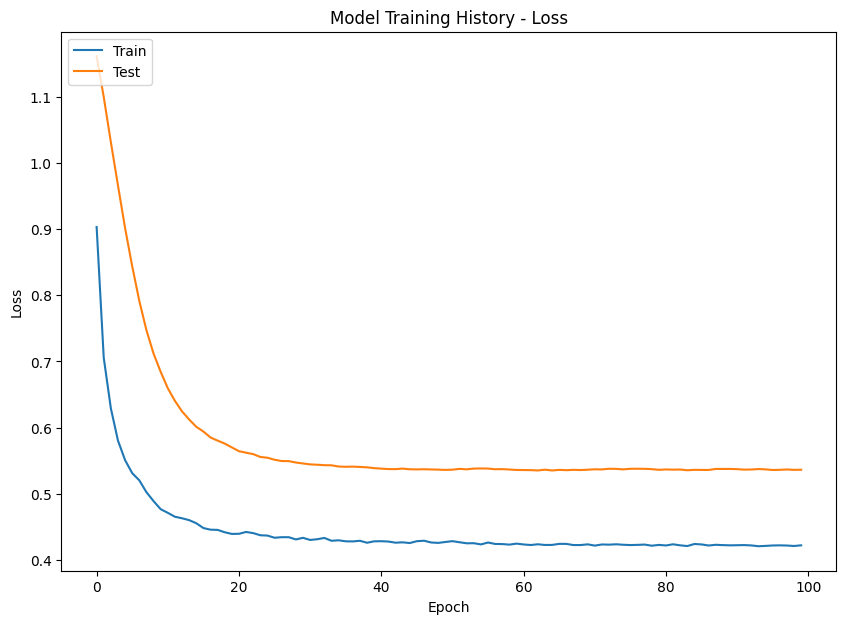

In [60]:
# Plotting the loss with its validation loss
plot_training_history(history)

In [61]:
# Use the encoder to transform the data
X_smote_encoded = encoder_smote_model.predict(X_smote)
X_test_encoded = encoder_smote_model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


### PCA ON STATISTICAL FEATURES 

In [62]:
X = signals_ecg.drop(['emotion_ecg'], axis=1)
y = signals_ecg['emotion_ecg']

In [63]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [64]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Applying SMOTE for oversampling the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [65]:
from sklearn.decomposition import PCA

In [66]:
# Applying PCA for dimensionality reduction on the SMOTE-transformed training data
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_smote_pca = pca.fit_transform(X_train_smote)

# Transforming the test data with the same PCA transformation
X_test_pca = pca.transform(X_test)

### FOURIER TRANSFORM

In [68]:
from scipy.fftpack import fft, ifft
import pywt

In [69]:
signals_df = ecg_signals.copy()

In [70]:
signals_df = signals_df[['feature_ecg', 'emotion_ecg']]
signals_df.head()

feature_ecg emotion_ecg
0  [-18.702, -18.694, -18.692, -18.678, -18.665, ...       Happy
1  [-18.702, -18.694, -18.692, -18.678, -18.665, ...       Happy
2  [-18.619, -18.624, -18.615, -18.604, -18.616, ...       Mixed
3  [-18.705, -18.669, -18.642, -18.586, -18.552, ...     Neutral
4  [-18.561, -18.561, -18.557, -18.557, -18.545, ...    Surprise

In [71]:
def apply_fourier_transform_ecg(signal):
    # Apply Fast Fourier Transform (FFT)
    fft_transform = np.fft.fft(signal)
    
    # Extract magnitude and phase
    magnitude = np.abs(fft_transform)
    phase = np.angle(fft_transform)
    
    # Return a subset of features (you can choose which ones)
    return np.concatenate([magnitude[:10], phase[:10]])  # Adjust the number as needed

In [72]:
# Apply Fourier Transform to each row in the DataFrame
feature_ecg_fft = np.array([apply_fourier_transform_ecg(arr) for arr in signals_df['feature_ecg']])

In [73]:
# Convert to DataFrame
feature_ecg_fft_df = pd.DataFrame(feature_ecg_fft, columns=[f'feature_ecg_fft_{i}' for i in range(feature_ecg_fft.shape[1])])

In [74]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals_df.drop(['feature_ecg', 'emotion_ecg'], axis=1),
               feature_ecg_fft_df], axis=1)

# Splitting the data
y = signals_df['emotion_ecg']  # Target column

In [75]:
X.columns

Index(['feature_ecg_fft_0', 'feature_ecg_fft_1', 'feature_ecg_fft_2',
       'feature_ecg_fft_3', 'feature_ecg_fft_4', 'feature_ecg_fft_5',
       'feature_ecg_fft_6', 'feature_ecg_fft_7', 'feature_ecg_fft_8',
       'feature_ecg_fft_9', 'feature_ecg_fft_10', 'feature_ecg_fft_11',
       'feature_ecg_fft_12', 'feature_ecg_fft_13', 'feature_ecg_fft_14',
       'feature_ecg_fft_15', 'feature_ecg_fft_16', 'feature_ecg_fft_17',
       'feature_ecg_fft_18', 'feature_ecg_fft_19'],
      dtype='object')

In [76]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [78]:
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_scaled, y_encoded, test_size=0.3)

#### Apply SMOTE to the training data

In [79]:
smote_fft = SMOTE(sampling_strategy='auto', random_state=42)
X_fft_smote, y_fft_smote = smote_fft.fit_resample(X_train_fft, y_train_fft)

### WAVELET TRANSFORM

In [80]:
def apply_wavelet_transform_ecg(signal, wavelet='db4', level=3):
    # Perform discrete wavelet transform
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Concatenate the approximation and detail coefficients
    features = []
    for coeff in coeffs:
        features.extend(coeff)
    
    return features[:20]  # Adjust the number as needed

In [81]:
# Apply Wavelet Transform to each row in the DataFrame
feature_ecg_wavelet = np.array([apply_wavelet_transform_ecg(arr) for arr in signals_df['feature_ecg']])

In [82]:
# Convert to DataFrame
feature_ecg_wavelet_df = pd.DataFrame(feature_ecg_wavelet, columns=[f'feature_ecg_wavelet_{i}' for i in range(feature_ecg_wavelet.shape[1])])

In [83]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals_df.drop(['feature_ecg', 'emotion_ecg'], axis=1),
               feature_ecg_wavelet_df], axis=1)

# Splitting the data
y = signals_df['emotion_ecg']  # Target column

In [84]:
X.columns

Index(['feature_ecg_wavelet_0', 'feature_ecg_wavelet_1',
       'feature_ecg_wavelet_2', 'feature_ecg_wavelet_3',
       'feature_ecg_wavelet_4', 'feature_ecg_wavelet_5',
       'feature_ecg_wavelet_6', 'feature_ecg_wavelet_7',
       'feature_ecg_wavelet_8', 'feature_ecg_wavelet_9',
       'feature_ecg_wavelet_10', 'feature_ecg_wavelet_11',
       'feature_ecg_wavelet_12', 'feature_ecg_wavelet_13',
       'feature_ecg_wavelet_14', 'feature_ecg_wavelet_15',
       'feature_ecg_wavelet_16', 'feature_ecg_wavelet_17',
       'feature_ecg_wavelet_18', 'feature_ecg_wavelet_19'],
      dtype='object')

In [85]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

In [86]:
X_train_wt, X_test_wt, y_train_wt, y_test_wt = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

#### Apply SMOTE to the training data

In [87]:
smote_wt = SMOTE(sampling_strategy='auto', random_state=42)
X_wt_smote, y_wt_smote = smote_wt.fit_resample(X_train_wt, y_train_wt)

## Define the functions going to be used for the analysis

In [88]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


The fit_and_score_models function trains multiple machine learning models, evaluates their performance on test data, and provides metrics (accuracy, precision, recall, F1 score) along with visualizations of confusion matrices of each model for comparison and analysis

In [101]:
# Define individual models
models = [
    DecisionTreeClassifier(criterion="entropy", max_depth=12),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier(n_neighbors=25)
]

In [102]:
def fit_and_score_models(models, X_train, X_test, y_train, y_test):
    fitted_models = []
    model_names = []
    training_accuracy = []
    testing_accuracy = []
    testing_precision = []
    testing_recall = []
    testing_f1 = []
    
    # Define your emotion labels
    emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Mixed', 'Neutral', 'Sad', 'Surprised']

    for model in models:
        # Fit the model on the training data
        fitted_model = model.fit(X_train, y_train)
        fitted_models.append(fitted_model)
        
        # Get the name of the model
        model_name = model.__class__.__name__
        model_names.append(model_name)

        # Predict on the training and test data
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        
        # Calculate other metrics for the test set
        test_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
        test_recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
        test_f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        
        # Append metrics
        training_accuracy.append(train_accuracy)
        testing_accuracy.append(test_accuracy)
        testing_precision.append(test_precision)
        testing_recall.append(test_recall)
        testing_f1.append(test_f1)

        # Print classification report
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred_test, labels=range(len(emotion_labels)), target_names=emotion_labels, zero_division=0))

        # Plot and display the confusion matrix
        plt.figure(figsize=(10, 8))
        conf_matrix = confusion_matrix(y_test, y_pred_test, labels=range(len(emotion_labels)))
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=emotion_labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xticks(rotation=45)
        plt.show()

    # Create a summary DataFrame
    metrics_summary = pd.DataFrame({
        'Model': model_names,
        'Training Accuracy': training_accuracy,
        'Testing Accuracy': testing_accuracy,
        'Testing Precision': testing_precision,
        'Testing Recall': testing_recall,
        'Testing F1 Score': testing_f1
    })

    return metrics_summary, fitted_models

The cross_validate_models_smote function performs Leave-One-Out cross-validation on multiple models with SMOTE-enhanced data, calculates key performance metrics, and generates confusion matrices for each model.

In [103]:
def cross_validate_models_smote(models, X_train, y_train, labels):
    cv_results = []
    loo = LeaveOneOut()

    # If y_train is one-hot encoded, convert it to label encoded
    if y_train.ndim > 1 and y_train.shape[1] > 1:
        y_train = np.argmax(y_train, axis=1)

    for model in models:
        model_name = model.__class__.__name__
        print(f"Cross-validating {model_name}...")

        # Perform Leave-One-Out cross-validation and collect predictions
        y_pred_loo = cross_val_predict(model, X_train, y_train, cv=loo)
        
        # Calculate metrics
        accuracy = accuracy_score(y_train, y_pred_loo)
        precision = precision_score(y_train, y_pred_loo, average='weighted', zero_division=0)
        recall = recall_score(y_train, y_pred_loo, average='weighted', zero_division=0)
        f1 = f1_score(y_train, y_pred_loo, average='weighted', zero_division=0)

        # Compile the results
        cv_results.append({
            'Model': model_name,
            'CV Accuracy': accuracy,
            'CV Precision': precision,
            'CV Recall': recall,
            'CV F1 Score': f1
        })

        # Print classification report and confusion matrix
        print(f"Plotting confusion matrix for {model_name}...")
        cm = confusion_matrix(y_train, y_pred_loo, labels=np.arange(len(labels)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xticks(rotation=45)
        # Save the figure
        plt.savefig(f'confusion_matrix_{model_name}.png', bbox_inches='tight')
        plt.tight_layout()
        plt.show()

    # Create a summary DataFrame from cv_results
    cv_summary = pd.DataFrame(cv_results)
    return cv_summary.sort_values(by='CV Accuracy', ascending=False)

emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Mixed', 'Neutral', 'Sad', 'Surprised']

This function takes in the results from the cross validation models and plots all the models together for comparison

In [104]:
def plot_cross_validation_results(data, save_filename, title):
    # Create a DataFrame from the provided data
    df = pd.DataFrame(data)

    # Define metrics to plot
    metrics = ["Cross Validation Mean Accuracy", "Cross Validation Mean Precision", 
               "Cross Validation Mean Recall", "Cross Validation Mean F1 Score"]

    # Plot setup
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 18), sharey=True)
    title_fontsize = 16  # Font size for titles
    axis_fontsize = 14   # Font size for axis labels and ticks

    # Plot each metric
    for ax, metric in zip(axes.flatten(), metrics):
        sns.barplot(x="Feature Extraction", y=metric, hue="Model", data=df, ax=ax)
        ax.set_title(metric, fontsize=title_fontsize)
        ax.set_xlabel(ax.get_xlabel(), fontsize=axis_fontsize)
        ax.set_ylabel(ax.get_ylabel(), fontsize=axis_fontsize)
        ax.tick_params(axis='x', labelrotation=45, labelsize=axis_fontsize)
        ax.tick_params(axis='y', labelsize=axis_fontsize)
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right', fontsize=axis_fontsize)

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.93)

    # Save the plot
    plt.savefig(save_filename)
    plt.show()

### Displaying the results for ECG signals

### Autoencoder with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.20      0.11      0.14         9
        Fear       0.33      0.33      0.33         6
       Happy       0.35      0.45      0.39        20
       Mixed       0.23      0.20      0.21        15
     Neutral       0.38      0.27      0.32        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.20      0.20      0.20         5

    accuracy                           0.26        76
   macro avg       0.24      0.22      0.23        76
weighted avg       0.27      0.26      0.26        76



<Figure size 1000x800 with 0 Axes>

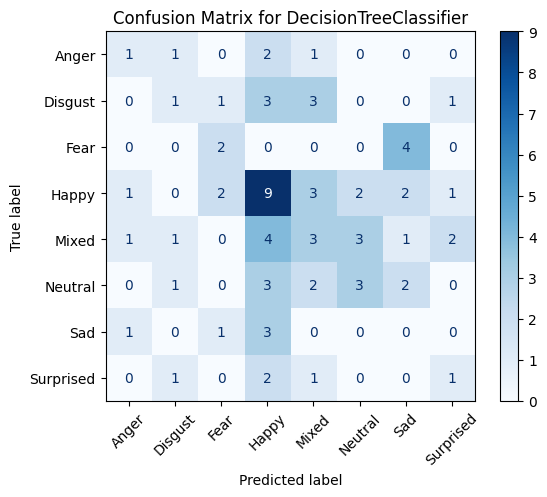

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.33      0.20      0.25         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.40      0.33      0.36         6
       Happy       0.32      0.60      0.42        20
       Mixed       0.42      0.33      0.37        15
     Neutral       0.50      0.27      0.35        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.40      0.40      0.40         5

    accuracy                           0.33        76
   macro avg       0.30      0.27      0.27        76
weighted avg       0.32      0.33      0.31        76



<Figure size 1000x800 with 0 Axes>

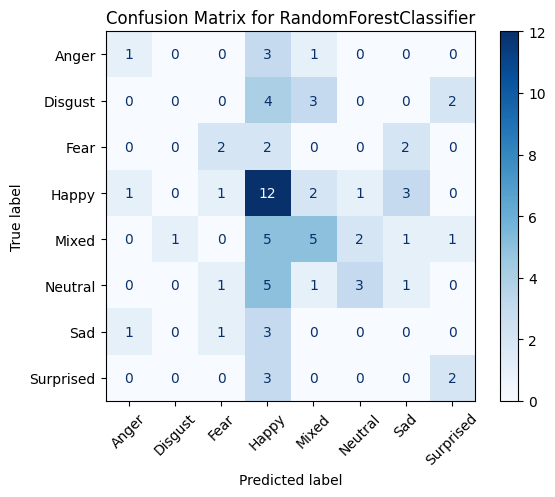

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.00      0.00      0.00         6
       Happy       0.26      0.55      0.35        20
       Mixed       0.23      0.40      0.29        15
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.22        76
   macro avg       0.06      0.12      0.08        76
weighted avg       0.11      0.22      0.15        76



<Figure size 1000x800 with 0 Axes>

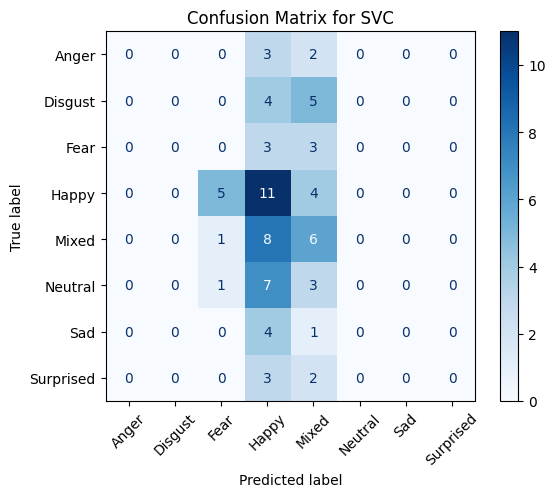

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.18      0.33      0.24         6
       Happy       0.31      0.60      0.41        20
       Mixed       0.16      0.27      0.20        15
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.25        76
   macro avg       0.21      0.17      0.15        76
weighted avg       0.19      0.25      0.19        76



<Figure size 1000x800 with 0 Axes>

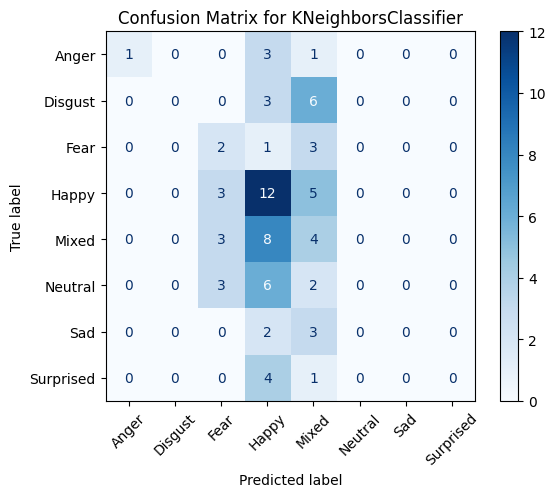

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.784091          0.263158   
 1  RandomForestClassifier           0.784091          0.328947   
 2                     SVC           0.386364          0.223684   
 3    KNeighborsClassifier           0.346591          0.250000   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.270521        0.263158          0.261985  
 1           0.319778        0.328947          0.306458  
 2           0.112866        0.223684          0.149663  
 3           0.192694        0.250000          0.187027  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25)])

In [105]:
summary_ecg_autoencoder = fit_and_score_models(models, X_train, X_test, y_train, y_test)
summary_ecg_autoencoder

### Autoencoder with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


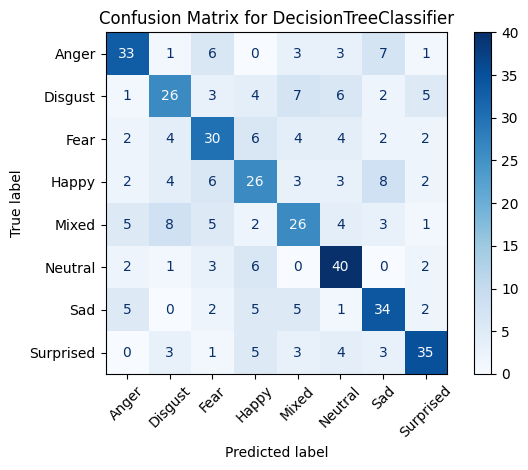

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


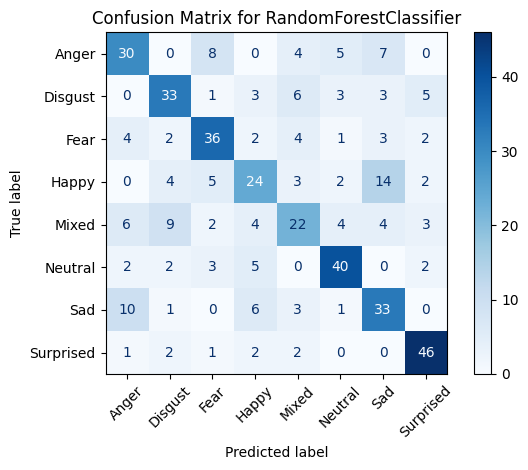

Cross-validating SVC...
Plotting confusion matrix for SVC...


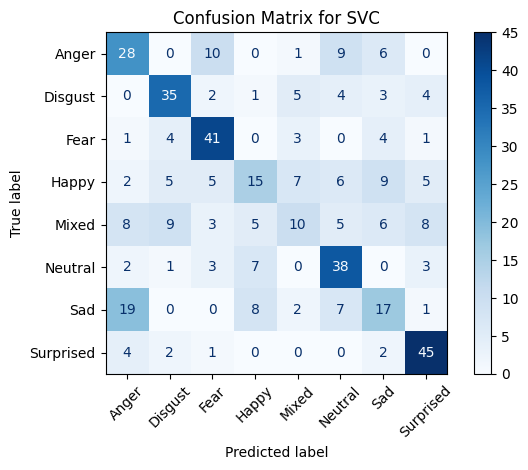

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


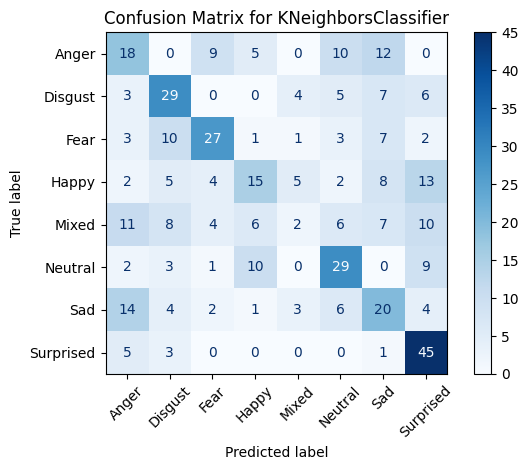

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.611111      0.606232   0.611111     0.606838
0  DecisionTreeClassifier     0.578704      0.578981   0.578704     0.577345
2                     SVC     0.530093      0.506393   0.530093     0.509447
3    KNeighborsClassifier     0.428241      0.398029   0.428241     0.402336

In [106]:
summary_smote_ecg_autoencoder = cross_validate_models_smote(models, X_smote_encoded, y_smote, emotion_labels)
summary_smote_ecg_autoencoder

### Statistical features with imbalanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


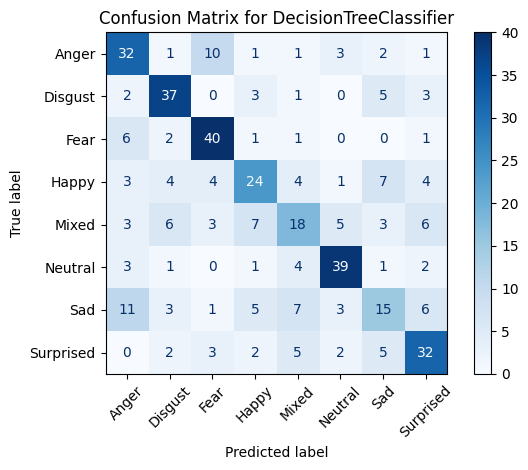

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


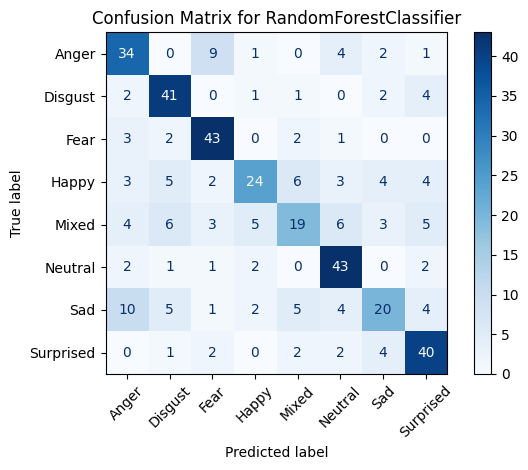

Cross-validating SVC...
Plotting confusion matrix for SVC...


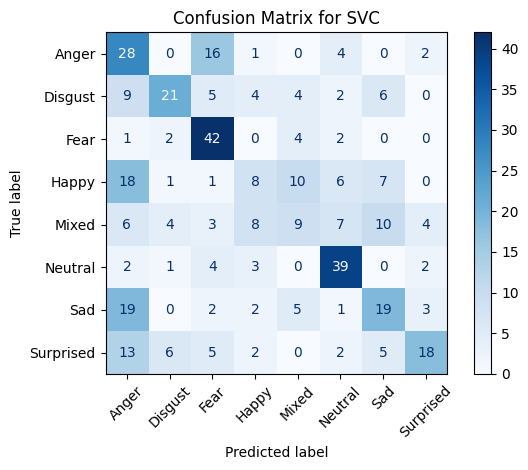

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


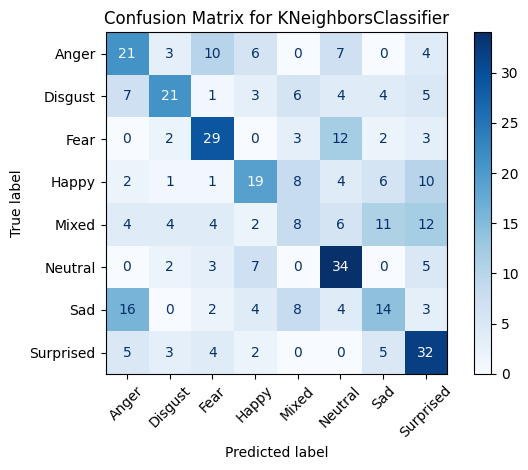

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.647059      0.639058   0.647059     0.633010
0  DecisionTreeClassifier     0.580882      0.568334   0.580882     0.571234
2                     SVC     0.450980      0.455136   0.450980     0.432732
3    KNeighborsClassifier     0.436275      0.428889   0.436275     0.424569

In [107]:
summary_pca_ecg_stats = cross_validate_models_smote(models, X_train_smote_pca, y_train_smote, emotion_labels)
summary_pca_ecg_stats

### Fourier transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.20      0.20      0.20         5
     Disgust       0.29      0.29      0.29         7
        Fear       0.42      0.56      0.48         9
       Happy       0.48      0.42      0.44        24
       Mixed       0.24      0.27      0.25        15
     Neutral       0.20      0.33      0.25         3
         Sad       0.00      0.00      0.00         8
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.30        76
   macro avg       0.23      0.26      0.24        76
weighted avg       0.29      0.30      0.30        76



<Figure size 1000x800 with 0 Axes>

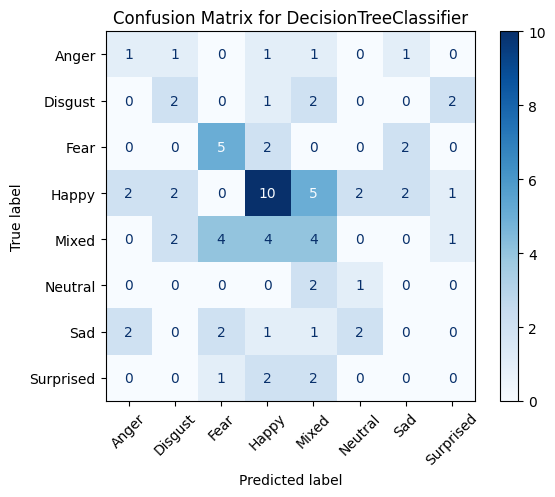

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.20      0.20      0.20         5
     Disgust       0.40      0.29      0.33         7
        Fear       0.71      0.56      0.62         9
       Happy       0.50      0.75      0.60        24
       Mixed       0.18      0.13      0.15        15
     Neutral       0.27      1.00      0.43         3
         Sad       0.00      0.00      0.00         8
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.41        76
   macro avg       0.28      0.37      0.29        76
weighted avg       0.34      0.41      0.35        76



<Figure size 1000x800 with 0 Axes>

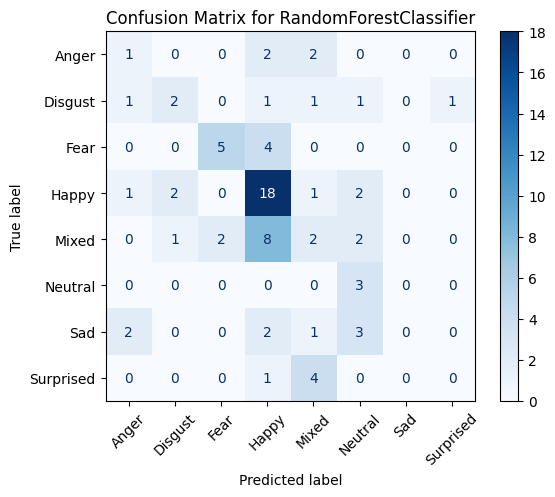

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.33      0.20      0.25         5
     Disgust       0.25      0.14      0.18         7
        Fear       0.62      0.56      0.59         9
       Happy       0.45      0.71      0.55        24
       Mixed       0.20      0.27      0.23        15
     Neutral       0.50      0.33      0.40         3
         Sad       0.00      0.00      0.00         8
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.38        76
   macro avg       0.29      0.28      0.27        76
weighted avg       0.32      0.38      0.34        76



<Figure size 1000x800 with 0 Axes>

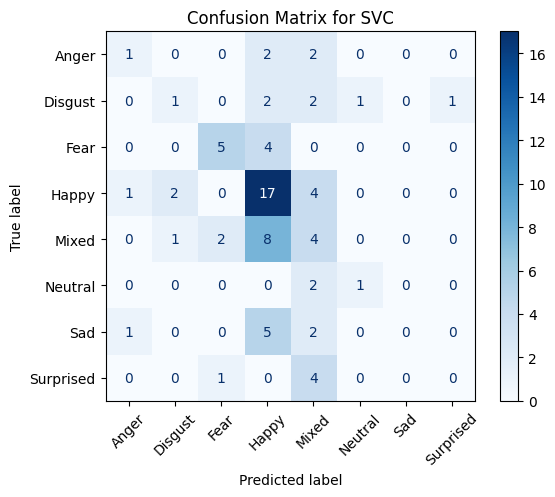

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.00      0.00      0.00         7
        Fear       0.00      0.00      0.00         9
       Happy       0.32      0.67      0.43        24
       Mixed       0.23      0.20      0.21        15
     Neutral       0.00      0.00      0.00         3
         Sad       0.00      0.00      0.00         8
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.26        76
   macro avg       0.10      0.13      0.11        76
weighted avg       0.16      0.26      0.19        76



<Figure size 1000x800 with 0 Axes>

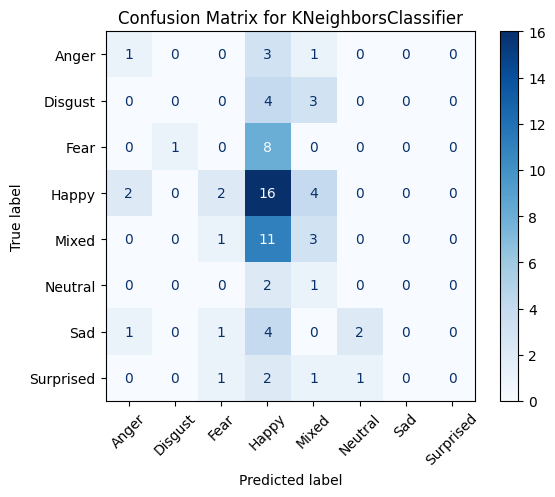

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.784091          0.302632   
 1  RandomForestClassifier           0.784091          0.407895   
 2                     SVC           0.579545          0.381579   
 3    KNeighborsClassifier           0.306818          0.263158   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.293526        0.302632          0.295426  
 1           0.339132        0.407895          0.354628  
 2           0.319454        0.381579          0.336930  
 3           0.163047        0.263158          0.193471  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25)])

In [108]:
summary_ecg_fft = fit_and_score_models(models, X_train_fft, X_test_fft, y_train_fft, y_test_fft)
summary_ecg_fft

### Fourier transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


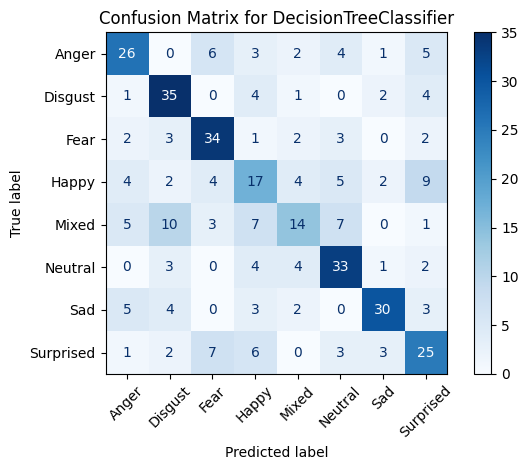

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


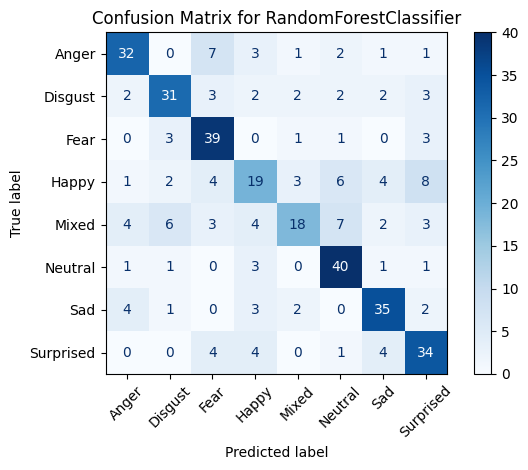

Cross-validating SVC...
Plotting confusion matrix for SVC...


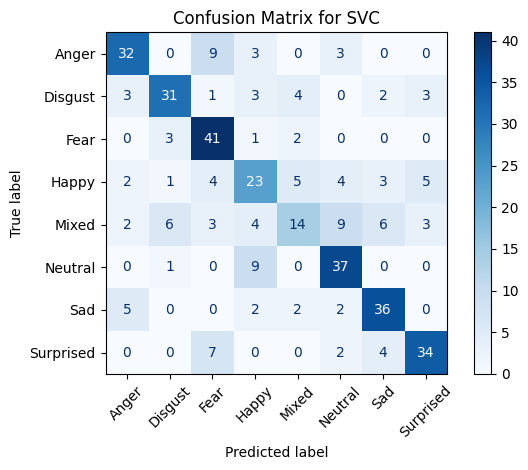

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


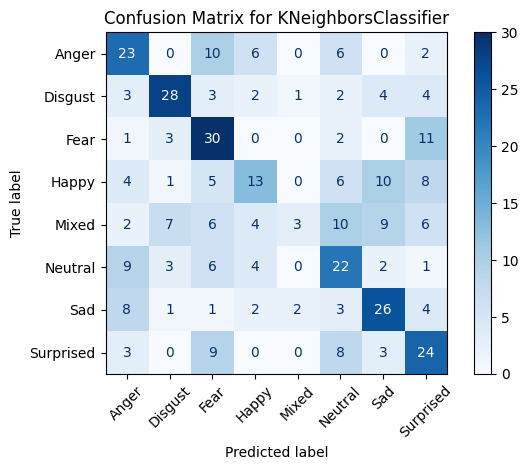

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.659574      0.657365   0.659574     0.649710
2                     SVC     0.659574      0.654541   0.659574     0.649476
0  DecisionTreeClassifier     0.569149      0.566715   0.569149     0.562250
3    KNeighborsClassifier     0.449468      0.460927   0.449468     0.427516

In [109]:
summary_smote_ecg_fft = cross_validate_models_smote(models, X_fft_smote, y_fft_smote, emotion_labels)
summary_smote_ecg_fft

### Wavelet transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.20      0.29         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.25      0.33      0.29         6
       Happy       0.32      0.50      0.39        20
       Mixed       0.27      0.20      0.23        15
     Neutral       0.44      0.36      0.40        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.10      0.20      0.13         5

    accuracy                           0.28        76
   macro avg       0.24      0.22      0.22        76
weighted avg       0.26      0.28      0.26        76



<Figure size 1000x800 with 0 Axes>

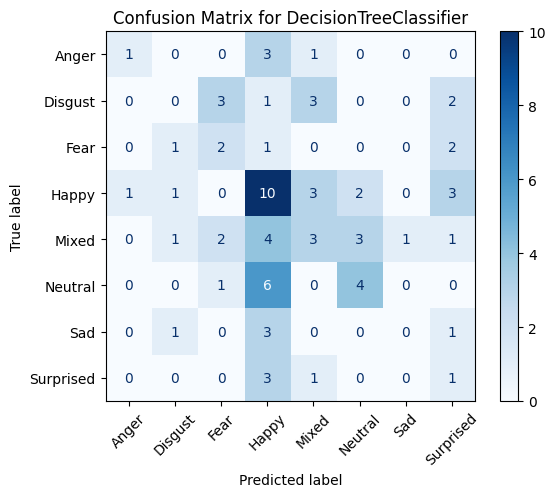

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.20      0.29         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.75      0.50      0.60         6
       Happy       0.32      0.65      0.43        20
       Mixed       0.18      0.20      0.19        15
     Neutral       0.43      0.27      0.33        11
         Sad       0.50      0.20      0.29         5
   Surprised       0.50      0.20      0.29         5

    accuracy                           0.33        76
   macro avg       0.40      0.28      0.30        76
weighted avg       0.34      0.33      0.30        76



<Figure size 1000x800 with 0 Axes>

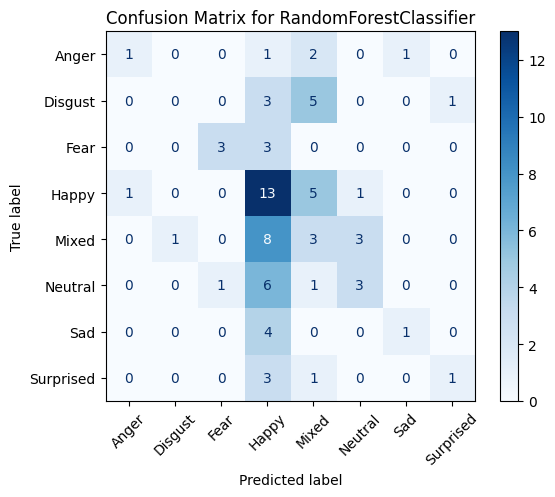

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         9
        Fear       1.00      0.33      0.50         6
       Happy       0.26      0.65      0.37        20
       Mixed       0.13      0.13      0.13        15
     Neutral       0.43      0.27      0.33        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.26        76
   macro avg       0.23      0.17      0.17        76
weighted avg       0.24      0.26      0.21        76



<Figure size 1000x800 with 0 Axes>

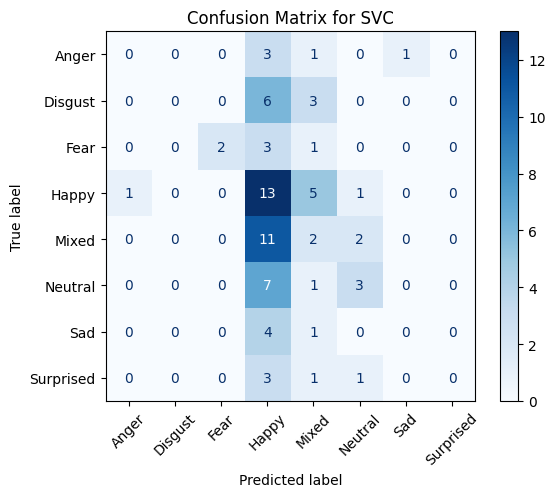

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.20      0.29         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.25      0.50      0.33         6
       Happy       0.25      0.65      0.37        20
       Mixed       0.18      0.13      0.15        15
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.25        76
   macro avg       0.15      0.19      0.14        76
weighted avg       0.16      0.25      0.17        76



<Figure size 1000x800 with 0 Axes>

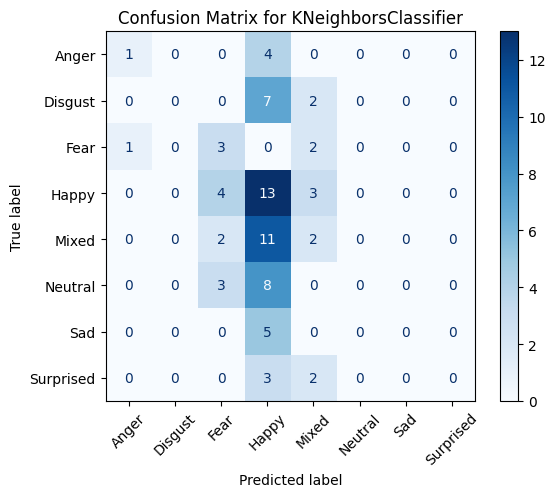

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.784091          0.276316   
 1  RandomForestClassifier           0.784091          0.328947   
 2                     SVC           0.602273          0.263158   
 3    KNeighborsClassifier           0.363636          0.250000   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.262255        0.276316          0.256766  
 1           0.338195        0.328947          0.301177  
 2           0.235714        0.263158          0.211779  
 3           0.155596        0.250000          0.171845  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25)])

In [110]:
summary_ecg_wt = fit_and_score_models(models, X_train_wt, X_test_wt, y_train_wt, y_test_wt)
summary_ecg_wt

### Wavelet transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


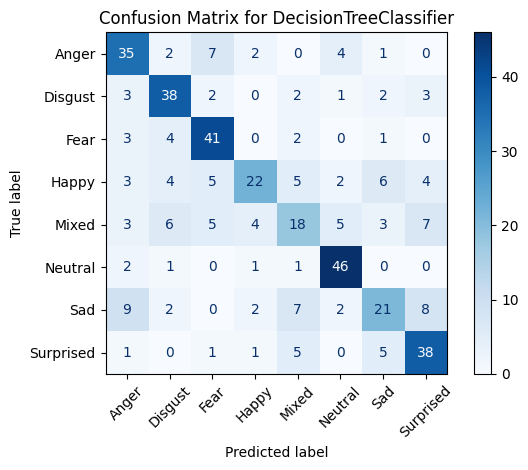

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


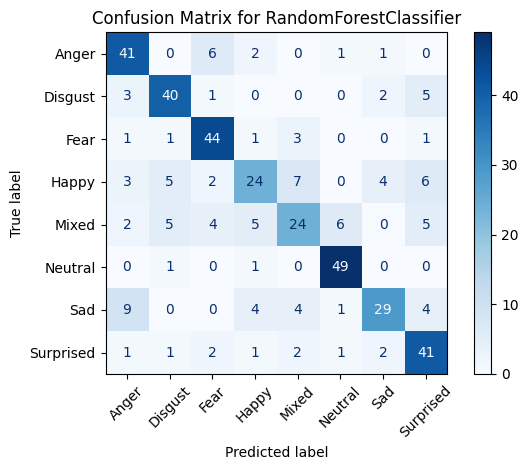

Cross-validating SVC...
Plotting confusion matrix for SVC...


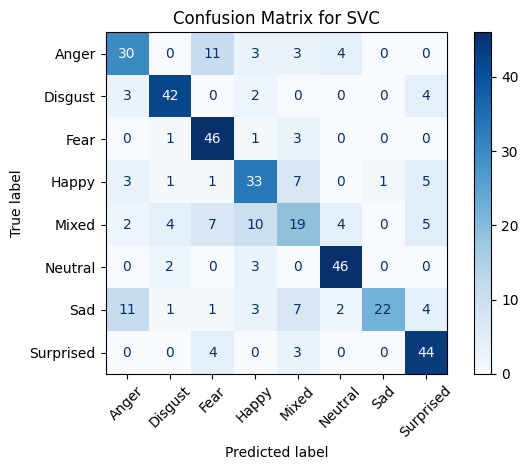

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


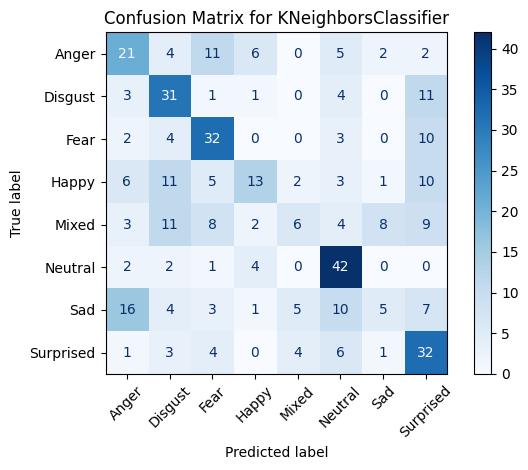

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.715686      0.710583   0.715686     0.706400
2                     SVC     0.691176      0.704116   0.691176     0.681034
0  DecisionTreeClassifier     0.634804      0.625997   0.634804     0.622264
3    KNeighborsClassifier     0.446078      0.424139   0.446078     0.407760

In [111]:
summary_smote_ecg_wt = cross_validate_models_smote(models, X_wt_smote, y_wt_smote, emotion_labels)
summary_smote_ecg_wt

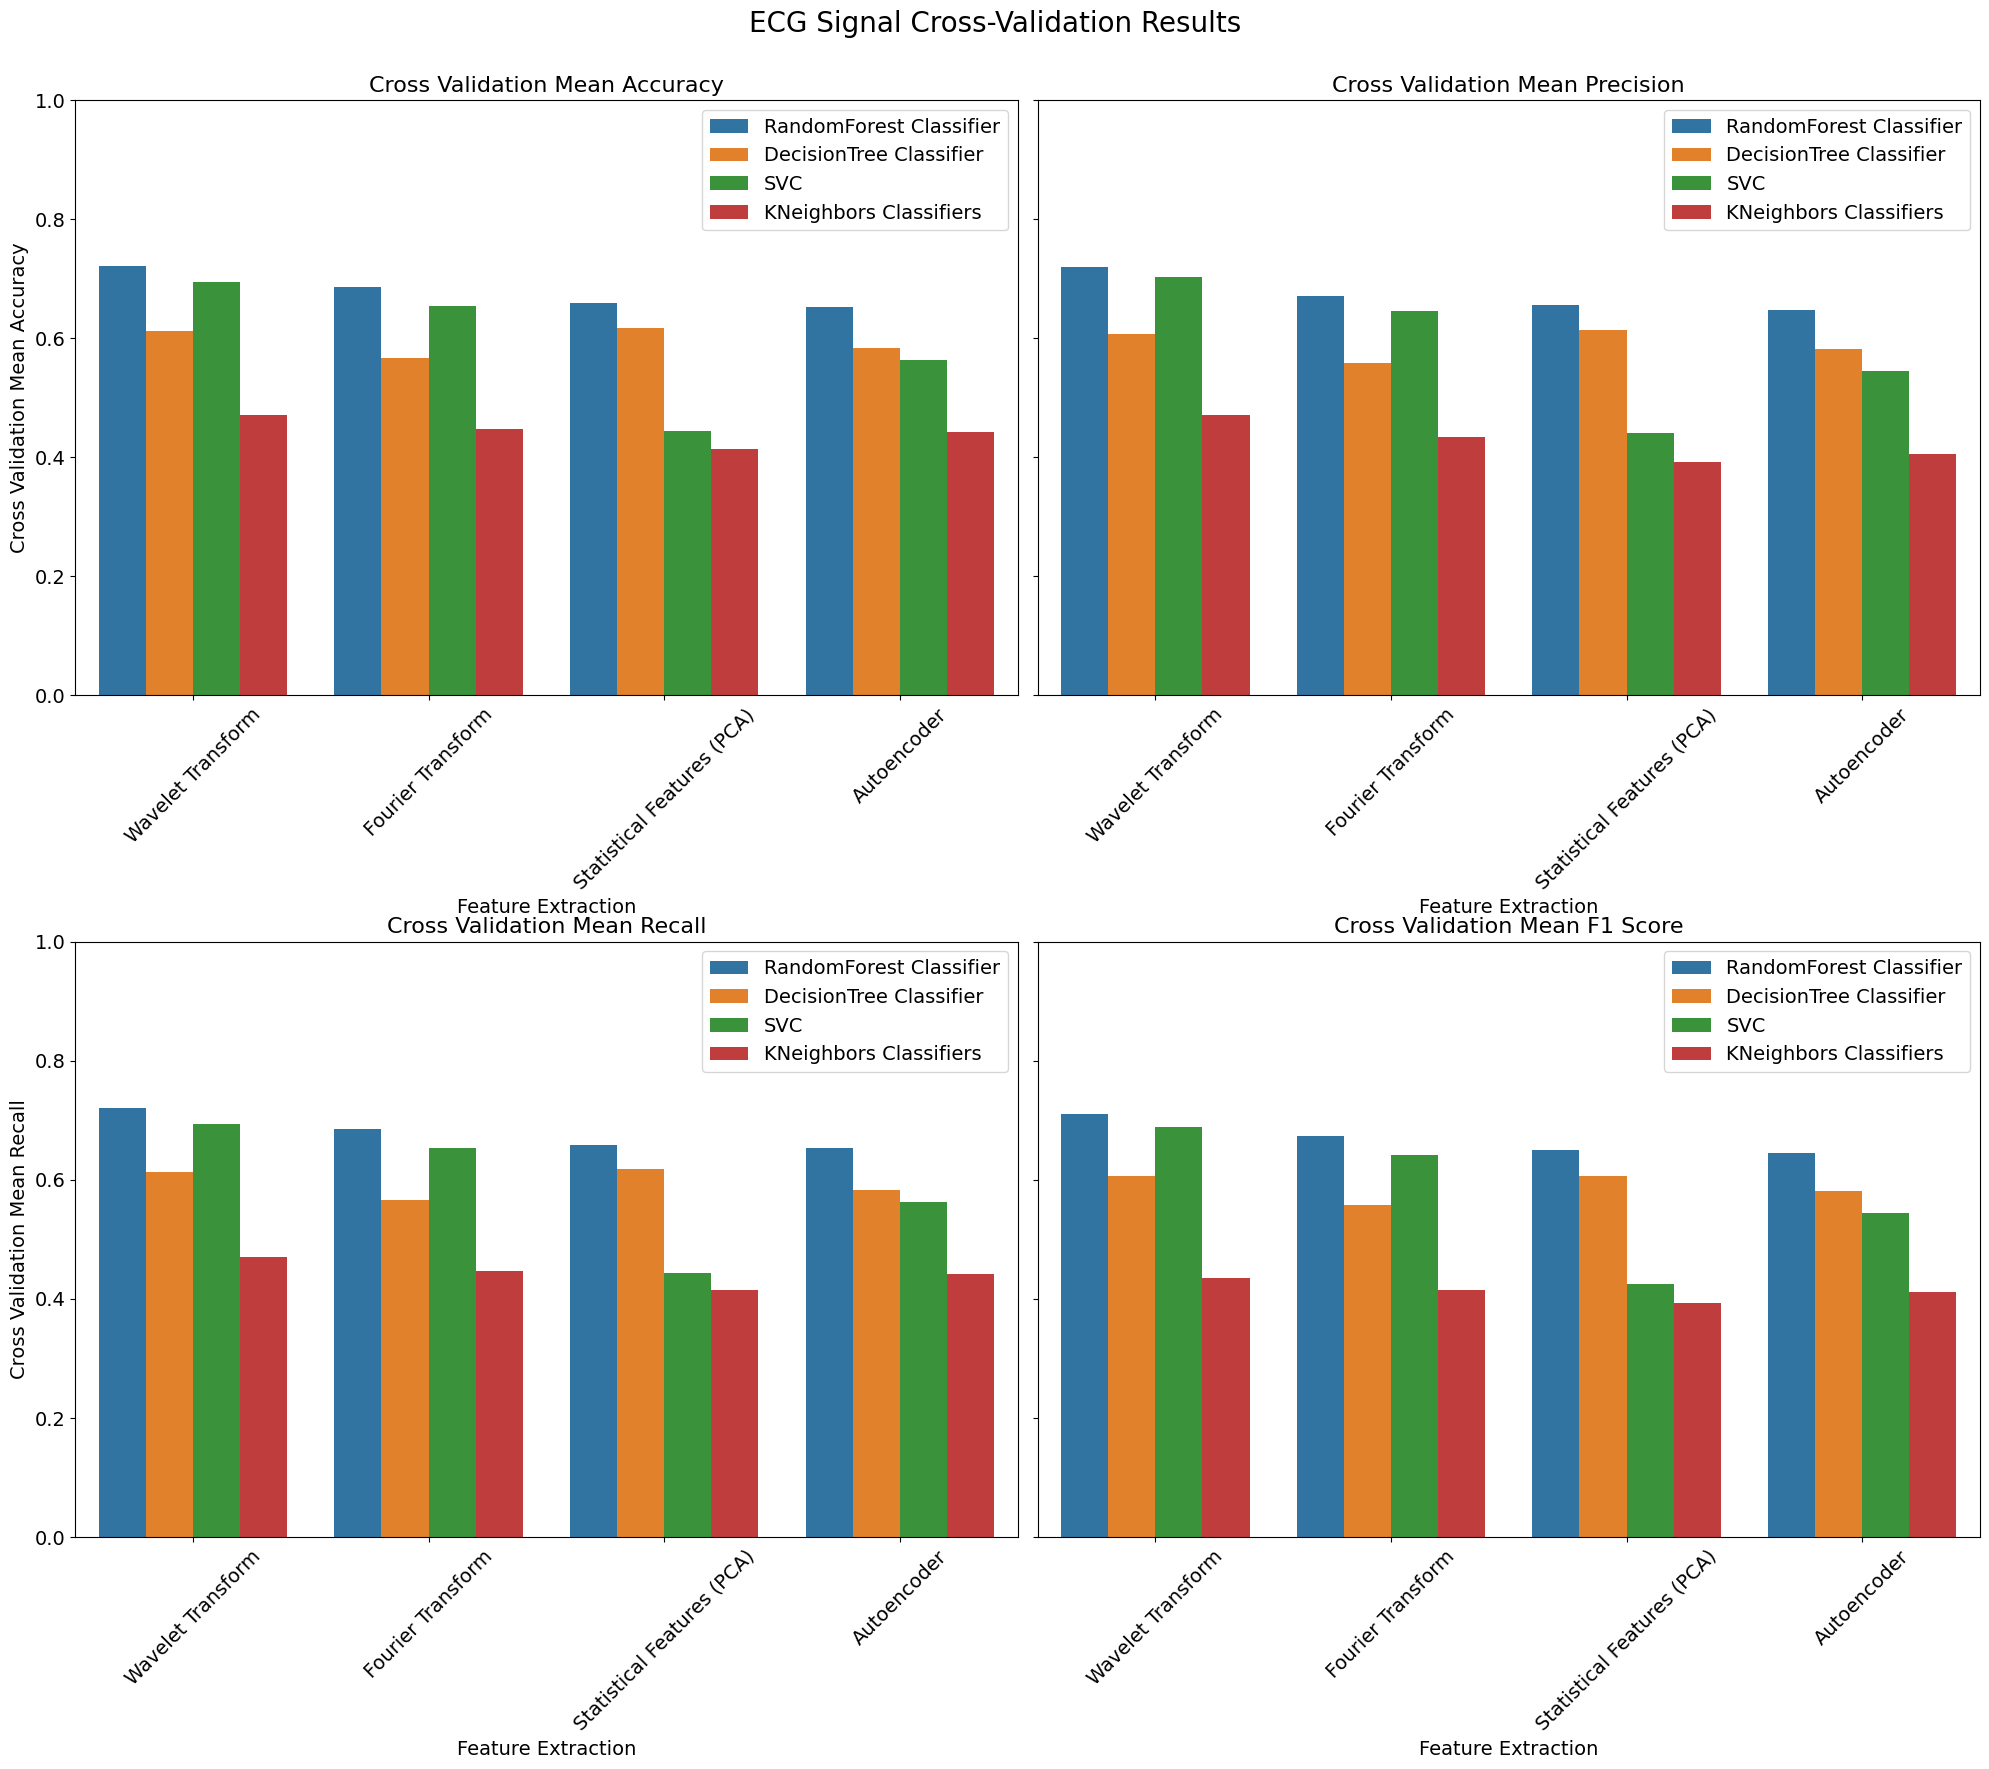

In [186]:
# Results data
data_ecg = {
    "Feature Extraction": [
        "Wavelet Transform", "Wavelet Transform", "Wavelet Transform", "Wavelet Transform",
        "Fourier Transform", "Fourier Transform", "Fourier Transform", "Fourier Transform",
        "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)",
        "Autoencoder", "Autoencoder", "Autoencoder", "Autoencoder"
    ],
    "Model": [
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers"
    ],
    "Cross Validation Mean Accuracy": [
        0.7206, 0.6127, 0.6936, 0.4706,
        0.686170, 0.566489, 0.654255, 0.446809,
        0.659314, 0.617647, 0.443627, 0.414216,
        0.652778, 0.583333, 0.562500, 0.442130
    ],
    "Cross Validation Mean Precision": [
        0.7188, 0.6075, 0.7030, 0.4707,
        0.671501, 0.558115, 0.645491, 0.433857,
        0.656371, 0.614207, 0.440270, 0.391913,
        0.647433, 0.582124, 0.544382, 0.405096
    ],
    "Cross Validation Mean Recall": [
        0.7206, 0.612745, 0.6936, 0.4706,
        0.686170, 0.566489, 0.654255, 0.446809,
        0.659314, 0.617647, 0.443627, 0.414216,
        0.652778, 0.583333, 0.562500, 0.442130
    ],
    "Cross Validation Mean F1 Score": [
        0.7110, 0.6066, 0.6880, 0.4349,
        0.674213, 0.557084, 0.642356, 0.414495,
        0.649920, 0.606530, 0.424408, 0.393140,
        0.645614, 0.581595, 0.544049, 0.411770
    ]
}


plot_cross_validation_results(data_ecg, 'results_comparison_ecg.png', "ECG Signal Cross-Validation Results")

## EXTRACT THE FEATURES FROM THE GSR SIGNALS

In [114]:
# Column order for the resulting dataframe
cols_gsr = ['Raw Data'] + list(self_annotation_multimodal.columns)
print(cols_gsr)

['Raw Data', 'Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score', 'Emotion', 'Valence', 'Arousal', 'Four_Label', 'Annotation']


In [115]:
arr_shape = 1000
raw_data_arr1 = []

def form_data_gsr(df_array = [], annotation = '', data_path = ''):
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('GSRdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p');
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = self_annotation_multimodal.loc[(self_annotation_multimodal['Session ID'] == int(s)) & 
                             (self_annotation_multimodal['Participant Id'] == int(p)) & 
                             (self_annotation_multimodal['Video ID'] == int(v)) &
                             (self_annotation_multimodal['Annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              df_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['Annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return df_array

In [117]:
raw_data_arr1 =  form_data_gsr(df_array = raw_data_arr1, annotation = 'M', data_path = "C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Stress\\ECG_GSR_Emotions\\Raw Data\\Multimodal\\GSR")

cols_gsr.append('Target Emotion')
raw_dataframe_gsr = pd.DataFrame(raw_data_arr1, columns = cols_gsr)
raw_dataframe_gsr.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe_gsr['Familiarity Score'] = raw_dataframe_gsr['Familiarity Score'].fillna('Never watched')
raw_dataframe_gsr = raw_dataframe_gsr.replace(np.nan, '', regex=True)
raw_dataframe_gsr.head()

Raw Data  Participant ID  \
0  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   
1  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   
2  [631.12, 630.95, 631.12, 630.4, 631.03, 631.04...              10   
3  [357.72, 357.43, 357.32, 357.24, 356.95, 357.0...              10   
4  [438.26, 437.83, 438.21, 438.14, 438.2, 438.15...              10   

   Session ID  Video ID Name  Age Gender  Valence level  Arousal level  \
0           1         1  S_D    8   Male              8              3   
1           1         1  S_D    8   Male              9              7   
2           1         2  S_D    8   Male              5              4   
3           1         3  S_D    8   Male              4              0   
4           1         4  S_D    8   Male              7              6   

   Dominance level  ...   Neutral  Disgust Surprised Familiarity Score  \
0                0  ...   VeryLow  VeryLow   VeryLow     Never watched   
1                0  ...   VeryLow  VeryLow   VeryLow     Never watched   
2                2  ...       Low  VeryLow       Low     Never watched   
3                0  ...  VeryHigh  VeryLow   VeryLow     Never watched   
4                0  ...   VeryLow  VeryLow  VeryHigh     Never watched   

    Emotion Valence Arousal Four label Annotation Target Emotion  
0     Happy      HV      LA       HVLA          M          happy  
1     Happy      HV      HA       HVHA          M          happy  
2     Mixed      LV      LA       LVLA          M            sad  
3   Neutral      LV      LA       LVLA          M        neutral  
4  Surprise      HV      HA       HVHA          M       surprise  

[5 rows x 24 columns]

In [118]:
gsr_dataframe = raw_dataframe_gsr.copy()
gsr_dataframe.head(2)

Raw Data  Participant ID  \
0  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   
1  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   

   Session ID  Video ID Name  Age Gender  Valence level  Arousal level  \
0           1         1  S_D    8   Male              8              3   
1           1         1  S_D    8   Male              9              7   

   Dominance level  ...  Neutral  Disgust Surprised Familiarity Score Emotion  \
0                0  ...  VeryLow  VeryLow   VeryLow     Never watched   Happy   
1                0  ...  VeryLow  VeryLow   VeryLow     Never watched   Happy   

  Valence Arousal Four label Annotation Target Emotion  
0      HV      LA       HVLA          M          happy  
1      HV      HA       HVHA          M          happy  

[2 rows x 24 columns]

In [119]:
def plot_gsr_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        try:
            plt.plot(y, label='Session {}'.format(row['Session ID']))
            plt.legend()
        except:
            plt.plot(y)
        
    plt.tight_layout()
    plt.title(title)
    plt.show()

In [120]:
def PlotGSR(df, participant_id=10, target_emotion='sad'):
    return df[(df['Participant ID']==participant_id)&(df['Target Emotion']==target_emotion)]

<Figure size 640x480 with 0 Axes>

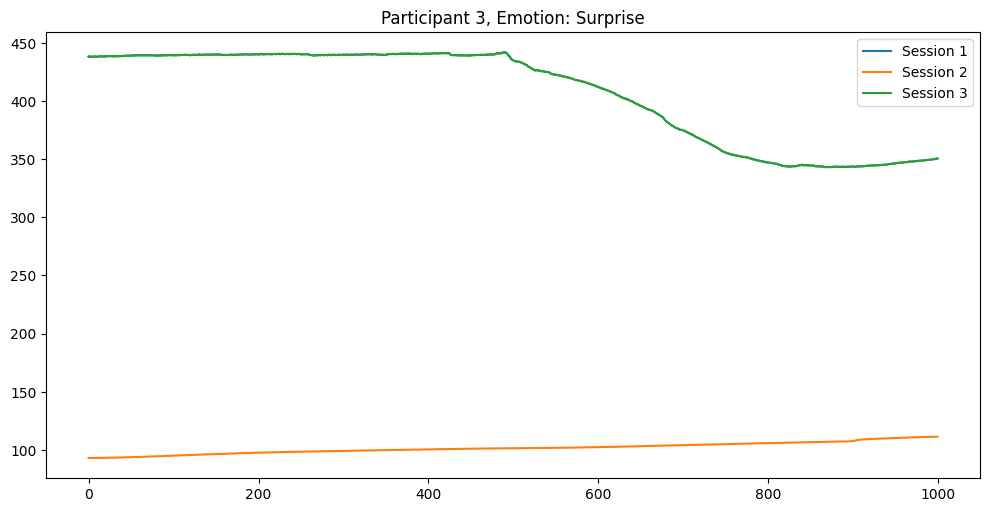

In [121]:
plot_gsr_signals(PlotGSR(gsr_dataframe, 3, 'surprise'), title='Participant 3, Emotion: Surprise')

<Figure size 640x480 with 0 Axes>

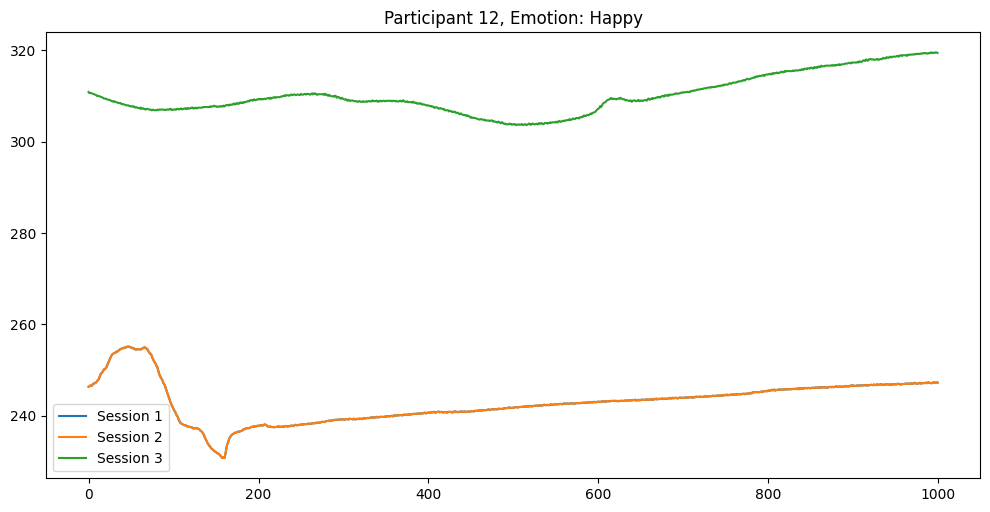

In [122]:
plot_gsr_signals(PlotGSR(gsr_dataframe, 12, 'happy'), title='Participant 12, Emotion: Happy')

In [123]:
gsr_dataframe.drop(['Video ID', 'Happy', 'Sad', 'Fear','Anger', 'Neutral', 'Disgust', 'Surprised', 
                                    'Four label', 'Session ID', 'Familiarity Score', 'Age', 
                                    'Gender', 'Name'], axis = 1).head()

Raw Data  Participant ID  \
0  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   
1  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   
2  [631.12, 630.95, 631.12, 630.4, 631.03, 631.04...              10   
3  [357.72, 357.43, 357.32, 357.24, 356.95, 357.0...              10   
4  [438.26, 437.83, 438.21, 438.14, 438.2, 438.15...              10   

   Valence level  Arousal level  Dominance level   Emotion Valence Arousal  \
0              8              3                0     Happy      HV      LA   
1              9              7                0     Happy      HV      HA   
2              5              4                2     Mixed      LV      LA   
3              4              0                0   Neutral      LV      LA   
4              7              6                0  Surprise      HV      HA   

  Annotation Target Emotion  
0          M          happy  
1          M          happy  
2          M            sad  
3          M        neutral  
4          M       surprise

In [124]:
gsr_dataframe.rename(columns = {'Raw Data':'feature_gsr', 'Emotion':'emotion_gsr'}, inplace = True)
gsr_dataframe.head(3)

feature_gsr  Participant ID  \
0  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   
1  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   
2  [631.12, 630.95, 631.12, 630.4, 631.03, 631.04...              10   

   Session ID  Video ID Name  Age Gender  Valence level  Arousal level  \
0           1         1  S_D    8   Male              8              3   
1           1         1  S_D    8   Male              9              7   
2           1         2  S_D    8   Male              5              4   

   Dominance level  ...  Neutral  Disgust Surprised Familiarity Score  \
0                0  ...  VeryLow  VeryLow   VeryLow     Never watched   
1                0  ...  VeryLow  VeryLow   VeryLow     Never watched   
2                2  ...      Low  VeryLow       Low     Never watched   

  emotion_gsr Valence Arousal Four label Annotation Target Emotion  
0       Happy      HV      LA       HVLA          M          happy  
1       Happy      HV      HA       HVHA          M          happy  
2       Mixed      LV      LA       LVLA          M            sad  

[3 rows x 24 columns]

In [125]:
gsr_signals = gsr_dataframe.copy()
gsr_signals.head()

feature_gsr  Participant ID  \
0  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   
1  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...              10   
2  [631.12, 630.95, 631.12, 630.4, 631.03, 631.04...              10   
3  [357.72, 357.43, 357.32, 357.24, 356.95, 357.0...              10   
4  [438.26, 437.83, 438.21, 438.14, 438.2, 438.15...              10   

   Session ID  Video ID Name  Age Gender  Valence level  Arousal level  \
0           1         1  S_D    8   Male              8              3   
1           1         1  S_D    8   Male              9              7   
2           1         2  S_D    8   Male              5              4   
3           1         3  S_D    8   Male              4              0   
4           1         4  S_D    8   Male              7              6   

   Dominance level  ...   Neutral  Disgust Surprised Familiarity Score  \
0                0  ...   VeryLow  VeryLow   VeryLow     Never watched   
1                0  ...   VeryLow  VeryLow   VeryLow     Never watched   
2                2  ...       Low  VeryLow       Low     Never watched   
3                0  ...  VeryHigh  VeryLow   VeryLow     Never watched   
4                0  ...   VeryLow  VeryLow  VeryHigh     Never watched   

  emotion_gsr Valence Arousal Four label Annotation Target Emotion  
0       Happy      HV      LA       HVLA          M          happy  
1       Happy      HV      HA       HVHA          M          happy  
2       Mixed      LV      LA       LVLA          M            sad  
3     Neutral      LV      LA       LVLA          M        neutral  
4    Surprise      HV      HA       HVHA          M       surprise  

[5 rows x 24 columns]

### STASTICAL FEATURES - GSR

In [126]:
gsr_signals['meanrr_gsr'] = meanrr
gsr_signals['medianrr_gsr'] = medianrr
gsr_signals['sdrr_gsr'] = sdrr
gsr_signals['rmssd_gsr'] = rmssd
gsr_signals['sdrr_rmssd_gsr'] = sdrr_rmssd
gsr_signals['hr_gsr'] = hr
gsr_signals['NNx_gsr'] = NNx
gsr_signals['pNNx_gsr'] = pNNx
gsr_signals['sd1_gsr'] = SD1
gsr_signals['sd2_gsr'] = SD2
gsr_signals['avrr_gsr'] = avrr
gsr_signals['skew_gsr'] = skew_
gsr_signals['kurt_gsr'] = kurt
gsr_signals['avrr_gsr'] = avrr
gsr_signals['csi_gsr'] = CSI
gsr_signals['modifiedcvi_gsr'] = modifiedCVI

### Filter emotion by 'Emotion' and 'Participant ID'

In [127]:
def filter_by_id_and_emotion(emotion, participant_id):
    """Filter the DataFrame based on the emotion and Participant ID."""
    filter_emotion = gsr_signals[(gsr_signals['emotion_gsr'] == emotion) & (gsr_signals['Participant ID'] == participant_id)]
    return filter_emotion

In [128]:
Surprise_1 = filter_by_id_and_emotion('Surprise', 1)
Surprise_1

feature_gsr  Participant ID  \
23   [254.98, 254.91, 255.06, 255.02, 255.05, 255.1...               1   
106  [805.45, 805.52, 805.19, 805.19, 805.75, 805.5...               1   

     Session ID  Video ID Name  Age  Gender  Valence level  Arousal level  \
23            1         2  M_M   13  Female              4              0   
106           2         2  M_M   13  Female              0              0   

     Dominance level  ...      hr_gsr NNx_gsr pNNx_gsr   sd1_gsr   sd2_gsr  \
23                 0  ...  328.141952       0      0.0  0.063467  0.320342   
106                0  ...  294.650732       1     25.0  0.051486  0.308310   

      avrr_gsr  skew_gsr   kurt_gsr   csi_gsr modifiedcvi_gsr  
23    6.871741  3.092340  14.083283  0.198123        0.050297  
106 -18.537975  3.158817  12.848869  0.166994        0.034392  

[2 rows x 39 columns]

In [129]:
signals_gsr = gsr_signals.drop(['feature_gsr', 'Participant ID', 'Session ID', 'Video ID', 'Name', 'Age',
       'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Target Emotion',
       'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Annotation',
       'Familiarity Score', 'Valence', 'Arousal', 'Four label'], axis=1)

In [130]:
signals_gsr

emotion_gsr  meanrr_gsr  medianrr_gsr  sdrr_gsr  rmssd_gsr  \
0         Happy  208.375000        209.00  0.217225   0.071985   
1         Happy  208.375000        209.00  0.217225   0.071985   
2         Mixed  209.625000        194.25  0.221027   0.072777   
3       Neutral  189.000000        186.50  0.205307   0.064151   
4      Surprise  219.500000        221.50  0.197991   0.062261   
..          ...         ...           ...       ...        ...   
247       Mixed  152.200000        153.00  0.250897   0.085570   
248    Surprise  219.500000        221.50  0.197991   0.062261   
249    Surprise  171.900000        172.00  0.249608   0.080996   
250    Surprise  174.500000        176.50  0.230885   0.076856   
251    Surprise  213.666667        213.00  0.187385   0.060258   

     sdrr_rmssd_gsr      hr_gsr  NNx_gsr  pNNx_gsr   sd1_gsr   sd2_gsr  \
0          3.017659  288.973793        0       0.0  0.050926  0.302952   
1          3.017659  288.973793        0       0.0  0.050926  0.302952   
2          3.037027  294.650732        1      25.0  0.051486  0.308310   
3          3.200358  317.593251        0       0.0  0.045385  0.286779   
4          3.180001  273.960919        0       0.0  0.044048  0.276516   
..              ...         ...      ...       ...       ...       ...   
247        2.932081  394.447092        0       0.0  0.060537  0.349620   
248        3.180001  273.960919        0       0.0  0.044048  0.276516   
249        3.081730  349.148724        0       0.0  0.057301  0.348317   
250        3.004124  344.505246        0       0.0  0.054373  0.321962   
251        3.109699  281.107955        0       0.0  0.042630  0.261550   

      avrr_gsr  skew_gsr   kurt_gsr   csi_gsr  modifiedcvi_gsr  
0   -18.766022  3.058683  12.166933  0.168100         0.034243  
1   -18.766022  3.058683  12.166933  0.168100         0.034243  
2   -18.537975  3.158817  12.848869  0.166994         0.034392  
3   -18.559574  2.862825  11.344312  0.158256         0.028730  
4   -18.488177  2.842292  11.033996  0.159295         0.028066  
..         ...       ...        ...       ...              ...  
247   3.230677  4.406868  20.993468  0.173151         0.041928  
248 -18.488177  2.842292  11.033996  0.159295         0.028066  
249   3.680474  4.123410  18.741587  0.164510         0.037707  
250   3.976598  4.280082  19.892723  0.168879         0.036730  
251 -20.368879  3.109632  13.196109  0.162991         0.027793  

[252 rows x 16 columns]

In [131]:
signals_gsr.columns

Index(['emotion_gsr', 'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr',
       'sdrr_rmssd_gsr', 'hr_gsr', 'NNx_gsr', 'pNNx_gsr', 'sd1_gsr', 'sd2_gsr',
       'avrr_gsr', 'skew_gsr', 'kurt_gsr', 'csi_gsr', 'modifiedcvi_gsr'],
      dtype='object')

In [132]:
X = signals_gsr.drop(['emotion_gsr'], axis=1)
y = signals_gsr['emotion_gsr']

In [133]:
X.head()

meanrr_gsr  medianrr_gsr  sdrr_gsr  rmssd_gsr  sdrr_rmssd_gsr      hr_gsr  \
0     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
1     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
2     209.625        194.25  0.221027   0.072777        3.037027  294.650732   
3     189.000        186.50  0.205307   0.064151        3.200358  317.593251   
4     219.500        221.50  0.197991   0.062261        3.180001  273.960919   

   NNx_gsr  pNNx_gsr   sd1_gsr   sd2_gsr   avrr_gsr  skew_gsr   kurt_gsr  \
0        0       0.0  0.050926  0.302952 -18.766022  3.058683  12.166933   
1        0       0.0  0.050926  0.302952 -18.766022  3.058683  12.166933   
2        1      25.0  0.051486  0.308310 -18.537975  3.158817  12.848869   
3        0       0.0  0.045385  0.286779 -18.559574  2.862825  11.344312   
4        0       0.0  0.044048  0.276516 -18.488177  2.842292  11.033996   

    csi_gsr  modifiedcvi_gsr  
0  0.168100         0.034243  
1  0.168100         0.034243  
2  0.166994         0.034392  
3  0.158256         0.028730  
4  0.159295         0.028066

In [134]:
y[:10]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
5     Disgust
6       Anger
7       Happy
8         Sad
9     Neutral
Name: emotion_gsr, dtype: object

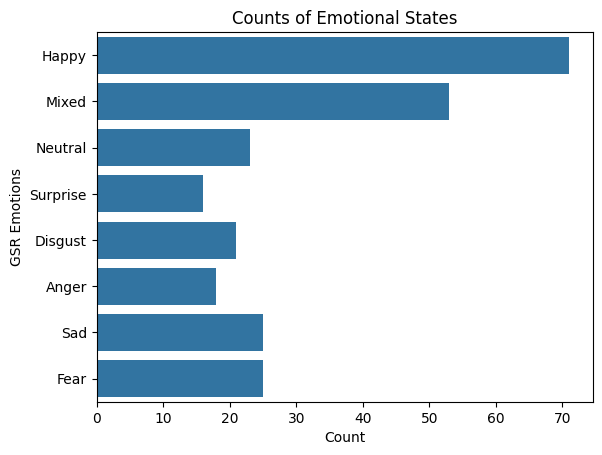

In [135]:
sns.countplot(y='emotion_gsr', data=gsr_signals)
plt.title('Counts of Emotional States')
plt.xlabel('Count')
plt.ylabel('GSR Emotions')
plt.show()

In [136]:
labelencoder = LabelEncoder()
y_le = to_categorical(labelencoder.fit_transform(y))

print(type(y_le))
print(y_le.shape)

<class 'numpy.ndarray'>
(252, 8)


In [137]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_le, test_size = 0.3, random_state = 0)

In [139]:
y_le

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [140]:
arr_shape

1000

#### Applying SMOTE to the training data

In [141]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [142]:
# Convert the one-hot encoded y_smote back to categorical
y_smote_count = np.argmax(y_smote, axis=1)

# Convert to pandas Series to use value_counts
y_smote_count = pd.Series(y_smote_count)

In [143]:
len(y_smote)

432

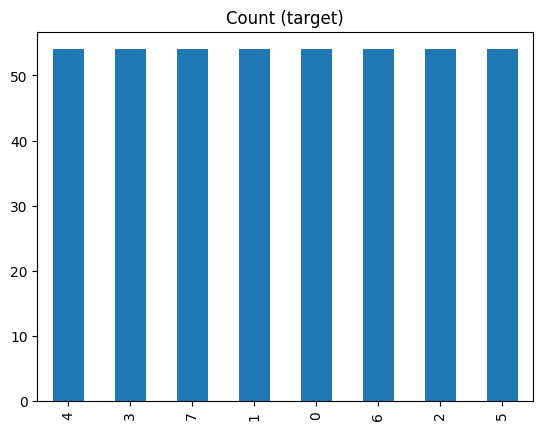

In [144]:
# Now you can use value_counts and plot
y_smote_count.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

### AUTOENCODER FOR FEATURE EXTRACTION

In [145]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [146]:
# Get the number of features (columns) in X_smote
num_features = X_smote.shape[1]

# Define the input layer with the correct shape
input_layer = Input(shape=(num_features,))

# input_layer = Input(shape=(X_train_encoder[1],))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)

# Encoder model for feature extraction
encoder = Model(inputs=input_layer, outputs=encoded)

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(num_features, activation='sigmoid')(decoded)

# Full Autoencoder
autoencoder_smote = Model(inputs=input_layer, outputs=decoded)

In [147]:
autoencoder_smote.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,951 (77.93 KB)

 Trainable params: 19,247 (75.18 KB)

 Non-trainable params: 704 (2.75 KB)

In [148]:
# Compile the autoencoder
adam = Adam(learning_rate=0.0001)
autoencoder_smote.compile(optimizer='adam', loss='mse')

In [149]:
# Train the autoencoder
history = autoencoder_smote.fit(X_smote, X_smote,  # autoencoder is trained to reconstruct the input data
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

# Encoder model for feature extraction
encoder_smote_model = Model(inputs = input_layer, outputs = encoded)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9706 - val_loss: 1.1673
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7430 - val_loss: 1.1119
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6353 - val_loss: 1.0495
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5711 - val_loss: 0.9851
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6015 - val_loss: 0.9219
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5489 - val_loss: 0.8643
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4747 - val_loss: 0.8111
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4808 - val_loss: 0.7662
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5307 - val_loss: 0.7306
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4547 - val_loss: 0.6991
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4691 - val_loss: 0.6747
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

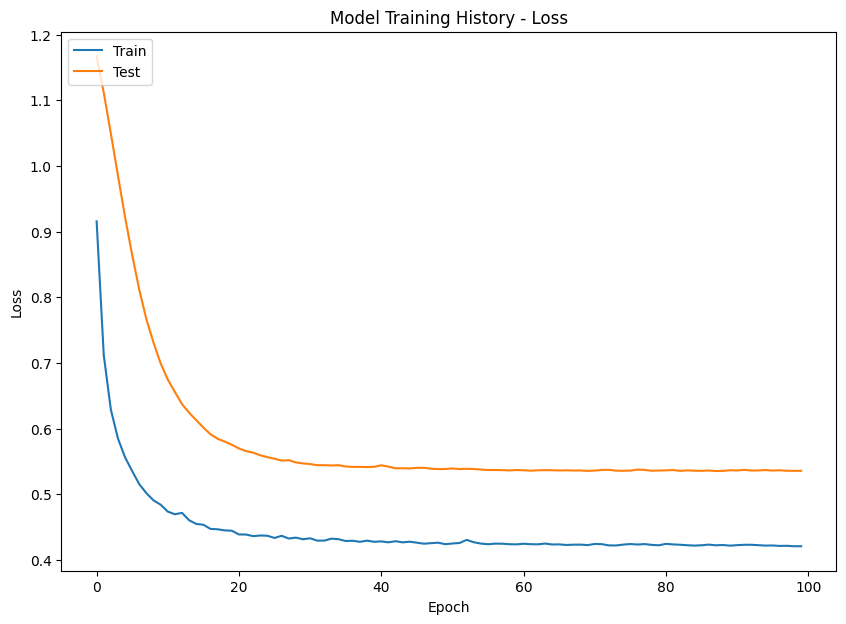

In [150]:
# Plotting the loss with its validation loss
plot_training_history(history)

In [151]:
# Use the encoder to transform the data
X_smote_encoded = encoder_smote_model.predict(X_smote)
X_test_encoded = encoder_smote_model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [152]:
len(X_test_encoded)

76

In [153]:
len(X_test)

76

### PCA ON STATISTICAL FEATURES

In [154]:
from sklearn.decomposition import PCA

In [155]:
X = signals_gsr.drop(['emotion_gsr'], axis=1)
y = signals_gsr['emotion_gsr']

In [156]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [157]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Applying SMOTE for oversampling the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [158]:
# Applying PCA for dimensionality reduction on the SMOTE-transformed training data
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_smote_pca = pca.fit_transform(X_train_smote)

# Transforming the test data with the same PCA transformation
X_test_pca = pca.transform(X_test)

### FOURIER TRANSFORM

In [159]:
signals_data = gsr_signals.copy()

In [160]:
signals_data = signals_data[['feature_gsr', 'emotion_gsr']]
signals_data.head()

feature_gsr emotion_gsr
0  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...       Happy
1  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...       Happy
2  [631.12, 630.95, 631.12, 630.4, 631.03, 631.04...       Mixed
3  [357.72, 357.43, 357.32, 357.24, 356.95, 357.0...     Neutral
4  [438.26, 437.83, 438.21, 438.14, 438.2, 438.15...    Surprise

In [161]:
def apply_fourier_transform_gsr(signal):
    # Apply Fast Fourier Transform (FFT)
    fft_transform = np.fft.fft(signal)
    
    # Extract magnitude and phase
    magnitude = np.abs(fft_transform)
    phase = np.angle(fft_transform)
    
    # Return a subset of features (you can choose which ones)
    return np.concatenate([magnitude[:10], phase[:10]])  # Adjust the number as needed

In [162]:
# Apply Fourier Transform to each row in the DataFrame
feature_gsr_fft = np.array([apply_fourier_transform_gsr(arr) for arr in signals_data['feature_gsr']])

In [163]:
# Convert to DataFrame
feature_gsr_fft_df = pd.DataFrame(feature_gsr_fft, columns=[f'feature_gsr_fft_{i}' for i in range(feature_ecg_fft.shape[1])])

In [164]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals_data.drop(['feature_gsr', 'emotion_gsr'], axis=1),
               feature_gsr_fft_df], axis=1)

# Splitting the data
y = signals_data['emotion_gsr']  # Target column

In [165]:
X.columns

Index(['feature_gsr_fft_0', 'feature_gsr_fft_1', 'feature_gsr_fft_2',
       'feature_gsr_fft_3', 'feature_gsr_fft_4', 'feature_gsr_fft_5',
       'feature_gsr_fft_6', 'feature_gsr_fft_7', 'feature_gsr_fft_8',
       'feature_gsr_fft_9', 'feature_gsr_fft_10', 'feature_gsr_fft_11',
       'feature_gsr_fft_12', 'feature_gsr_fft_13', 'feature_gsr_fft_14',
       'feature_gsr_fft_15', 'feature_gsr_fft_16', 'feature_gsr_fft_17',
       'feature_gsr_fft_18', 'feature_gsr_fft_19'],
      dtype='object')

In [166]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_gsr, dtype: object

In [167]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [168]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [169]:
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_scaled, y_encoded, test_size=0.3)

#### Applying SMOTE to training data

In [170]:
smote_fft = SMOTE(sampling_strategy='auto', random_state=42)
X_fft_smote, y_fft_smote = smote_fft.fit_resample(X_train_fft, y_train_fft)

### WAVELET TRANSFORM

In [171]:
def apply_wavelet_transform_gsr(signal, wavelet='db4', level=3):
    # Perform discrete wavelet transform
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Concatenate the approximation and detail coefficients
    features = []
    for coeff in coeffs:
        features.extend(coeff)
    
    return features[:20]  # Adjust the number as needed

In [172]:
# Apply Wavelet Transform to each row in the DataFrame
feature_gsr_wavelet = np.array([apply_wavelet_transform_gsr(arr) for arr in signals_data['feature_gsr']])

In [173]:
# Convert to DataFrame
feature_gsr_wavelet_df = pd.DataFrame(feature_gsr_wavelet, columns=[f'feature_gsr_wavelet_{i}' for i in range(feature_gsr_wavelet.shape[1])])

In [174]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals_data.drop(['feature_gsr', 'emotion_gsr'], axis=1),
               feature_gsr_wavelet_df], axis=1)

# Splitting the data
y = signals_data['emotion_gsr']  # Target column

In [175]:
X.columns

Index(['feature_gsr_wavelet_0', 'feature_gsr_wavelet_1',
       'feature_gsr_wavelet_2', 'feature_gsr_wavelet_3',
       'feature_gsr_wavelet_4', 'feature_gsr_wavelet_5',
       'feature_gsr_wavelet_6', 'feature_gsr_wavelet_7',
       'feature_gsr_wavelet_8', 'feature_gsr_wavelet_9',
       'feature_gsr_wavelet_10', 'feature_gsr_wavelet_11',
       'feature_gsr_wavelet_12', 'feature_gsr_wavelet_13',
       'feature_gsr_wavelet_14', 'feature_gsr_wavelet_15',
       'feature_gsr_wavelet_16', 'feature_gsr_wavelet_17',
       'feature_gsr_wavelet_18', 'feature_gsr_wavelet_19'],
      dtype='object')

In [176]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_gsr, dtype: object

In [177]:
X_train_wt, X_test_wt, y_train_wt, y_test_wt = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

#### Applying SMOTE to training data

In [178]:
smote_wt = SMOTE(sampling_strategy='auto', random_state=42)
X_wt_smote, y_wt_smote = smote_wt.fit_resample(X_train_wt, y_train_wt)

### Displaying the results for GSR signals

### Autoencoder with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.33      0.33      0.33         6
       Happy       0.33      0.40      0.36        20
       Mixed       0.21      0.20      0.21        15
     Neutral       0.27      0.27      0.27        11
         Sad       0.11      0.20      0.14         5
   Surprised       0.20      0.20      0.20         5

    accuracy                           0.25        76
   macro avg       0.21      0.23      0.22        76
weighted avg       0.23      0.25      0.24        76



<Figure size 1000x800 with 0 Axes>

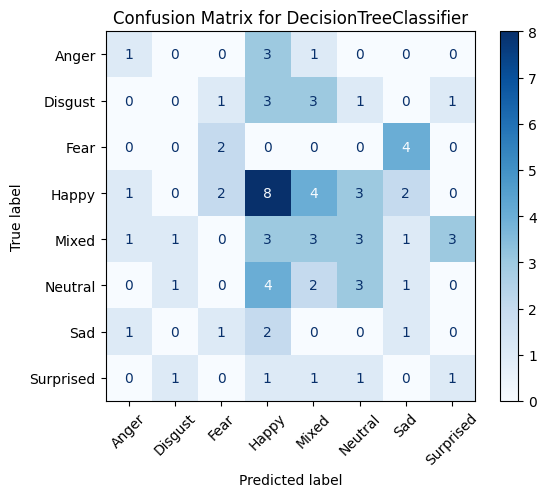

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.33      0.33      0.33         6
       Happy       0.35      0.60      0.44        20
       Mixed       0.31      0.27      0.29        15
     Neutral       0.50      0.27      0.35        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.40      0.40      0.40         5

    accuracy                           0.32        76
   macro avg       0.27      0.26      0.25        76
weighted avg       0.30      0.32      0.29        76



<Figure size 1000x800 with 0 Axes>

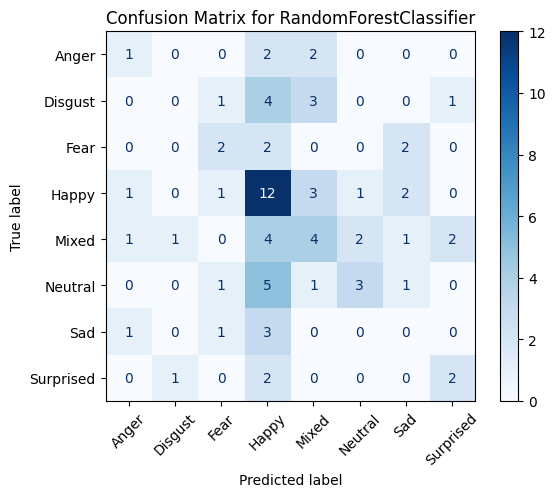

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.00      0.00      0.00         6
       Happy       0.26      0.55      0.35        20
       Mixed       0.23      0.40      0.29        15
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.22        76
   macro avg       0.06      0.12      0.08        76
weighted avg       0.11      0.22      0.15        76



<Figure size 1000x800 with 0 Axes>

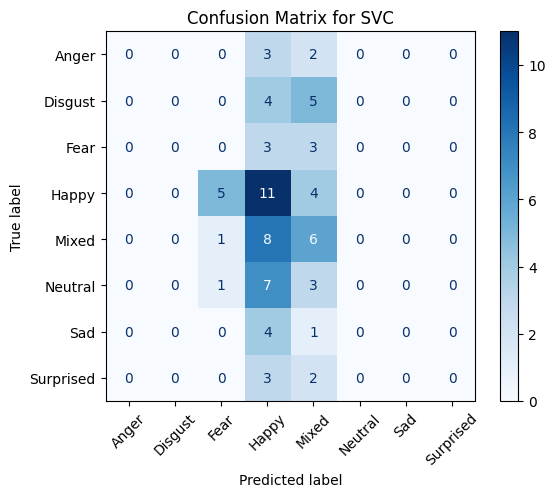

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.18      0.33      0.24         6
       Happy       0.31      0.60      0.41        20
       Mixed       0.16      0.27      0.20        15
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.25        76
   macro avg       0.21      0.17      0.15        76
weighted avg       0.19      0.25      0.19        76



<Figure size 1000x800 with 0 Axes>

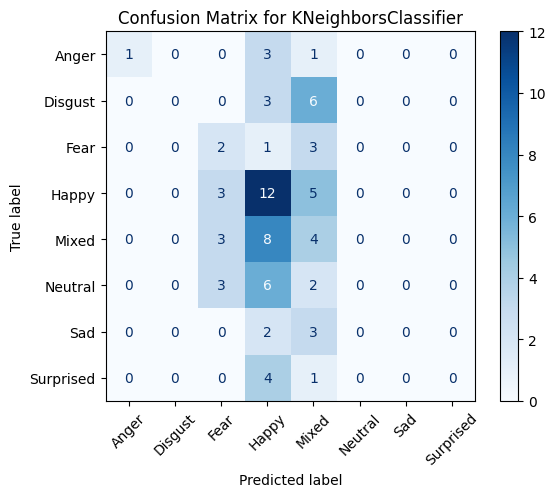

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.784091          0.250000   
 1  RandomForestClassifier           0.784091          0.315789   
 2                     SVC           0.386364          0.223684   
 3    KNeighborsClassifier           0.346591          0.250000   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.232717        0.250000          0.239494  
 1           0.295055        0.315789          0.291685  
 2           0.112866        0.223684          0.149663  
 3           0.192694        0.250000          0.187027  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25)])

In [179]:
summary_gsr_autoencoder = fit_and_score_models(models, X_train, X_test, y_train, y_test)
summary_gsr_autoencoder

### Autoencoder with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


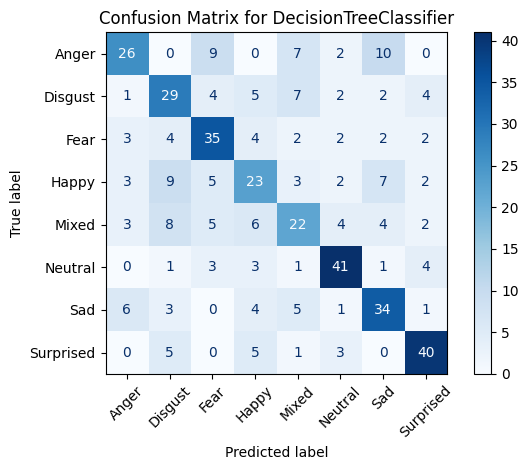

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


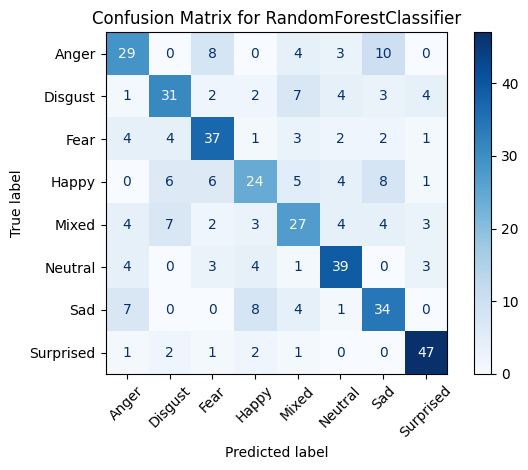

Cross-validating SVC...
Plotting confusion matrix for SVC...


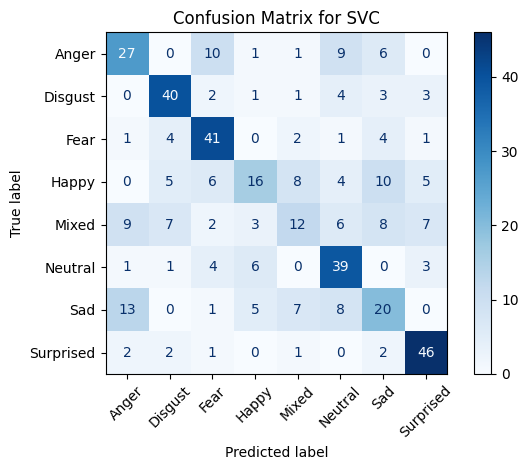

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


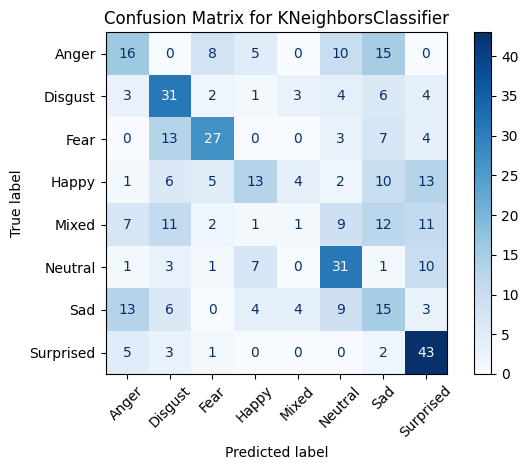

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.620370      0.616250   0.620370     0.616726
0  DecisionTreeClassifier     0.578704      0.576989   0.578704     0.575811
2                     SVC     0.557870      0.538586   0.557870     0.539053
3    KNeighborsClassifier     0.409722      0.378404   0.409722     0.380513

In [180]:
summary_smote_gsr_autoencoder = cross_validate_models_smote(models, X_smote_encoded, y_smote, emotion_labels)
summary_smote_gsr_autoencoder

### Statistical features with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.29      0.50      0.36         4
     Disgust       0.27      0.75      0.40         4
        Fear       1.00      0.71      0.83         7
       Happy       0.49      0.77      0.60        22
       Mixed       0.33      0.19      0.24        16
     Neutral       0.00      0.00      0.00         8
         Sad       0.60      0.30      0.40        10
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.43        76
   macro avg       0.37      0.40      0.35        76
weighted avg       0.41      0.43      0.39        76



<Figure size 1000x800 with 0 Axes>

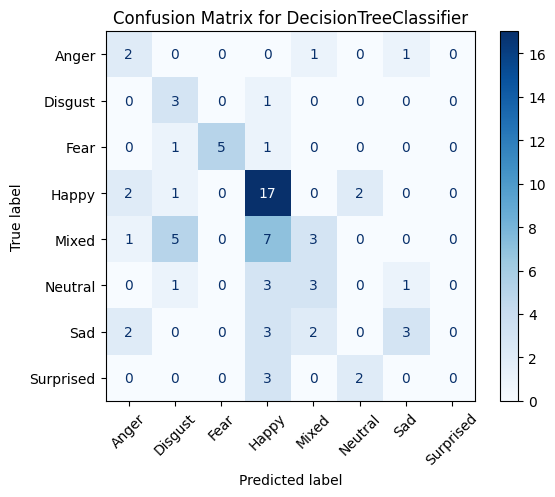

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.29      0.50      0.36         4
     Disgust       0.27      0.75      0.40         4
        Fear       1.00      0.43      0.60         7
       Happy       0.47      0.77      0.59        22
       Mixed       0.27      0.19      0.22        16
     Neutral       0.00      0.00      0.00         8
         Sad       0.60      0.30      0.40        10
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.41        76
   macro avg       0.36      0.37      0.32        76
weighted avg       0.39      0.41      0.36        76



<Figure size 1000x800 with 0 Axes>

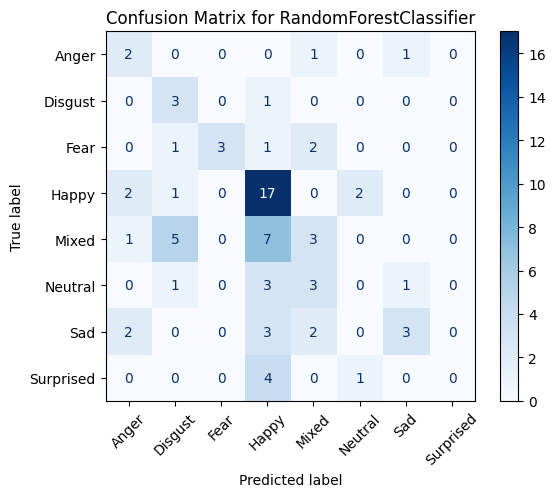

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.29      0.50      0.36         4
     Disgust       0.27      0.75      0.40         4
        Fear       1.00      0.43      0.60         7
       Happy       0.45      0.77      0.57        22
       Mixed       0.27      0.19      0.22        16
     Neutral       0.00      0.00      0.00         8
         Sad       0.67      0.20      0.31        10
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.39        76
   macro avg       0.37      0.35      0.31        76
weighted avg       0.40      0.39      0.35        76



<Figure size 1000x800 with 0 Axes>

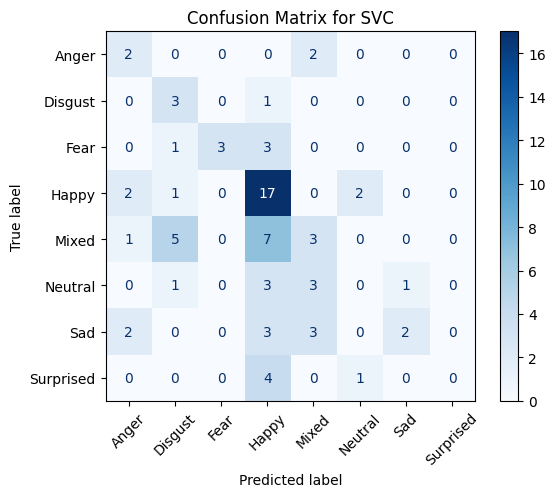

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         4
     Disgust       0.27      0.75      0.40         4
        Fear       0.31      0.71      0.43         7
       Happy       0.38      0.73      0.50        22
       Mixed       0.14      0.06      0.09        16
     Neutral       0.00      0.00      0.00         8
         Sad       0.00      0.00      0.00        10
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.33        76
   macro avg       0.14      0.28      0.18        76
weighted avg       0.18      0.33      0.22        76



<Figure size 1000x800 with 0 Axes>

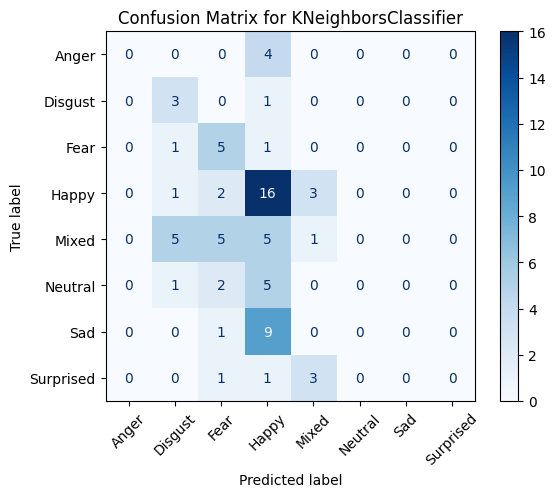

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.539773          0.434211   
 1  RandomForestClassifier           0.539773          0.407895   
 2                     SVC           0.477273          0.394737   
 3    KNeighborsClassifier           0.357955          0.328947   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.411221        0.434211          0.392772  
 1           0.394556        0.407895          0.364561  
 2           0.396134        0.394737          0.346759  
 3           0.183488        0.328947          0.224142  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25)])

In [181]:
summary_gsr_fft = fit_and_score_models(models, X_train_fft, X_test_fft, y_train_fft, y_test_fft)
summary_gsr_fft

### Statistical features (PCA) with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


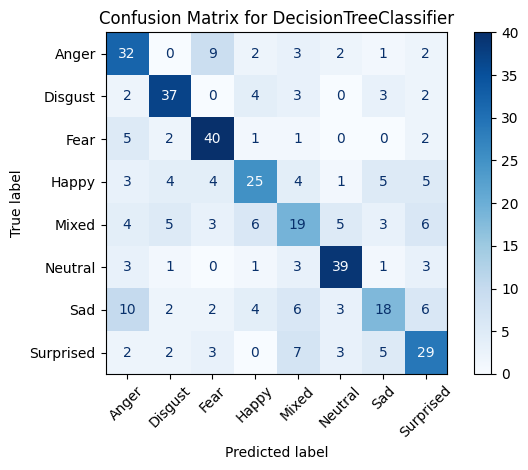

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


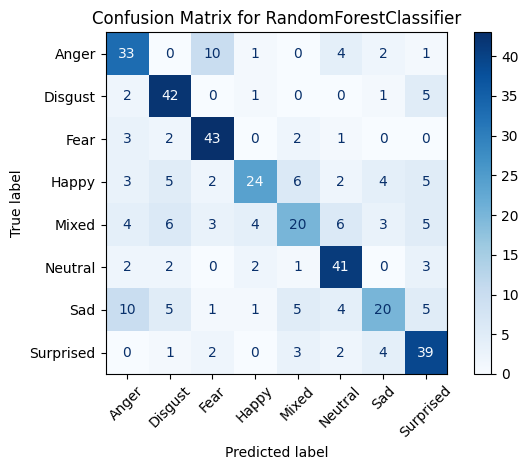

Cross-validating SVC...
Plotting confusion matrix for SVC...


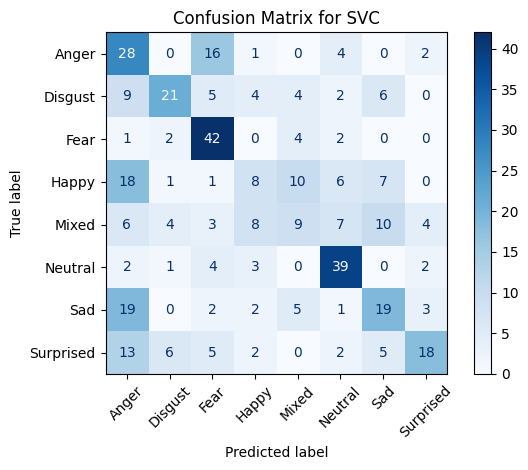

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


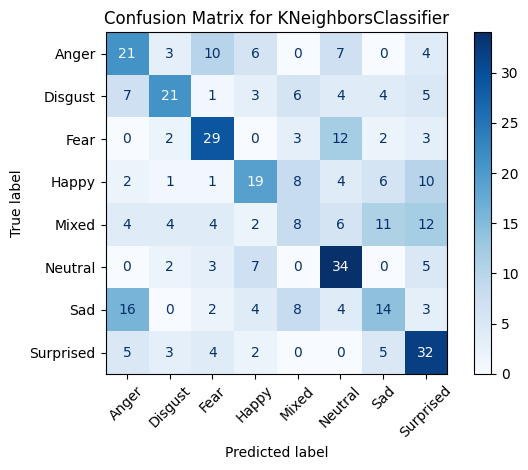

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.642157      0.638620   0.642157     0.629415
0  DecisionTreeClassifier     0.585784      0.579500   0.585784     0.578985
2                     SVC     0.450980      0.455136   0.450980     0.432732
3    KNeighborsClassifier     0.436275      0.428889   0.436275     0.424569

In [182]:
summary_pca_gsr_stats = cross_validate_models_smote(models, X_train_smote_pca, y_train_smote, emotion_labels)
summary_pca_gsr_stats

### Fourier transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


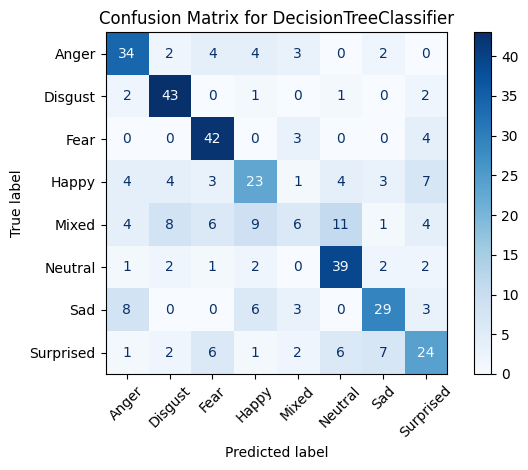

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


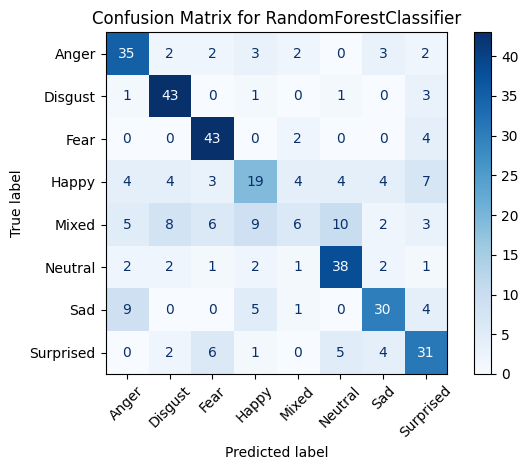

Cross-validating SVC...
Plotting confusion matrix for SVC...


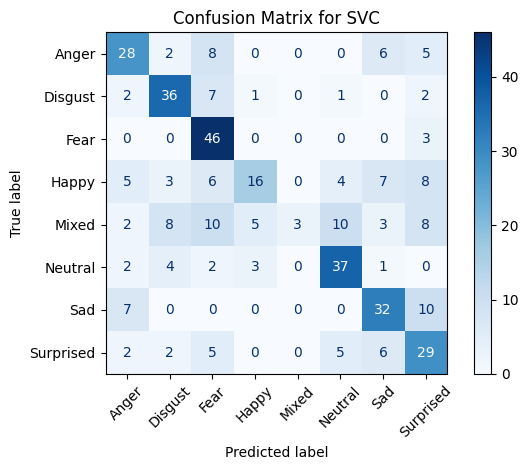

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


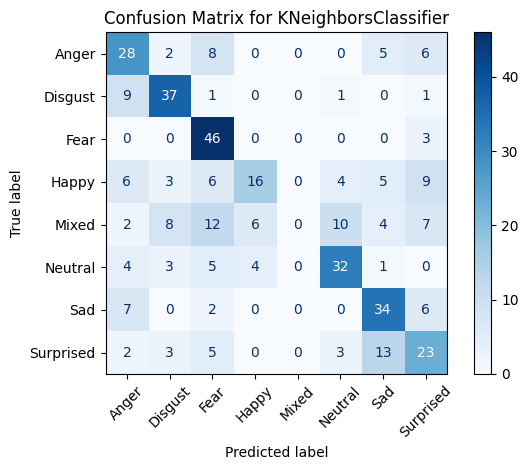

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.625000      0.596289   0.625000     0.598327
0  DecisionTreeClassifier     0.612245      0.583184   0.612245     0.587512
2                     SVC     0.579082      0.637824   0.579082     0.541430
3    KNeighborsClassifier     0.551020      0.488325   0.551020     0.505343

In [183]:
summary_smote_gsr_fft = cross_validate_models_smote(models, X_fft_smote, y_fft_smote, emotion_labels)
summary_smote_gsr_fft

### Wavelet transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.40      0.31         5
     Disgust       0.50      0.78      0.61         9
        Fear       0.62      0.83      0.71         6
       Happy       0.52      0.70      0.60        20
       Mixed       0.25      0.13      0.17        15
     Neutral       0.33      0.18      0.24        11
         Sad       0.67      0.40      0.50         5
   Surprised       0.50      0.20      0.29         5

    accuracy                           0.46        76
   macro avg       0.46      0.45      0.43        76
weighted avg       0.44      0.46      0.43        76



<Figure size 1000x800 with 0 Axes>

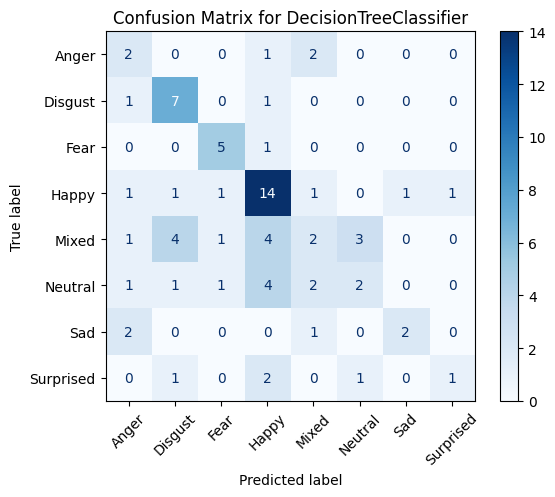

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.40      0.31         5
     Disgust       0.50      0.78      0.61         9
        Fear       0.62      0.83      0.71         6
       Happy       0.52      0.70      0.60        20
       Mixed       0.25      0.13      0.17        15
     Neutral       0.33      0.18      0.24        11
         Sad       0.67      0.40      0.50         5
   Surprised       0.50      0.20      0.29         5

    accuracy                           0.46        76
   macro avg       0.46      0.45      0.43        76
weighted avg       0.44      0.46      0.43        76



<Figure size 1000x800 with 0 Axes>

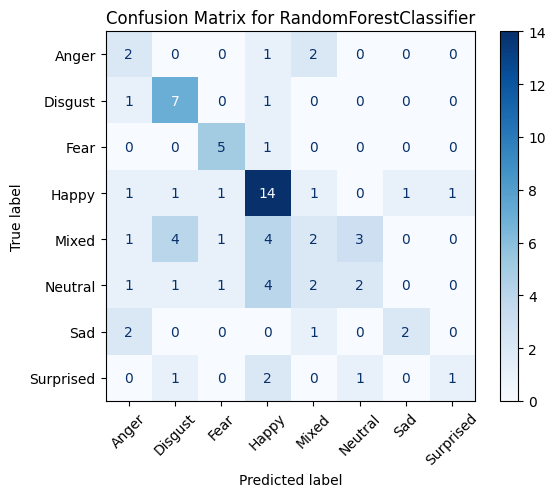

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.33      0.40      0.36         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.60      0.50      0.55         6
       Happy       0.48      0.75      0.59        20
       Mixed       0.31      0.67      0.43        15
     Neutral       0.00      0.00      0.00        11
         Sad       0.50      0.20      0.29         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.41        76
   macro avg       0.28      0.31      0.28        76
weighted avg       0.29      0.41      0.32        76



<Figure size 1000x800 with 0 Axes>

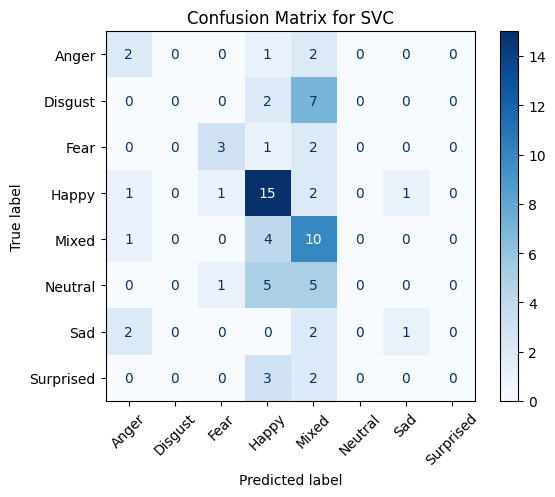

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.50      0.78      0.61         9
        Fear       0.25      1.00      0.40         6
       Happy       0.27      0.40      0.32        20
       Mixed       0.14      0.07      0.09        15
     Neutral       0.00      0.00      0.00        11
         Sad       1.00      0.20      0.33         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.30        76
   macro avg       0.27      0.31      0.22        76
weighted avg       0.24      0.30      0.23        76



<Figure size 1000x800 with 0 Axes>

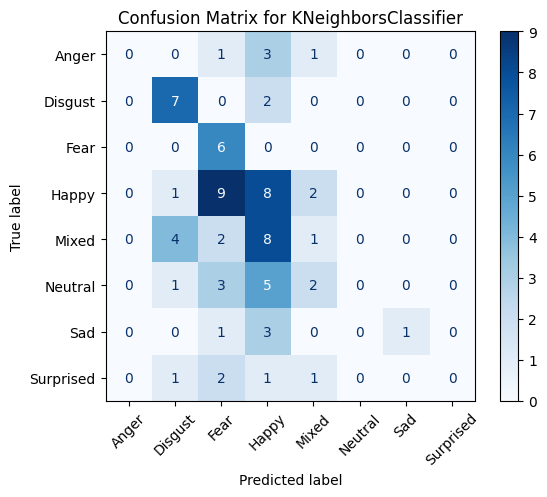

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.551136          0.460526   
 1  RandomForestClassifier           0.551136          0.460526   
 2                     SVC           0.465909          0.407895   
 3    KNeighborsClassifier           0.363636          0.302632   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.435794        0.460526          0.425564  
 1           0.435794        0.460526          0.425564  
 2           0.291205        0.407895          0.324568  
 3           0.243108        0.302632          0.227744  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25)])

In [184]:
summary_gsr_wt = fit_and_score_models(models, X_train_wt, X_test_wt, y_train_wt, y_test_wt)
summary_gsr_wt

### Wavelet transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


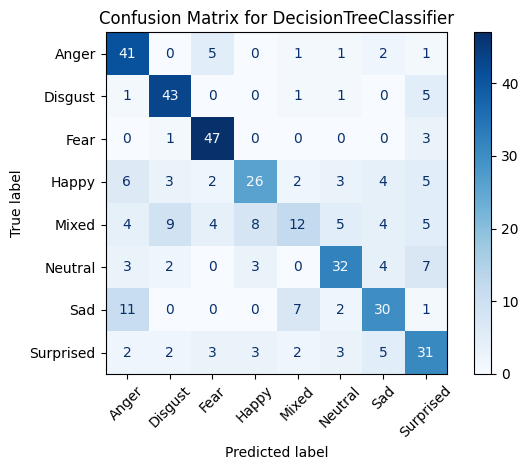

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


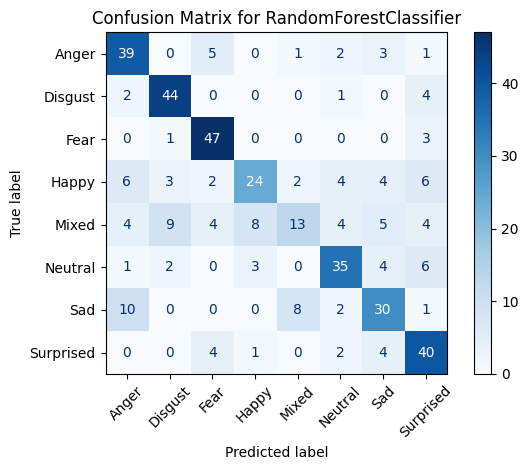

Cross-validating SVC...
Plotting confusion matrix for SVC...


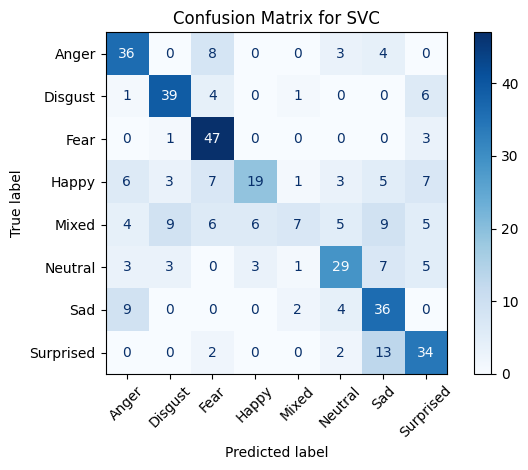

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


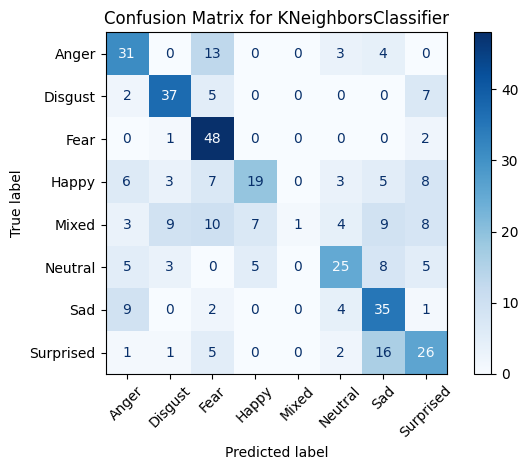

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.666667      0.657072   0.666667     0.649662
0  DecisionTreeClassifier     0.642157      0.630960   0.642157     0.626528
2                     SVC     0.605392      0.612486   0.605392     0.579023
3    KNeighborsClassifier     0.544118      0.611965   0.544118     0.504175

In [185]:
summary_smote_gsr_wt = cross_validate_models_smote(models, X_wt_smote, y_wt_smote, emotion_labels)
summary_smote_gsr_wt

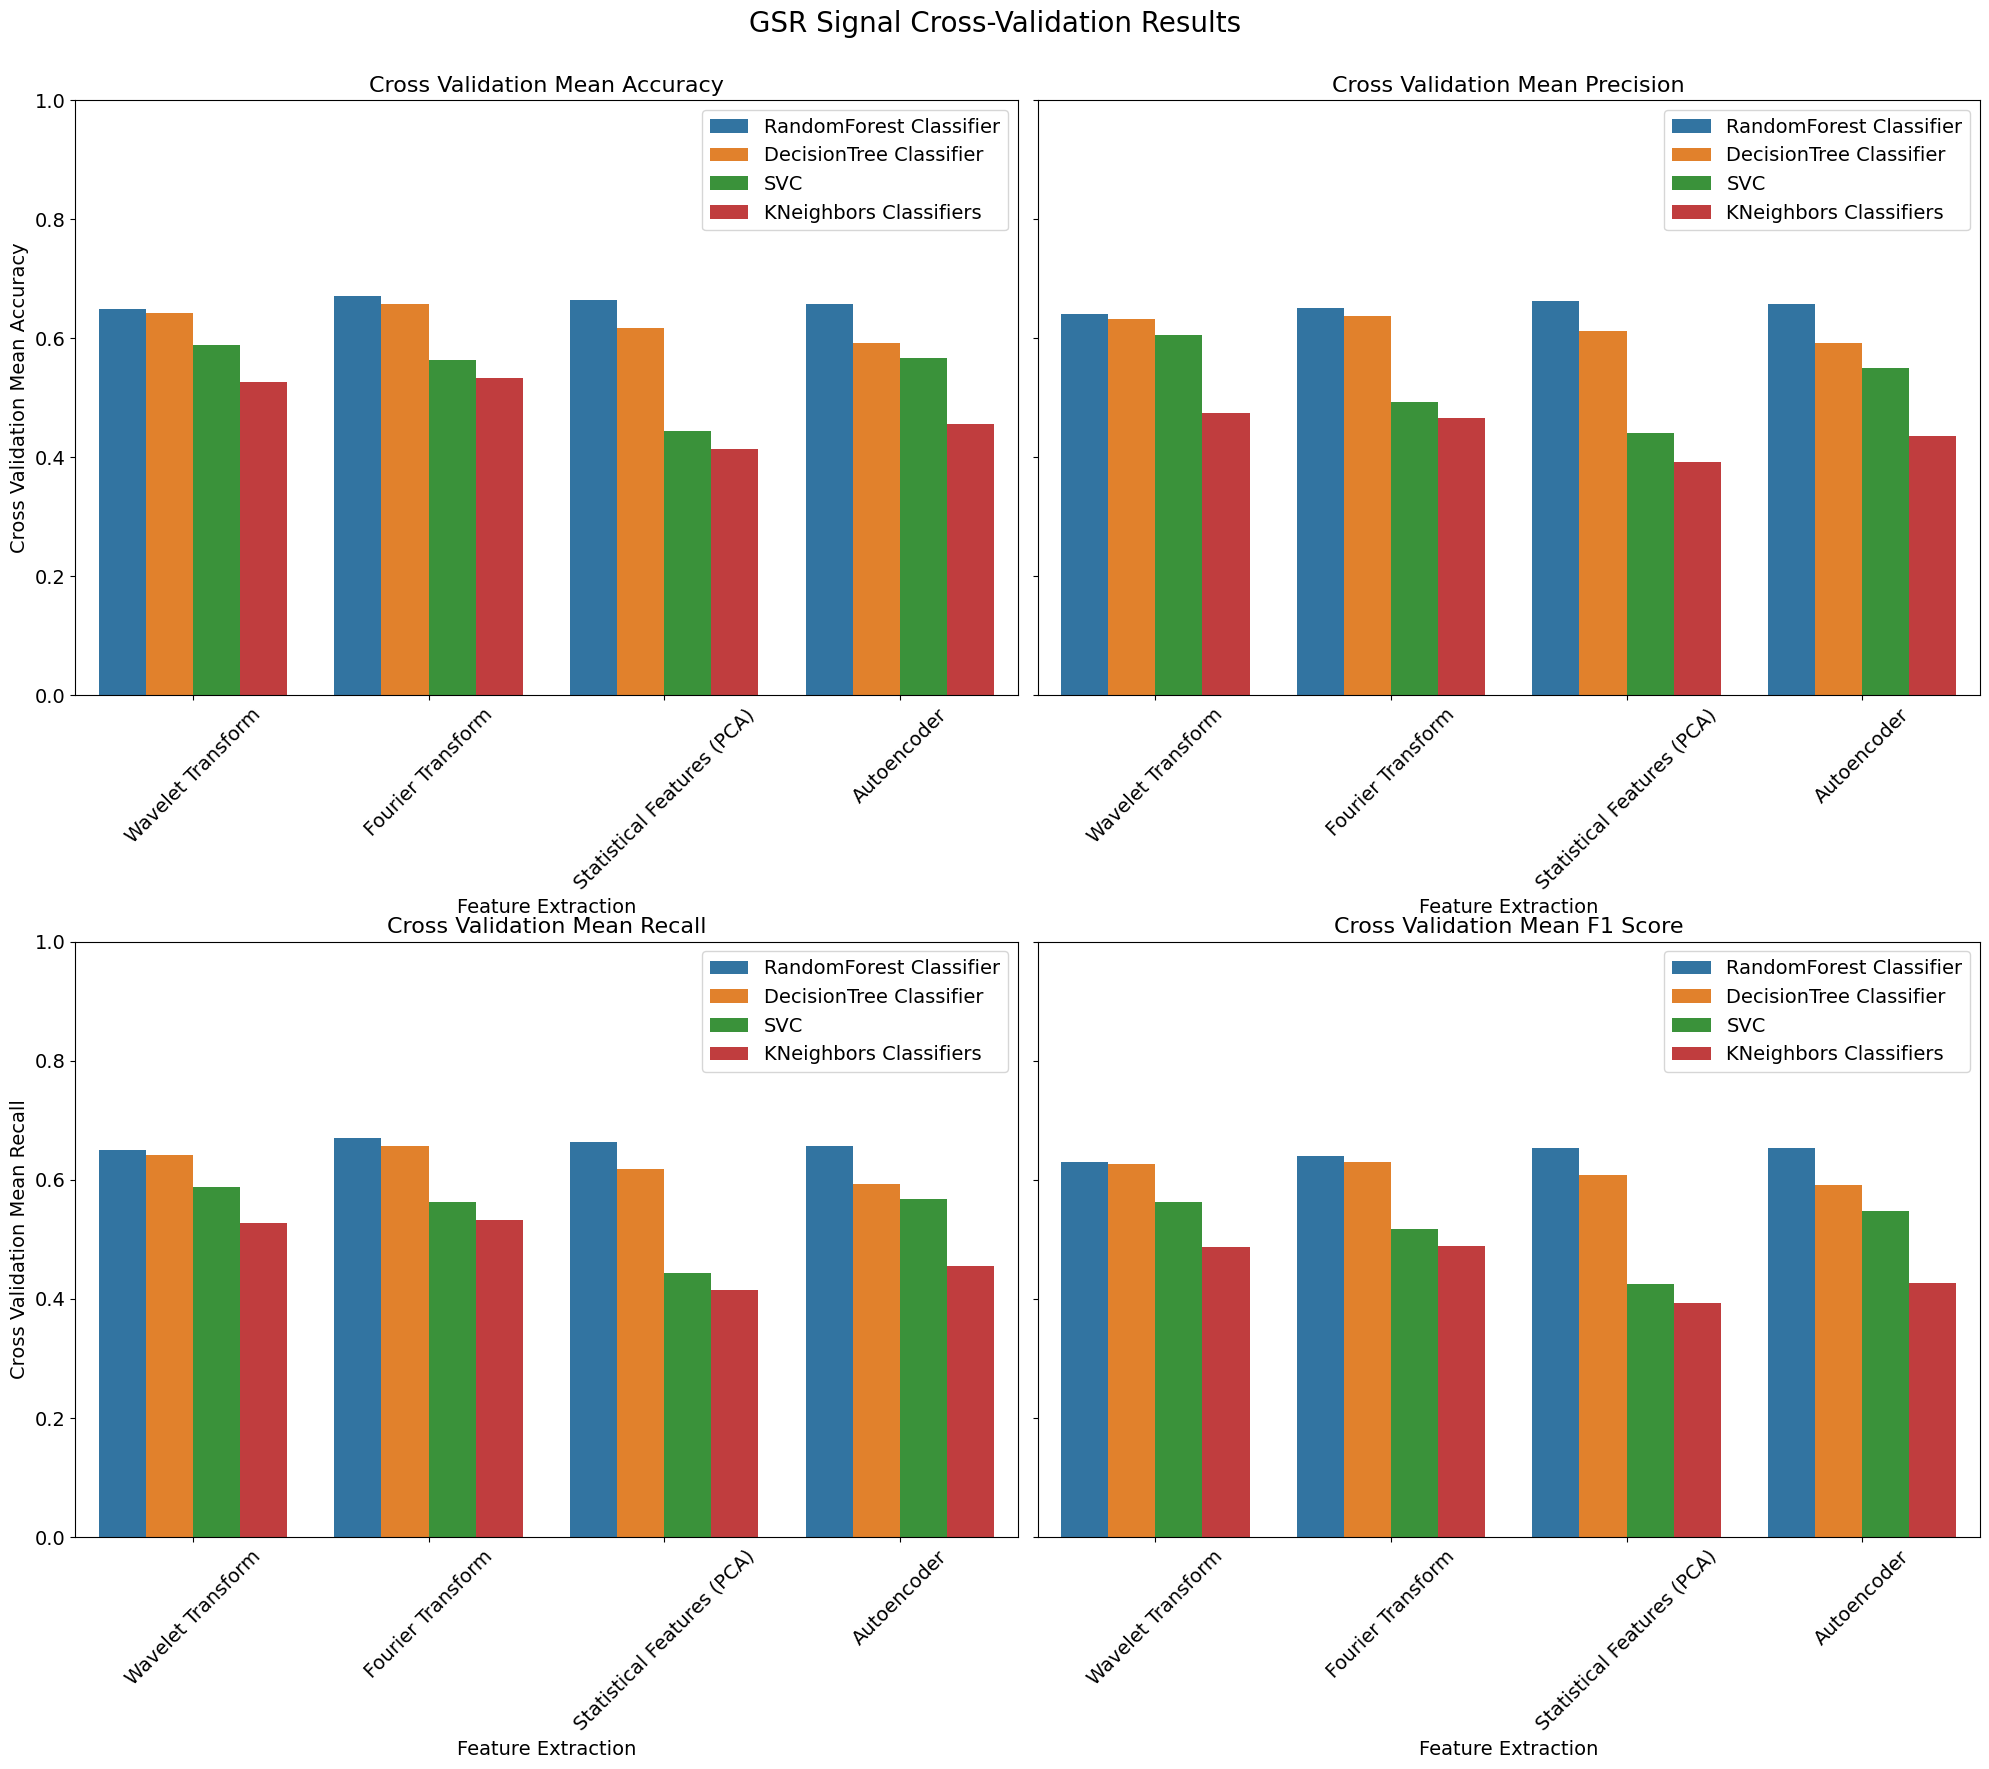

In [187]:
# GSR Results data

data_gsr = {
    "Feature Extraction": [
        "Wavelet Transform", "Wavelet Transform", "Wavelet Transform", "Wavelet Transform",
        "Fourier Transform", "Fourier Transform", "Fourier Transform", "Fourier Transform",
        "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)",
        "Autoencoder", "Autoencoder", "Autoencoder", "Autoencoder"
    ],
    "Model": [
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers"
    ],
    "Cross Validation Mean Accuracy": [
        0.649510, 0.642157, 0.588235, 0.526961,
        0.6700, 0.6575, 0.5625, 0.5325,
        0.664216, 0.617647, 0.443627, 0.414216,
        0.657407, 0.592593, 0.567130, 0.456019
    ],
    "Cross Validation Mean Precision": [
        0.639764, 0.631373, 0.605938, 0.474575,
        0.650048, 0.637926, 0.493212, 0.465297,
        0.663014, 0.611750, 0.440270, 0.391913,
        0.656722, 0.591209, 0.549774, 0.436399
    ],
    "Cross Validation Mean Recall": [
        0.649510, 0.642157, 0.588235, 0.526961,
        0.6700, 0.6575, 0.5625, 0.5325,
        0.664216, 0.617647, 0.443627, 0.414216,
        0.657407, 0.592593, 0.567130, 0.456019
    ],
    "Cross Validation Mean F1 Score": [
        0.629947, 0.627373, 0.561997, 0.486987,
        0.640570, 0.629523, 0.516796, 0.488641,
        0.654241, 0.607491, 0.424408, 0.393140,
        0.654314, 0.591179, 0.548308, 0.427078
    ]
}

plot_cross_validation_results(data_gsr, 'results_comparison_gsr.png', "GSR Signal Cross-Validation Results")

## COMBINE ECG AND GSR SIGNALS  AND EXTRACT FEATURES

#### Concatinating ECG AND GSR signals dataframes

In [188]:
ecg_gsr = pd.concat([ecg_signals, gsr_signals], axis = 1)

In [189]:
ecg_gsr_signals = ecg_gsr.copy()
ecg_gsr_signals.head(2)

feature_ecg  Participant ID  \
0  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   
1  [-18.702, -18.694, -18.692, -18.678, -18.665, ...              10   

   Session ID  Video ID Name  Age Gender  Valence level  Arousal level  \
0           1         1  S_D    8   Male              8              3   
1           1         1  S_D    8   Male              9              7   

   Dominance level  ...      hr_gsr NNx_gsr pNNx_gsr   sd1_gsr   sd2_gsr  \
0                0  ...  288.973793       0      0.0  0.050926  0.302952   
1                0  ...  288.973793       0      0.0  0.050926  0.302952   

    avrr_gsr  skew_gsr   kurt_gsr csi_gsr modifiedcvi_gsr  
0 -18.766022  3.058683  12.166933  0.1681        0.034243  
1 -18.766022  3.058683  12.166933  0.1681        0.034243  

[2 rows x 78 columns]

In [190]:
ecg_gsr_signals.columns

Index(['feature_ecg', 'Participant ID', 'Session ID', 'Video ID', 'Name',
       'Age', 'Gender', 'Valence level', 'Arousal level', 'Dominance level',
       'Happy', 'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised',
       'Familiarity Score', 'emotion_ecg', 'Valence', 'Arousal', 'Four label',
       'Annotation', 'Target Emotion', 'meanrr_ecg', 'medianrr_ecg',
       'sdrr_ecg', 'rmssd_ecg', 'sdrr_rmssd_ecg', 'hr_ecg', 'NNx_ecg',
       'pNNx_ecg', 'sd1_ecg', 'sd2_ecg', 'avrr_ecg', 'skew_ecg', 'kurt_ecg',
       'csi_ecg', 'modifiedcvi_ecg', 'feature_gsr', 'Participant ID',
       'Session ID', 'Video ID', 'Name', 'Age', 'Gender', 'Valence level',
       'Arousal level', 'Dominance level', 'Happy', 'Sad', 'Fear', 'Anger',
       'Neutral', 'Disgust', 'Surprised', 'Familiarity Score', 'emotion_gsr',
       'Valence', 'Arousal', 'Four label', 'Annotation', 'Target Emotion',
       'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr', 'sdrr_rmssd_gsr',
       'hr_gsr', 'NNx_gs

In [191]:
ecg_gsr_signals = ecg_gsr_signals.drop(['feature_ecg', 'Participant ID', 'Session ID', 'Video ID', 'Name', 'Age',
       'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy',
       'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised',
       'Familiarity Score', 'Valence', 'Arousal', 'Four label',
       'Annotation', 'Target Emotion', 'feature_gsr', 'Participant ID', 'Session ID',
       'Video ID', 'Name', 'Age', 'Gender', 'Valence level', 'Arousal level',
       'Dominance level', 'Happy', 'Sad', 'Fear', 'Anger', 'Neutral',
       'Disgust', 'Surprised', 'Familiarity Score', 'Valence',
       'Arousal', 'Four label', 'Annotation', 'Target Emotion'], axis = 1)

In [192]:
print(ecg_gsr_signals.columns)

Index(['emotion_ecg', 'meanrr_ecg', 'medianrr_ecg', 'sdrr_ecg', 'rmssd_ecg',
       'sdrr_rmssd_ecg', 'hr_ecg', 'NNx_ecg', 'pNNx_ecg', 'sd1_ecg', 'sd2_ecg',
       'avrr_ecg', 'skew_ecg', 'kurt_ecg', 'csi_ecg', 'modifiedcvi_ecg',
       'emotion_gsr', 'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr',
       'sdrr_rmssd_gsr', 'hr_gsr', 'NNx_gsr', 'pNNx_gsr', 'sd1_gsr', 'sd2_gsr',
       'avrr_gsr', 'skew_gsr', 'kurt_gsr', 'csi_gsr', 'modifiedcvi_gsr'],
      dtype='object')


In [193]:
ecg_gsr_signals = ecg_gsr_signals.drop('emotion_ecg', axis = 1)

In [194]:
ecg_gsr_signals.head()

meanrr_ecg  medianrr_ecg  sdrr_ecg  rmssd_ecg  sdrr_rmssd_ecg      hr_ecg  \
0     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
1     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
2     209.625        194.25  0.221027   0.072777        3.037027  294.650732   
3     189.000        186.50  0.205307   0.064151        3.200358  317.593251   
4     219.500        221.50  0.197991   0.062261        3.180001  273.960919   

   NNx_ecg  pNNx_ecg   sd1_ecg   sd2_ecg  ...      hr_gsr  NNx_gsr  pNNx_gsr  \
0        0       0.0  0.050926  0.302952  ...  288.973793        0       0.0   
1        0       0.0  0.050926  0.302952  ...  288.973793        0       0.0   
2        1      25.0  0.051486  0.308310  ...  294.650732        1      25.0   
3        0       0.0  0.045385  0.286779  ...  317.593251        0       0.0   
4        0       0.0  0.044048  0.276516  ...  273.960919        0       0.0   

    sd1_gsr   sd2_gsr   avrr_gsr  skew_gsr   kurt_gsr   csi_gsr  \
0  0.050926  0.302952 -18.766022  3.058683  12.166933  0.168100   
1  0.050926  0.302952 -18.766022  3.058683  12.166933  0.168100   
2  0.051486  0.308310 -18.537975  3.158817  12.848869  0.166994   
3  0.045385  0.286779 -18.559574  2.862825  11.344312  0.158256   
4  0.044048  0.276516 -18.488177  2.842292  11.033996  0.159295   

   modifiedcvi_gsr  
0         0.034243  
1         0.034243  
2         0.034392  
3         0.028730  
4         0.028066  

[5 rows x 31 columns]

In [195]:
ecg_gsr_signals.columns

Index(['meanrr_ecg', 'medianrr_ecg', 'sdrr_ecg', 'rmssd_ecg', 'sdrr_rmssd_ecg',
       'hr_ecg', 'NNx_ecg', 'pNNx_ecg', 'sd1_ecg', 'sd2_ecg', 'avrr_ecg',
       'skew_ecg', 'kurt_ecg', 'csi_ecg', 'modifiedcvi_ecg', 'emotion_gsr',
       'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr', 'sdrr_rmssd_gsr',
       'hr_gsr', 'NNx_gsr', 'pNNx_gsr', 'sd1_gsr', 'sd2_gsr', 'avrr_gsr',
       'skew_gsr', 'kurt_gsr', 'csi_gsr', 'modifiedcvi_gsr'],
      dtype='object')

In [196]:
ecg_gsr_signals.rename(columns = {'emotion_gsr':'emotion'}, inplace = True)
ecg_gsr_signals.head()

meanrr_ecg  medianrr_ecg  sdrr_ecg  rmssd_ecg  sdrr_rmssd_ecg      hr_ecg  \
0     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
1     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
2     209.625        194.25  0.221027   0.072777        3.037027  294.650732   
3     189.000        186.50  0.205307   0.064151        3.200358  317.593251   
4     219.500        221.50  0.197991   0.062261        3.180001  273.960919   

   NNx_ecg  pNNx_ecg   sd1_ecg   sd2_ecg  ...      hr_gsr  NNx_gsr  pNNx_gsr  \
0        0       0.0  0.050926  0.302952  ...  288.973793        0       0.0   
1        0       0.0  0.050926  0.302952  ...  288.973793        0       0.0   
2        1      25.0  0.051486  0.308310  ...  294.650732        1      25.0   
3        0       0.0  0.045385  0.286779  ...  317.593251        0       0.0   
4        0       0.0  0.044048  0.276516  ...  273.960919        0       0.0   

    sd1_gsr   sd2_gsr   avrr_gsr  skew_gsr   kurt_gsr   csi_gsr  \
0  0.050926  0.302952 -18.766022  3.058683  12.166933  0.168100   
1  0.050926  0.302952 -18.766022  3.058683  12.166933  0.168100   
2  0.051486  0.308310 -18.537975  3.158817  12.848869  0.166994   
3  0.045385  0.286779 -18.559574  2.862825  11.344312  0.158256   
4  0.044048  0.276516 -18.488177  2.842292  11.033996  0.159295   

   modifiedcvi_gsr  
0         0.034243  
1         0.034243  
2         0.034392  
3         0.028730  
4         0.028066  

[5 rows x 31 columns]

In [197]:
ecg_gsr_signals.columns

Index(['meanrr_ecg', 'medianrr_ecg', 'sdrr_ecg', 'rmssd_ecg', 'sdrr_rmssd_ecg',
       'hr_ecg', 'NNx_ecg', 'pNNx_ecg', 'sd1_ecg', 'sd2_ecg', 'avrr_ecg',
       'skew_ecg', 'kurt_ecg', 'csi_ecg', 'modifiedcvi_ecg', 'emotion',
       'meanrr_gsr', 'medianrr_gsr', 'sdrr_gsr', 'rmssd_gsr', 'sdrr_rmssd_gsr',
       'hr_gsr', 'NNx_gsr', 'pNNx_gsr', 'sd1_gsr', 'sd2_gsr', 'avrr_gsr',
       'skew_gsr', 'kurt_gsr', 'csi_gsr', 'modifiedcvi_gsr'],
      dtype='object')

In [198]:
X = ecg_gsr_signals.drop(['emotion'], axis=1)
y = ecg_gsr_signals['emotion']

In [199]:
X.head()

meanrr_ecg  medianrr_ecg  sdrr_ecg  rmssd_ecg  sdrr_rmssd_ecg      hr_ecg  \
0     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
1     208.375        209.00  0.217225   0.071985        3.017659  288.973793   
2     209.625        194.25  0.221027   0.072777        3.037027  294.650732   
3     189.000        186.50  0.205307   0.064151        3.200358  317.593251   
4     219.500        221.50  0.197991   0.062261        3.180001  273.960919   

   NNx_ecg  pNNx_ecg   sd1_ecg   sd2_ecg  ...      hr_gsr  NNx_gsr  pNNx_gsr  \
0        0       0.0  0.050926  0.302952  ...  288.973793        0       0.0   
1        0       0.0  0.050926  0.302952  ...  288.973793        0       0.0   
2        1      25.0  0.051486  0.308310  ...  294.650732        1      25.0   
3        0       0.0  0.045385  0.286779  ...  317.593251        0       0.0   
4        0       0.0  0.044048  0.276516  ...  273.960919        0       0.0   

    sd1_gsr   sd2_gsr   avrr_gsr  skew_gsr   kurt_gsr   csi_gsr  \
0  0.050926  0.302952 -18.766022  3.058683  12.166933  0.168100   
1  0.050926  0.302952 -18.766022  3.058683  12.166933  0.168100   
2  0.051486  0.308310 -18.537975  3.158817  12.848869  0.166994   
3  0.045385  0.286779 -18.559574  2.862825  11.344312  0.158256   
4  0.044048  0.276516 -18.488177  2.842292  11.033996  0.159295   

   modifiedcvi_gsr  
0         0.034243  
1         0.034243  
2         0.034392  
3         0.028730  
4         0.028066  

[5 rows x 30 columns]

In [200]:
y[:10]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
5     Disgust
6       Anger
7       Happy
8         Sad
9     Neutral
Name: emotion, dtype: object

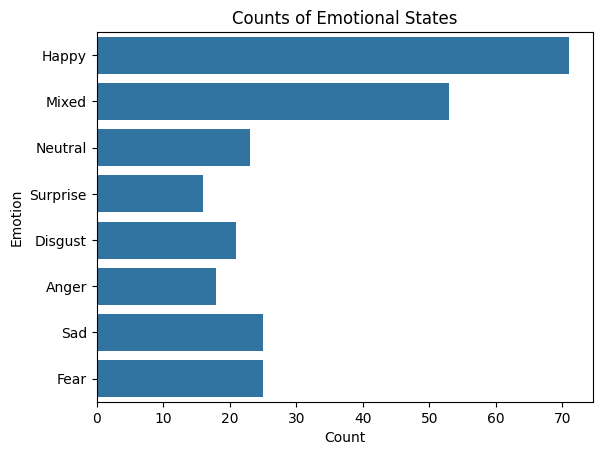

In [201]:
sns.countplot(y='emotion', data=ecg_gsr_signals)
plt.title('Counts of Emotional States')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

In [202]:
labelencoder = LabelEncoder()
y_le = to_categorical(labelencoder.fit_transform(y))

print(type(y_le))
print(y_le.shape)

<class 'numpy.ndarray'>
(252, 8)


In [203]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_le, test_size = 0.3, random_state = 0)

In [205]:
y_le

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [206]:
arr_shape

1000

#### Applying SMOTE to the training data

In [207]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [208]:
# Convert the one-hot encoded y_smote back to categorical
y_smote_count = np.argmax(y_smote, axis=1)

# Convert to pandas Series to use value_counts
y_smote_count = pd.Series(y_smote_count)

In [209]:
len(y_smote)

432

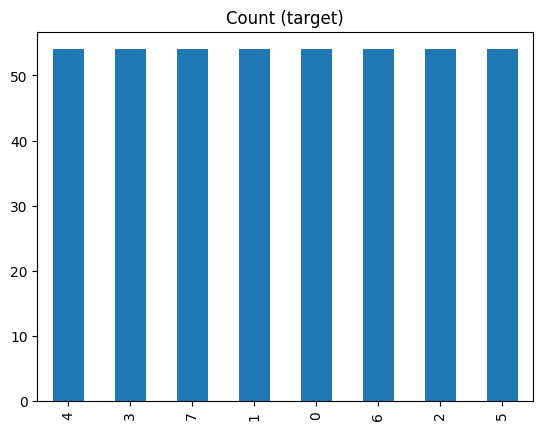

In [210]:
# Now you can use value_counts and plot
y_smote_count.value_counts().plot(kind='bar', title='Count (target)')
plt.show()

### AUTOENCODER 

In [211]:
# Get the number of features (columns) in X_smote
num_features = X_smote.shape[1]

# Define the input layer with the correct shape
input_layer = Input(shape=(num_features,))

# input_layer = Input(shape=(X_train_encoder[1],))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)

# Encoder model for feature extraction
encoder = Model(inputs=input_layer, outputs=encoded)

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(num_features, activation='sigmoid')(decoded)

# Full Autoencoder
autoencoder_smote = Model(inputs=input_layer, outputs=decoded)

In [212]:
autoencoder_smote.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,806 (92.99 KB)

 Trainable params: 23,102 (90.24 KB)

 Non-trainable params: 704 (2.75 KB)

In [213]:
# Compile the autoencoder
adam = Adam(learning_rate=0.0001)
autoencoder_smote.compile(optimizer='adam', loss='mse')

In [214]:
# Train the autoencoder
history = autoencoder_smote.fit(X_smote, X_smote,  # autoencoder is trained to reconstruct the input data
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

# Encoder model for feature extraction
encoder_smote_model = Model(inputs = input_layer, outputs = encoded)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.9916 - val_loss: 1.1585
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7839 - val_loss: 1.0949
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6437 - val_loss: 1.0265
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5967 - val_loss: 0.9612
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5800 - val_loss: 0.8975
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5573 - val_loss: 0.8441
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5395 - val_loss: 0.7956
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5225 - val_loss: 0.7550
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5123 - val_loss: 0.7191
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5072 - val_loss: 0.6912
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5177 - val_loss: 0.6673
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

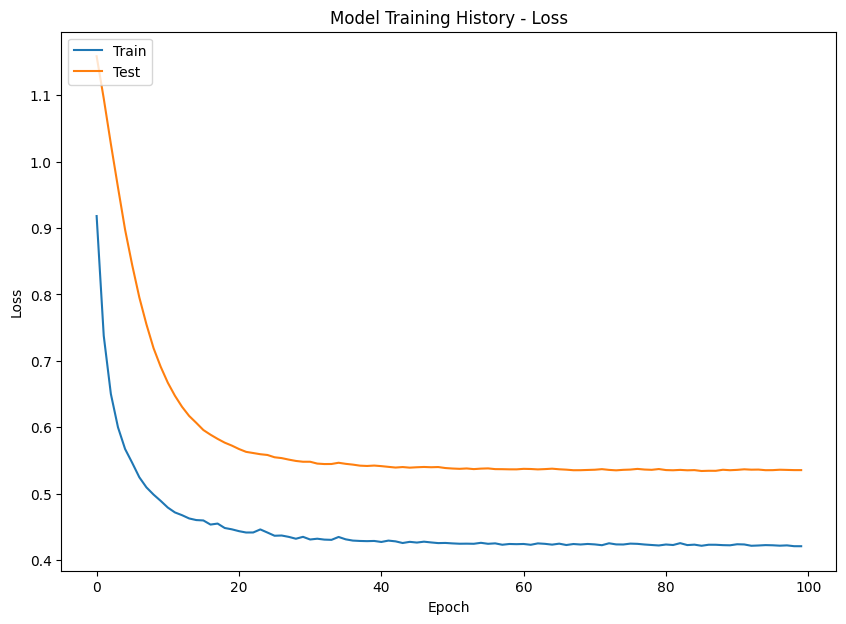

In [215]:
# Plotting the loss with its validation loss
plot_training_history(history)

In [216]:
# Use the encoder to transform the data
X_smote_encoded = encoder_smote_model.predict(X_smote)
X_test_encoded = encoder_smote_model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


### PCA ON STATISTICAL FEATURES

In [217]:
X = signals_ecg.drop(['emotion_ecg'], axis=1)
y = signals_ecg['emotion_ecg']

In [218]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [219]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Applying SMOTE for oversampling the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [220]:
# Applying PCA for dimensionality reduction on the SMOTE-transformed training data
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_smote_pca = pca.fit_transform(X_train_smote)

# Transforming the test data with the same PCA transformation
X_test_pca = pca.transform(X_test)

### FOURIER TRANSFORM

In [221]:
signals = ecg_gsr.copy()

In [222]:
signals.rename(columns = {'emotion_ecg':'emotion'}, inplace = True)
signals = signals[['feature_ecg', 'feature_gsr', 'emotion']]
signals.head()

feature_ecg  \
0  [-18.702, -18.694, -18.692, -18.678, -18.665, ...   
1  [-18.702, -18.694, -18.692, -18.678, -18.665, ...   
2  [-18.619, -18.624, -18.615, -18.604, -18.616, ...   
3  [-18.705, -18.669, -18.642, -18.586, -18.552, ...   
4  [-18.561, -18.561, -18.557, -18.557, -18.545, ...   

                                         feature_gsr   emotion  
0  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...     Happy  
1  [246.32, 246.41, 246.59, 246.52, 246.58, 246.8...     Happy  
2  [631.12, 630.95, 631.12, 630.4, 631.03, 631.04...     Mixed  
3  [357.72, 357.43, 357.32, 357.24, 356.95, 357.0...   Neutral  
4  [438.26, 437.83, 438.21, 438.14, 438.2, 438.15...  Surprise

In [223]:
def apply_fourier_transform_signals(signal):
    # Apply Fast Fourier Transform (FFT)
    fft_transform = np.fft.fft(signal)
    
    # Extract magnitude and phase
    magnitude = np.abs(fft_transform)
    phase = np.angle(fft_transform)
    
    # Return a subset of features (you can choose which ones)
    return np.concatenate([magnitude[:10], phase[:10]])  # Adjust the number as needed

In [224]:
# Apply Fourier Transform to each row in the DataFrame
feature_ecg_fft = np.array([apply_fourier_transform_signals(arr) for arr in signals['feature_ecg']])
feature_gsr_fft = np.array([apply_fourier_transform_signals(arr) for arr in signals['feature_gsr']])

In [225]:
feature_ecg_fft

array([[ 1.87660220e+04,  8.58203891e+00,  4.16380649e+00, ...,
        -6.33034538e-01, -1.39726141e-01,  1.15922184e+00],
       [ 1.87660220e+04,  8.58203891e+00,  4.16380649e+00, ...,
        -6.33034538e-01, -1.39726141e-01,  1.15922184e+00],
       [ 1.85379750e+04,  2.00011387e+01,  1.54785637e+01, ...,
         1.03165047e+00,  4.67389175e-01,  2.88622134e+00],
       ...,
       [ 3.68047360e+03,  2.13946153e+01,  1.22577229e+01, ...,
         2.12068546e+00,  2.46035008e+00,  2.54937394e+00],
       [ 3.97659840e+03,  9.70004174e+00,  3.83193550e+00, ...,
         1.96020451e+00,  2.36818915e+00,  2.51551692e+00],
       [ 2.03688790e+04,  4.25541555e+00,  8.91701092e+00, ...,
        -1.90028530e+00, -1.91814441e+00, -2.60466539e+00]])

In [226]:
feature_gsr_fft

array([[ 2.42955750e+05,  2.10652499e+03,  1.32593768e+03, ...,
        -2.69487877e+00,  3.10775278e+00,  2.60041957e+00],
       [ 2.42955750e+05,  2.10652499e+03,  1.32593768e+03, ...,
        -2.69487877e+00,  3.10775278e+00,  2.60041957e+00],
       [ 6.38951970e+05,  2.24729573e+03,  8.68265321e+02, ...,
         1.61824241e+00,  1.62410599e+00,  1.65498971e+00],
       ...,
       [ 3.93612210e+05,  2.10273789e+03,  8.81811430e+02, ...,
        -1.95075242e+00, -1.44317707e+00, -1.97706791e+00],
       [ 7.09014180e+05,  1.37725621e+03,  7.25252043e+02, ...,
         9.52677268e-01,  2.35163861e-01,  1.48331573e+00],
       [ 3.78989490e+05,  1.15497685e+04,  4.15024325e+03, ...,
        -1.45396091e+00, -1.47113495e+00, -1.34219340e+00]])

In [227]:
# Apply Fourier Transform to each row
feature_ecg_fft = np.array([apply_fourier_transform_signals(arr) for arr in signals['feature_ecg']])
feature_gsr_fft = np.array([apply_fourier_transform_signals(arr) for arr in signals['feature_gsr']])

# Convert to DataFrame
feature_ecg_fft_df = pd.DataFrame(feature_ecg_fft, columns=[f'feature_ecg_fft_{i}' for i in range(feature_ecg_fft.shape[1])])
feature_gsr_fft_df = pd.DataFrame(feature_gsr_fft, columns=[f'feature_gsr_fft_{i}' for i in range(feature_gsr_fft.shape[1])])

In [228]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals.drop(['feature_ecg', 'feature_gsr', 'emotion'], axis=1),
               feature_ecg_fft_df, feature_gsr_fft_df], axis=1)

In [229]:
X.columns

Index(['feature_ecg_fft_0', 'feature_ecg_fft_1', 'feature_ecg_fft_2',
       'feature_ecg_fft_3', 'feature_ecg_fft_4', 'feature_ecg_fft_5',
       'feature_ecg_fft_6', 'feature_ecg_fft_7', 'feature_ecg_fft_8',
       'feature_ecg_fft_9', 'feature_ecg_fft_10', 'feature_ecg_fft_11',
       'feature_ecg_fft_12', 'feature_ecg_fft_13', 'feature_ecg_fft_14',
       'feature_ecg_fft_15', 'feature_ecg_fft_16', 'feature_ecg_fft_17',
       'feature_ecg_fft_18', 'feature_ecg_fft_19', 'feature_gsr_fft_0',
       'feature_gsr_fft_1', 'feature_gsr_fft_2', 'feature_gsr_fft_3',
       'feature_gsr_fft_4', 'feature_gsr_fft_5', 'feature_gsr_fft_6',
       'feature_gsr_fft_7', 'feature_gsr_fft_8', 'feature_gsr_fft_9',
       'feature_gsr_fft_10', 'feature_gsr_fft_11', 'feature_gsr_fft_12',
       'feature_gsr_fft_13', 'feature_gsr_fft_14', 'feature_gsr_fft_15',
       'feature_gsr_fft_16', 'feature_gsr_fft_17', 'feature_gsr_fft_18',
       'feature_gsr_fft_19'],
      dtype='object')

In [230]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

In [231]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [232]:
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_scaled, y_encoded, test_size=0.3)

#### Applying SMOTE

In [233]:
smote_wt = SMOTE(sampling_strategy='auto', random_state=42)
X_wt_smote, y_wt_smote = smote_wt.fit_resample(X_train_wt, y_train_wt)

### WAVELET TRANSFORM

In [234]:
def apply_wavelet_transform_signals(signal, wavelet='db4', level=3):
    # Perform discrete wavelet transform
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Concatenate the approximation and detail coefficients
    features = []
    for coeff in coeffs:
        features.extend(coeff)
    
    return features[:20]  # Adjust the number as needed

In [235]:
# Apply Wavelet Transform to each row in the DataFrame
feature_ecg_wavelet = np.array([apply_wavelet_transform_signals(arr) for arr in signals['feature_ecg']])
feature_gsr_wavelet = np.array([apply_wavelet_transform_signals(arr) for arr in signals['feature_gsr']])

In [236]:
# Convert to DataFrame
feature_ecg_wavelet_df = pd.DataFrame(feature_ecg_wavelet, columns=[f'feature_ecg_wavelet_{i}' for i in range(feature_ecg_wavelet.shape[1])])
feature_gsr_wavelet_df = pd.DataFrame(feature_gsr_wavelet, columns=[f'feature_gsr_wavelet_{i}' for i in range(feature_gsr_wavelet.shape[1])])

In [237]:
# Concatenate the Fourier Transform features with the original DataFrame
X = pd.concat([signals.drop(['feature_ecg', 'feature_gsr', 'emotion'], axis=1),
               feature_ecg_wavelet_df, feature_gsr_wavelet_df], axis=1)

In [238]:
X.columns

Index(['feature_ecg_wavelet_0', 'feature_ecg_wavelet_1',
       'feature_ecg_wavelet_2', 'feature_ecg_wavelet_3',
       'feature_ecg_wavelet_4', 'feature_ecg_wavelet_5',
       'feature_ecg_wavelet_6', 'feature_ecg_wavelet_7',
       'feature_ecg_wavelet_8', 'feature_ecg_wavelet_9',
       'feature_ecg_wavelet_10', 'feature_ecg_wavelet_11',
       'feature_ecg_wavelet_12', 'feature_ecg_wavelet_13',
       'feature_ecg_wavelet_14', 'feature_ecg_wavelet_15',
       'feature_ecg_wavelet_16', 'feature_ecg_wavelet_17',
       'feature_ecg_wavelet_18', 'feature_ecg_wavelet_19',
       'feature_gsr_wavelet_0', 'feature_gsr_wavelet_1',
       'feature_gsr_wavelet_2', 'feature_gsr_wavelet_3',
       'feature_gsr_wavelet_4', 'feature_gsr_wavelet_5',
       'feature_gsr_wavelet_6', 'feature_gsr_wavelet_7',
       'feature_gsr_wavelet_8', 'feature_gsr_wavelet_9',
       'feature_gsr_wavelet_10', 'feature_gsr_wavelet_11',
       'feature_gsr_wavelet_12', 'feature_gsr_wavelet_13',
       'feature_g

In [239]:
y[:5]

0       Happy
1       Happy
2       Mixed
3     Neutral
4    Surprise
Name: emotion_ecg, dtype: object

In [240]:
X_train_wt, X_test_wt, y_train_wt, y_test_wt = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

#### Applying SMOTE to training data

In [241]:
smote_wt = SMOTE(sampling_strategy='auto', random_state=42)
X_wt_smote, y_wt_smote = smote_wt.fit_resample(X_train_wt, y_train_wt)

#### Displaying the results

### Autoencoder with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.25      0.20      0.22         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.33      0.33      0.33         6
       Happy       0.33      0.40      0.36        20
       Mixed       0.25      0.27      0.26        15
     Neutral       0.33      0.27      0.30        11
         Sad       0.12      0.20      0.15         5
   Surprised       0.20      0.20      0.20         5

    accuracy                           0.26        76
   macro avg       0.23      0.23      0.23        76
weighted avg       0.25      0.26      0.25        76



<Figure size 1000x800 with 0 Axes>

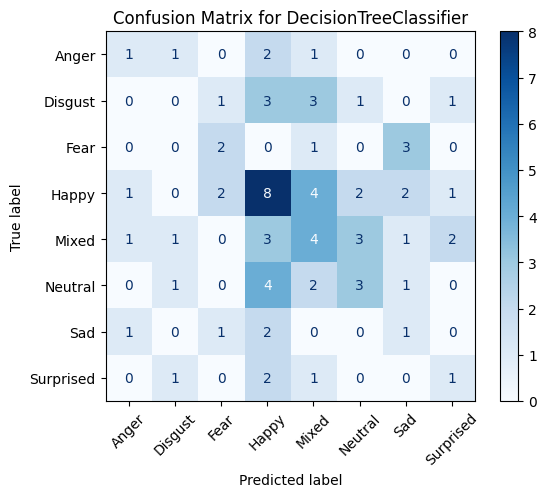

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.33      0.20      0.25         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.29      0.33      0.31         6
       Happy       0.32      0.50      0.39        20
       Mixed       0.36      0.33      0.34        15
     Neutral       0.43      0.27      0.33        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.40      0.40      0.40         5

    accuracy                           0.30        76
   macro avg       0.27      0.25      0.25        76
weighted avg       0.29      0.30      0.29        76



<Figure size 1000x800 with 0 Axes>

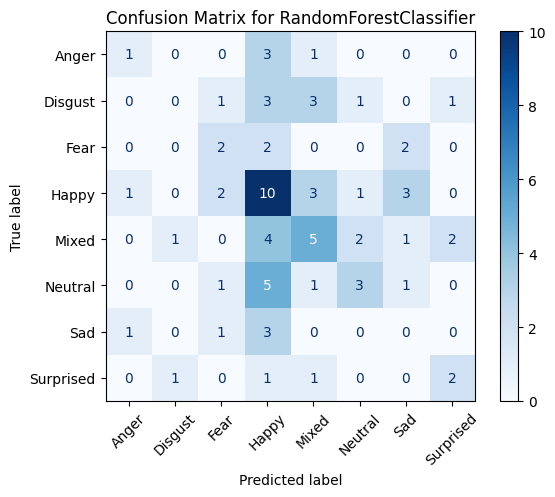

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.00      0.00      0.00         6
       Happy       0.26      0.55      0.35        20
       Mixed       0.23      0.40      0.29        15
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.22        76
   macro avg       0.06      0.12      0.08        76
weighted avg       0.11      0.22      0.15        76



<Figure size 1000x800 with 0 Axes>

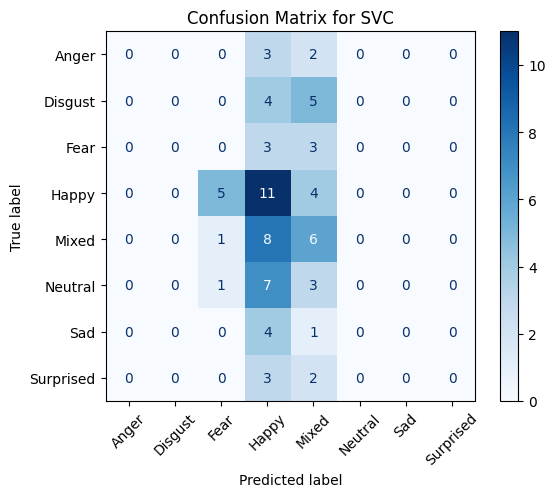

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       1.00      0.20      0.33         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.18      0.33      0.24         6
       Happy       0.31      0.60      0.41        20
       Mixed       0.16      0.27      0.20        15
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.25        76
   macro avg       0.21      0.17      0.15        76
weighted avg       0.19      0.25      0.19        76



<Figure size 1000x800 with 0 Axes>

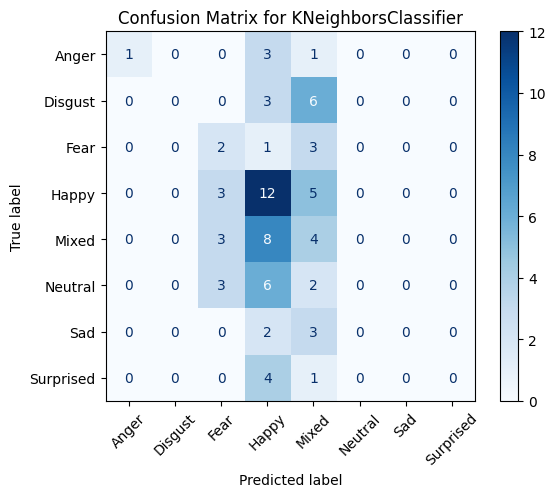

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.784091          0.263158   
 1  RandomForestClassifier           0.784091          0.302632   
 2                     SVC           0.386364          0.223684   
 3    KNeighborsClassifier           0.346591          0.250000   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.249452        0.263158          0.254264  
 1           0.288210        0.302632          0.286558  
 2           0.112866        0.223684          0.149663  
 3           0.192694        0.250000          0.187027  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25)])

In [242]:
summary_combined_autoencoder = fit_and_score_models(models, X_train, X_test, y_train, y_test)
summary_combined_autoencoder

### Autoencoder with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


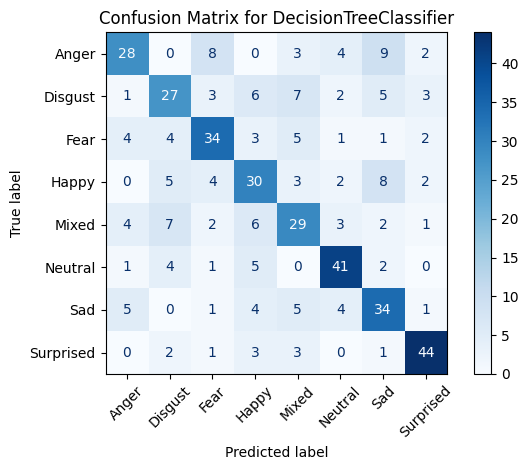

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


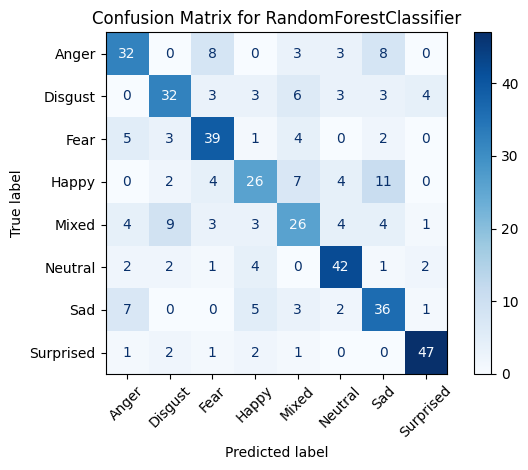

Cross-validating SVC...
Plotting confusion matrix for SVC...


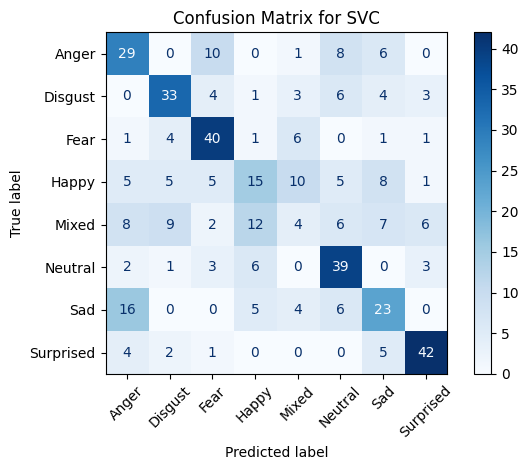

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


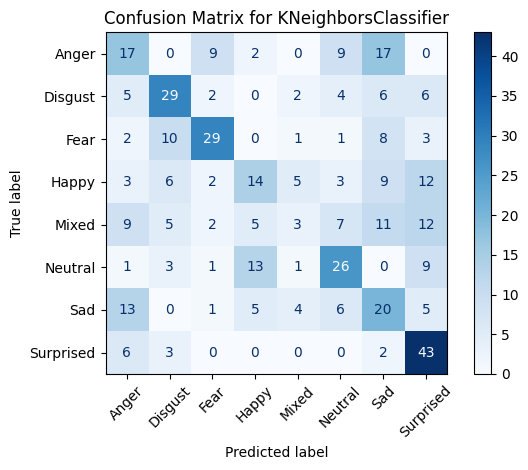

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.648148      0.646488   0.648148     0.645402
0  DecisionTreeClassifier     0.618056      0.619136   0.618056     0.617020
2                     SVC     0.520833      0.490447   0.520833     0.500760
3    KNeighborsClassifier     0.418981      0.401797   0.418981     0.398508

In [243]:
summary_smote_combined_autoencoder = cross_validate_models_smote(models, X_smote_encoded, y_smote, emotion_labels)
summary_smote_combined_autoencoder

### Statistical features with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


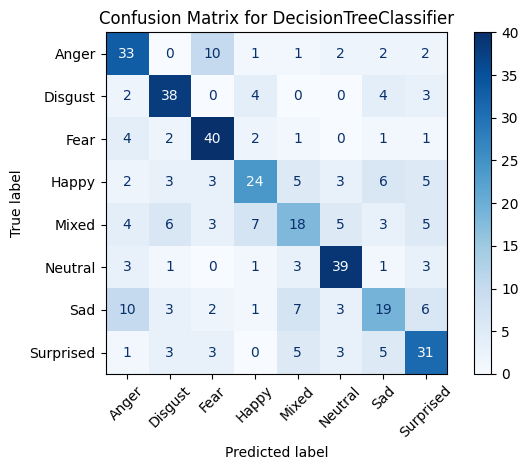

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


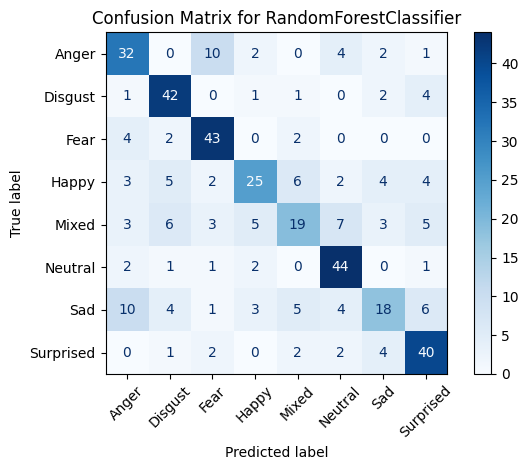

Cross-validating SVC...
Plotting confusion matrix for SVC...


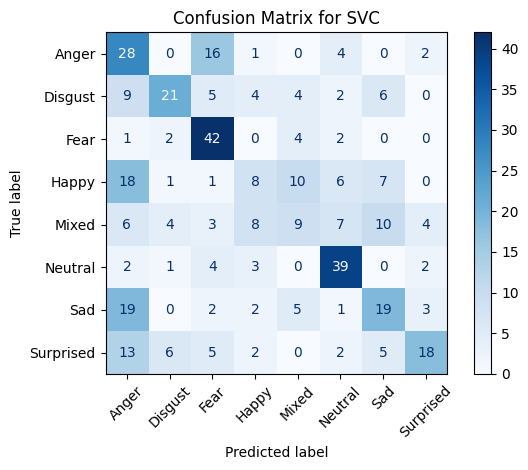

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


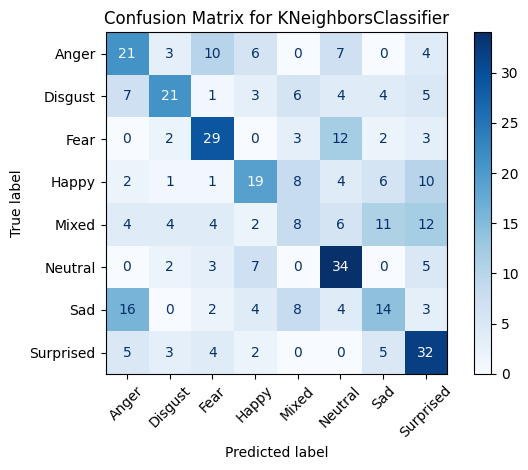

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.644608      0.633031   0.644608     0.629160
0  DecisionTreeClassifier     0.593137      0.583714   0.593137     0.584497
2                     SVC     0.450980      0.455136   0.450980     0.432732
3    KNeighborsClassifier     0.436275      0.428889   0.436275     0.424569

In [244]:
summary_smote_combined_pca = cross_validate_models_smote(models, X_train_smote_pca, y_train_smote, emotion_labels)
summary_smote_combined_pca

### Fourier transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.14      0.25      0.18         4
     Disgust       0.33      0.75      0.46         4
        Fear       0.38      0.33      0.35         9
       Happy       0.45      0.54      0.49        26
       Mixed       0.38      0.21      0.27        14
     Neutral       0.00      0.00      0.00         7
         Sad       0.40      0.33      0.36         6
   Surprised       0.00      0.00      0.00         6

    accuracy                           0.34        76
   macro avg       0.26      0.30      0.27        76
weighted avg       0.32      0.34      0.32        76



<Figure size 1000x800 with 0 Axes>

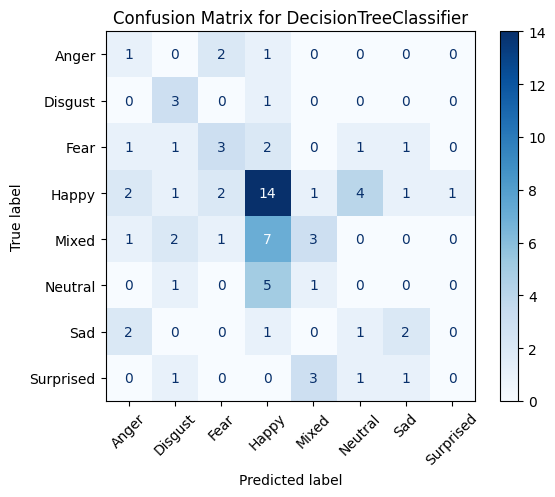

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         4
     Disgust       0.33      0.50      0.40         4
        Fear       0.43      0.33      0.38         9
       Happy       0.50      0.73      0.59        26
       Mixed       0.18      0.21      0.19        14
     Neutral       0.00      0.00      0.00         7
         Sad       1.00      0.50      0.67         6
   Surprised       0.00      0.00      0.00         6

    accuracy                           0.39        76
   macro avg       0.30      0.28      0.28        76
weighted avg       0.35      0.39      0.36        76



<Figure size 1000x800 with 0 Axes>

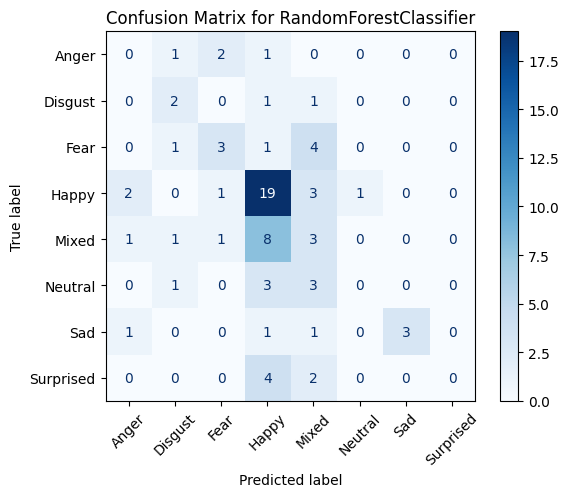

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         4
     Disgust       0.33      0.25      0.29         4
        Fear       0.20      0.11      0.14         9
       Happy       0.45      0.77      0.57        26
       Mixed       0.17      0.21      0.19        14
     Neutral       0.00      0.00      0.00         7
         Sad       1.00      0.50      0.67         6
   Surprised       0.00      0.00      0.00         6

    accuracy                           0.37        76
   macro avg       0.27      0.23      0.23        76
weighted avg       0.31      0.37      0.31        76



<Figure size 1000x800 with 0 Axes>

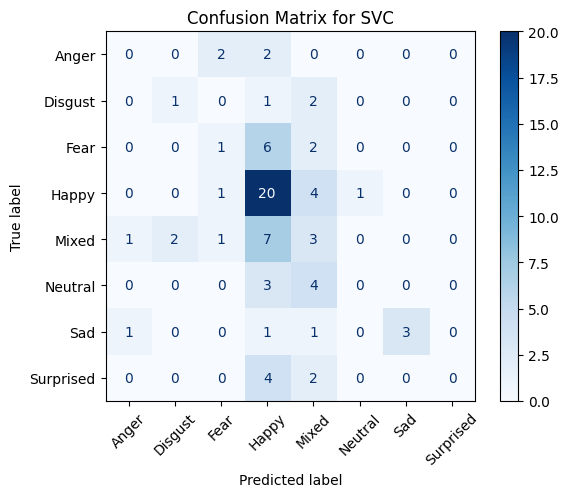

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         4
     Disgust       0.50      0.50      0.50         4
        Fear       0.13      0.22      0.17         9
       Happy       0.42      0.62      0.50        26
       Mixed       0.31      0.29      0.30        14
     Neutral       0.00      0.00      0.00         7
         Sad       0.00      0.00      0.00         6
   Surprised       0.00      0.00      0.00         6

    accuracy                           0.32        76
   macro avg       0.17      0.20      0.18        76
weighted avg       0.24      0.32      0.27        76



<Figure size 1000x800 with 0 Axes>

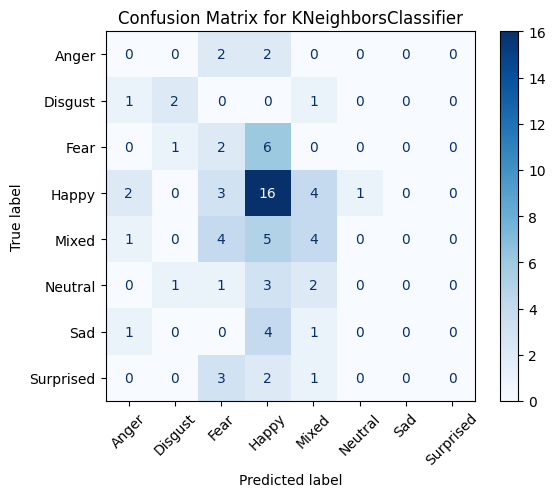

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.823864          0.342105   
 1  RandomForestClassifier           0.823864          0.394737   
 2                     SVC           0.647727          0.368421   
 3    KNeighborsClassifier           0.380682          0.315789   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.324628        0.342105          0.322656  
 1           0.350803        0.394737          0.356871  
 2           0.306380        0.368421          0.314615  
 3           0.242830        0.315789          0.271686  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25)])

In [245]:
summary_combined_fft = fit_and_score_models(models, X_train_fft, X_test_fft, y_train_fft, y_test_fft)
summary_combined_fft

### Fourier transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


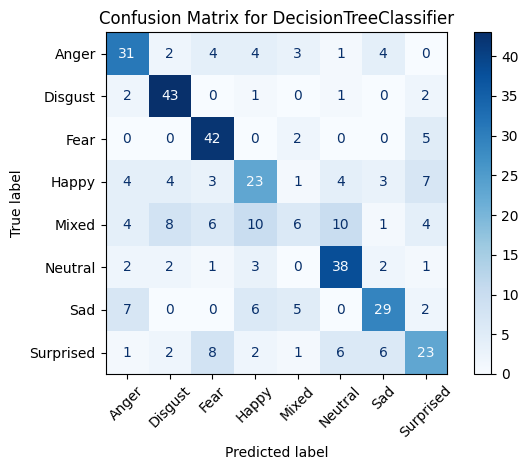

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


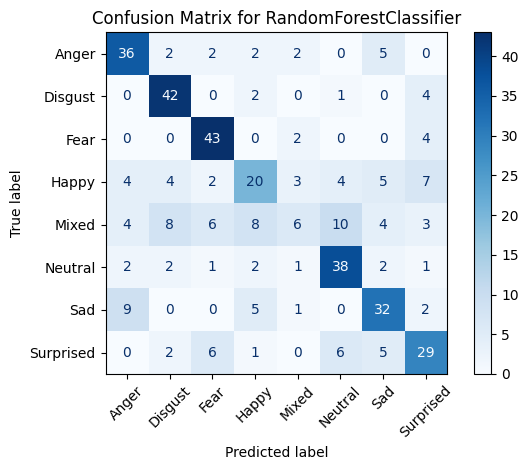

Cross-validating SVC...
Plotting confusion matrix for SVC...


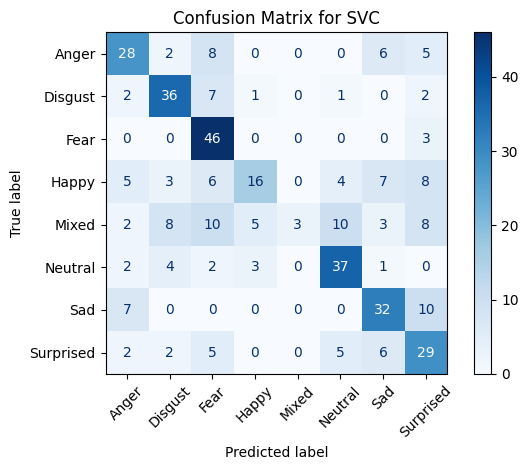

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


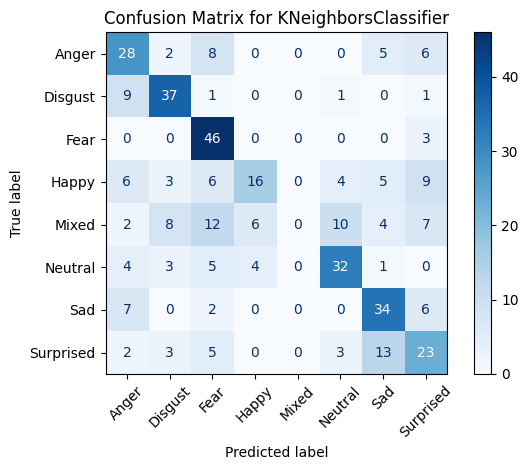

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
1  RandomForestClassifier     0.627551      0.599882   0.627551     0.600737
0  DecisionTreeClassifier     0.599490      0.571530   0.599490     0.575321
2                     SVC     0.579082      0.637824   0.579082     0.541430
3    KNeighborsClassifier     0.551020      0.488325   0.551020     0.505343

In [246]:
summary_smote_combined_fft = cross_validate_models_smote(models, X_fft_smote, y_fft_smote, emotion_labels)
summary_smote_combined_fft

### Wavelet transform with imbalanced data

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

       Anger       0.40      0.40      0.40         5
     Disgust       0.40      0.22      0.29         9
        Fear       0.56      0.83      0.67         6
       Happy       0.29      0.25      0.27        20
       Mixed       0.24      0.33      0.28        15
     Neutral       0.25      0.09      0.13        11
         Sad       0.14      0.20      0.17         5
   Surprised       0.25      0.40      0.31         5

    accuracy                           0.30        76
   macro avg       0.32      0.34      0.31        76
weighted avg       0.30      0.30      0.29        76



<Figure size 1000x800 with 0 Axes>

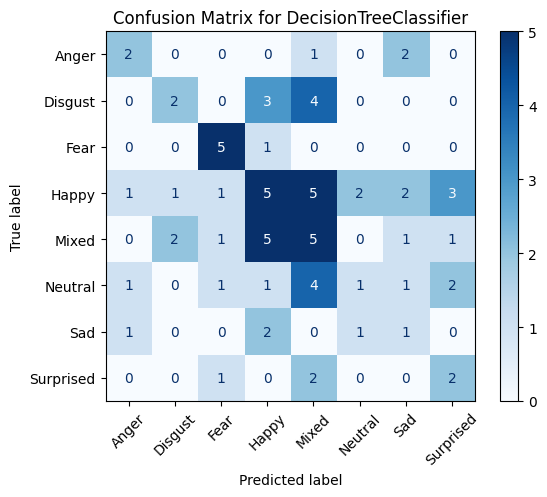

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

       Anger       0.33      0.20      0.25         5
     Disgust       0.50      0.44      0.47         9
        Fear       0.71      0.83      0.77         6
       Happy       0.36      0.50      0.42        20
       Mixed       0.17      0.20      0.18        15
     Neutral       0.20      0.09      0.12        11
         Sad       0.40      0.40      0.40         5
   Surprised       0.50      0.20      0.29         5

    accuracy                           0.36        76
   macro avg       0.40      0.36      0.36        76
weighted avg       0.35      0.36      0.34        76



<Figure size 1000x800 with 0 Axes>

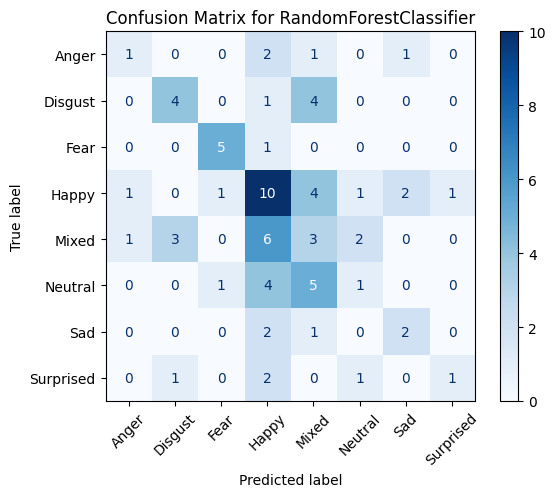

Classification Report for SVC:
              precision    recall  f1-score   support

       Anger       0.50      0.20      0.29         5
     Disgust       0.00      0.00      0.00         9
        Fear       0.67      0.67      0.67         6
       Happy       0.29      0.50      0.37        20
       Mixed       0.23      0.47      0.31        15
     Neutral       0.50      0.09      0.15        11
         Sad       0.50      0.20      0.29         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.32        76
   macro avg       0.34      0.27      0.26        76
weighted avg       0.31      0.32      0.27        76



<Figure size 1000x800 with 0 Axes>

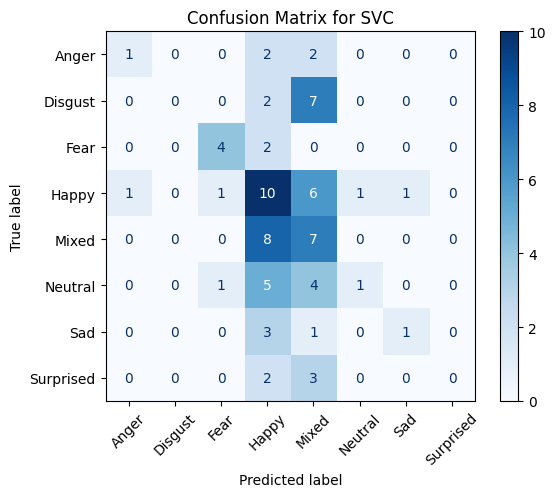

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       Anger       0.50      0.20      0.29         5
     Disgust       0.40      0.22      0.29         9
        Fear       0.20      0.67      0.31         6
       Happy       0.27      0.45      0.34        20
       Mixed       0.31      0.33      0.32        15
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00         5
   Surprised       0.00      0.00      0.00         5

    accuracy                           0.28        76
   macro avg       0.21      0.23      0.19        76
weighted avg       0.23      0.28      0.23        76



<Figure size 1000x800 with 0 Axes>

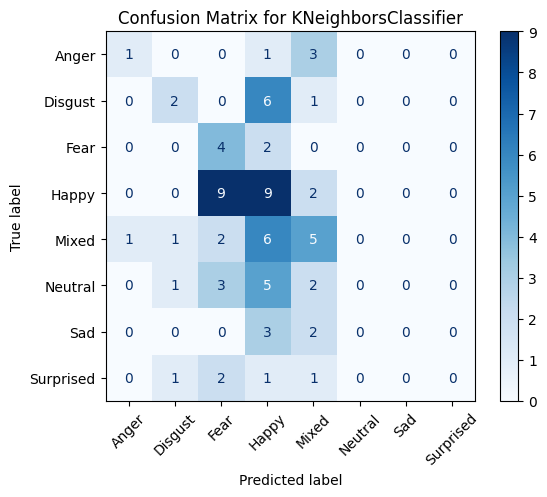

(                    Model  Training Accuracy  Testing Accuracy  \
 0  DecisionTreeClassifier           0.818182          0.302632   
 1  RandomForestClassifier           0.818182          0.355263   
 2                     SVC           0.659091          0.315789   
 3    KNeighborsClassifier           0.386364          0.276316   
 
    Testing Precision  Testing Recall  Testing F1 Score  
 0           0.303966        0.302632          0.289236  
 1           0.352569        0.355263          0.341643  
 2           0.314241        0.315789          0.271362  
 3           0.229501        0.276316          0.229965  ,
 [DecisionTreeClassifier(criterion='entropy', max_depth=12),
  RandomForestClassifier(),
  SVC(),
  KNeighborsClassifier(n_neighbors=25)])

In [247]:
summary_combined_wt = fit_and_score_models(models, X_train_wt, X_test_wt, y_train_wt, y_test_wt)
summary_combined_wt

### Wavelet transform with balanced data

Cross-validating DecisionTreeClassifier...
Plotting confusion matrix for DecisionTreeClassifier...


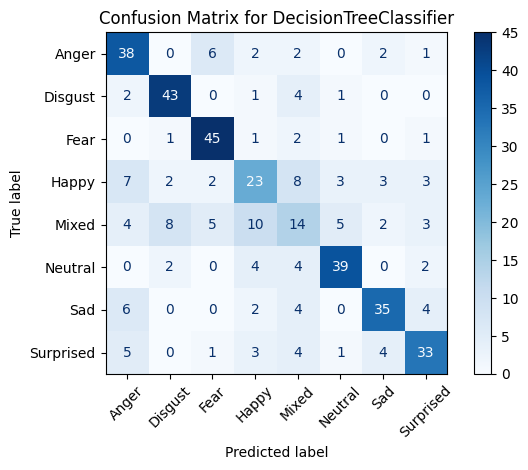

Cross-validating RandomForestClassifier...
Plotting confusion matrix for RandomForestClassifier...


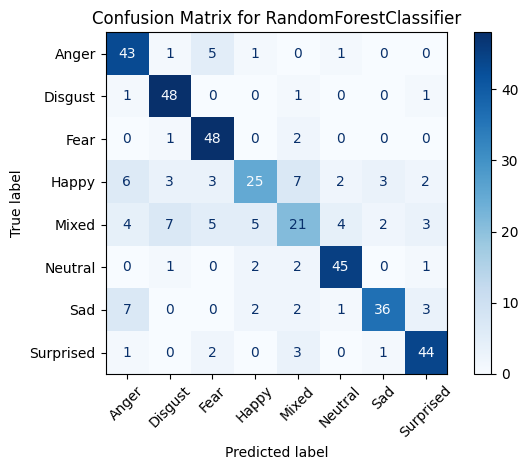

Cross-validating SVC...
Plotting confusion matrix for SVC...


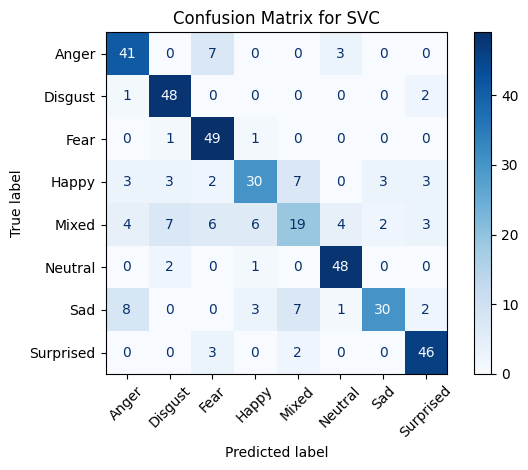

Cross-validating KNeighborsClassifier...
Plotting confusion matrix for KNeighborsClassifier...


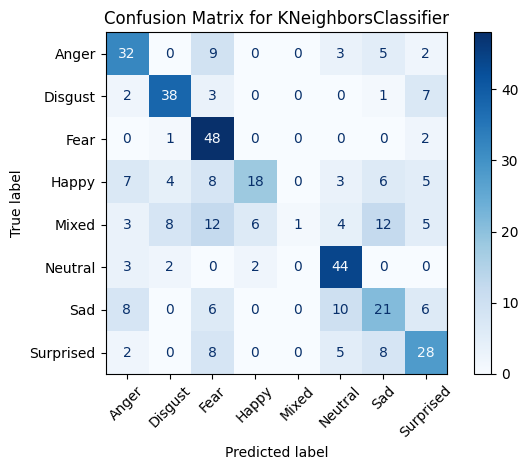

Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score
2                     SVC     0.762255      0.755976   0.762255     0.749454
1  RandomForestClassifier     0.759804      0.753784   0.759804     0.748911
0  DecisionTreeClassifier     0.661765      0.652475   0.661765     0.654648
3    KNeighborsClassifier     0.563725      0.628041   0.563725     0.519613

In [248]:
summary_smote_combined_wt = cross_validate_models_smote(models, X_wt_smote, y_wt_smote, emotion_labels)
summary_smote_combined_wt

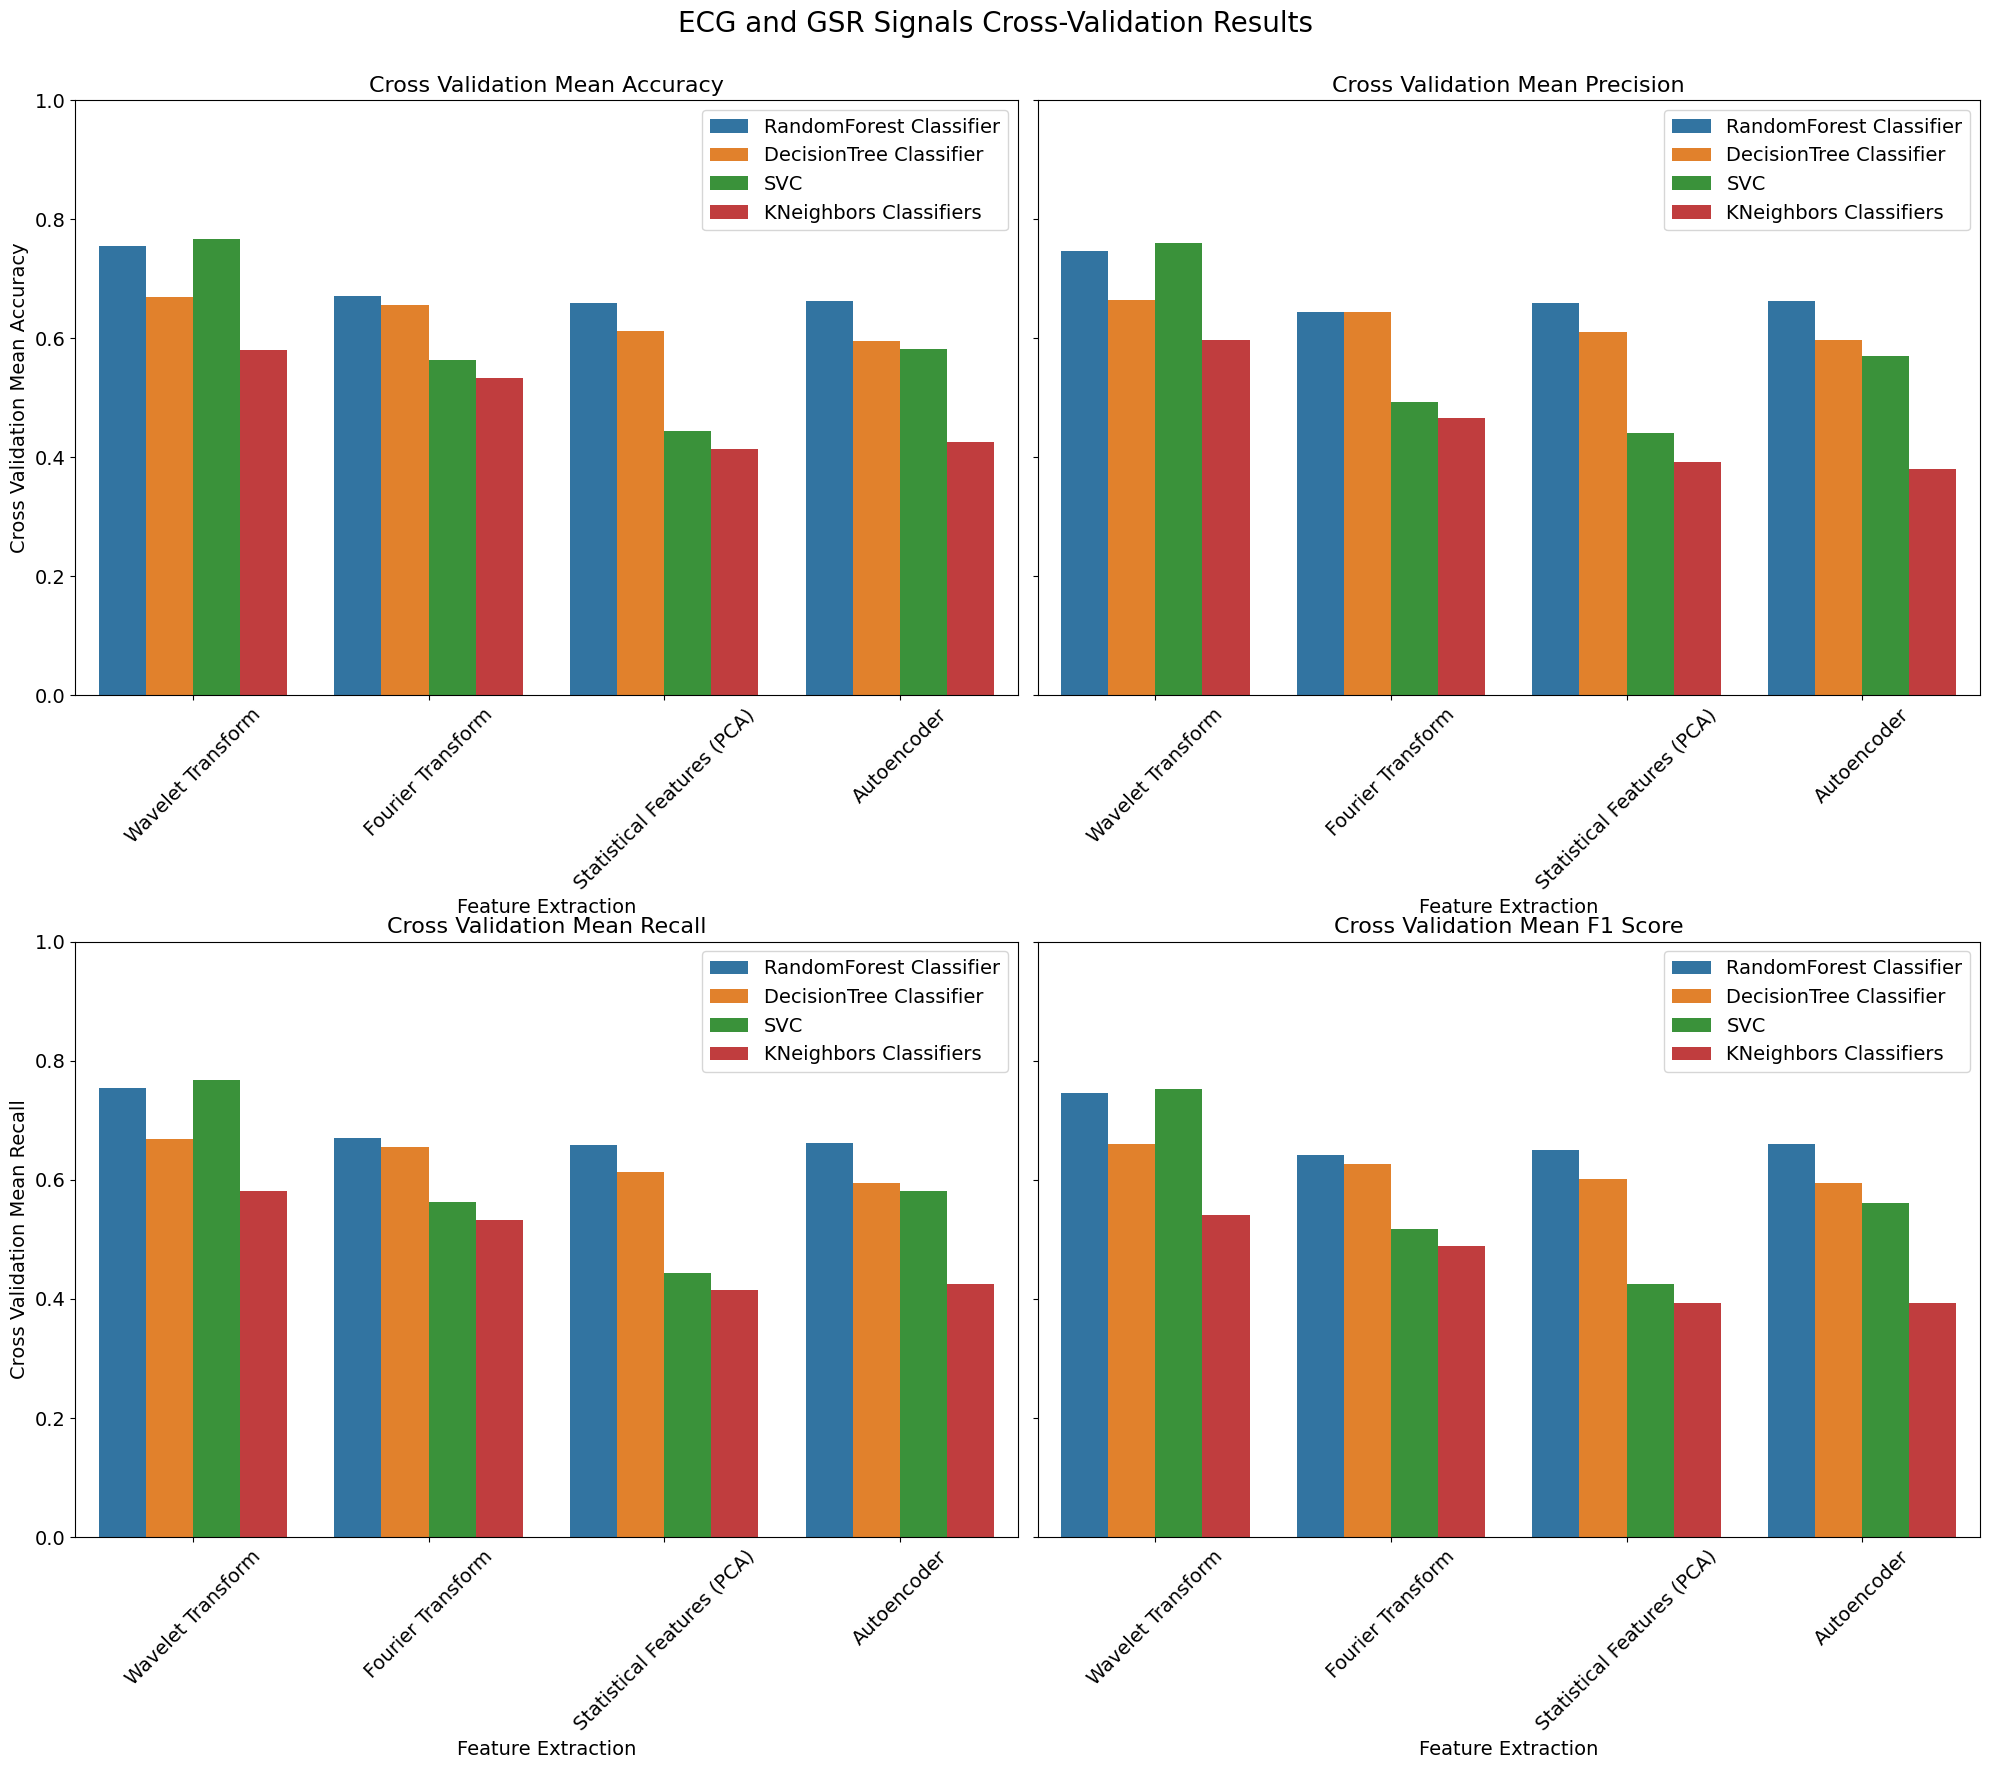

In [249]:
# Combined Results data

data_combined = {
    "Feature Extraction": [
        "Wavelet Transform", "Wavelet Transform", "Wavelet Transform", "Wavelet Transform",
        "Fourier Transform", "Fourier Transform", "Fourier Transform", "Fourier Transform",
        "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)", "Statistical Features (PCA)",
        "Autoencoder", "Autoencoder", "Autoencoder", "Autoencoder"
    ],
    "Model": [
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers",
        "RandomForest Classifier", "DecisionTree Classifier", "SVC", "KNeighbors Classifiers"
    ],
    "Cross Validation Mean Accuracy": [
        0.754902, 0.669118, 0.767157, 0.580882,
        0.6700, 0.6550, 0.5625, 0.5325,
        0.659314, 0.612745, 0.443627, 0.414216,
        0.662037, 0.594907, 0.581019, 0.425926
    ],
    "Cross Validation Mean Precision": [
        0.746683, 0.663779, 0.760449, 0.596273,
        0.644288, 0.643511, 0.493212, 0.465297,
        0.659576, 0.610387, 0.440270, 0.391913,
        0.662131, 0.596637, 0.569633, 0.381011
    ],
    "Cross Validation Mean Recall": [
        0.754902, 0.669118, 0.767157, 0.580882,
        0.6700, 0.6550, 0.5625, 0.5325,
        0.659314, 0.612745, 0.443627, 0.414216,
        0.662037, 0.594907, 0.581019, 0.425926
    ],
    "Cross Validation Mean F1 Score": [
        0.745117, 0.660969, 0.753259, 0.540718,
        0.641555, 0.626276, 0.516796, 0.488641,
        0.649890, 0.602178, 0.424408, 0.393140,
        0.659518, 0.595024, 0.561617, 0.393880
    ]
}

plot_cross_validation_results(data_combined, 'results_comparison_combined.png', "ECG and GSR Signals Cross-Validation Results")